In [ ]:
# Add the src directory to sys.path
import sys
sys.path.append(os.path.abspath('../src'))

In [11]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os
import time
from itertools import product
from scipy.stats import entropy
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.model_selection import cross_val_score
from sklearn.decomposition import PCA

import pandas as pd
import pickle

from Active_learning import *
from utils import *

In [2]:
df_input = pd.read_csv('df_combine_20240713.csv')
df_input['num_vesicles'] = df_input['num_vesicles'].round().astype(int)
df_input

,decanoic acid_Concentration (mM),decanoate_Concentration (mM),decylamine_Concentration (mM),decyl trimethylamine_Concentration (mM),decylsulfate_Concentration (mM),decanol_Concentration (mM),monocaprin_Concentration (mM),num_vesicles,area_vesicles,area_percent
0,0.440,0.505,0.490,0.280,0.079,0.3300,0.850,0,0.000000,0.000000
1,0.385,0.445,0.530,0.230,0.099,0.4125,0.810,0,0.000000,0.000000
2,0.360,0.495,0.535,0.215,0.091,0.4125,0.865,0,0.000000,0.000000
3,0.350,0.490,0.550,0.255,0.053,0.3825,0.850,0,0.000000,0.000000
4,0.360,0.495,0.505,0.250,0.111,0.4575,0.770,0,0.000000,0.000000
5,0.310,0.475,0.540,0.305,0.073,0.3750,0.900,0,0.000000,0.000000
6,0.350,0.410,0.625,0.295,0.095,0.3600,0.860,1,487.732259,0.000465
7,0.345,0.510,0.495,0.215,0.121,0.3375,0.910,1,1251.139274,0.001193
8,0.350,0.490,0.650,0.235,0.095,0.3825,0.795,0,0.000000,0.000000
9,0.380,0.490,0.595,0.275,0.081,0.3900,0.730,0,0.000000,0.000000


In [65]:
# Investigating False positive and false negatives

In [79]:
(df_input.iloc[0:24,-3:-2]<=0).sum()/len(df_input.iloc[0:24,-3:-2])

num_vesicles    0.916667
dtype: float64

In [84]:
(df_input.iloc[0:24,-3:-2]<=0).sum()

num_vesicles    22
dtype: int64

In [80]:
(df_input.iloc[24:48,-3:-2]>0).sum()/len(df_input.iloc[24:48,-3:-2])

num_vesicles    0.958333
dtype: float64

In [82]:
(df_input.iloc[24:48,-3:-2]>0).sum()

num_vesicles    23
dtype: int64

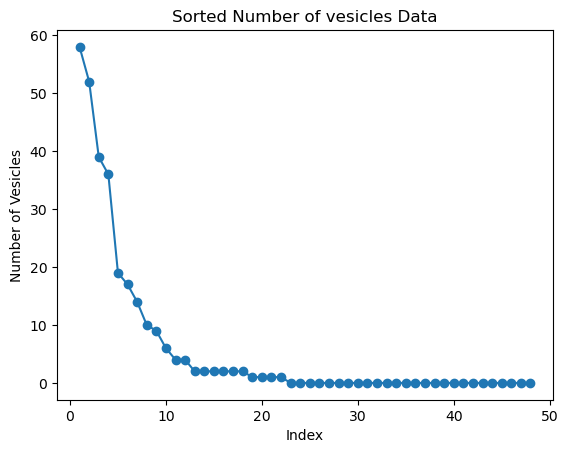

In [3]:
# Sort the DataFrame based on the "area_percent" column
df_sorted = df_input.sort_values(by="num_vesicles", ascending=False)

# Plot the sorted data
plt.plot(range(1, len(df_sorted) + 1), df_sorted["num_vesicles"], marker='o')
plt.xlabel("Index")
plt.ylabel("Number of Vesicles")
plt.title("Sorted Number of vesicles Data")
plt.show()

In [4]:
len(df_input[df_input['num_vesicles']>0])/48

0.4583333333333333

In [5]:
# Apply log1p transformation to each value in the DataFrame
df_input.iloc[:,0:7] = df_input.iloc[:,0:7].applymap(lambda x: np.log1p(x))
df_input=df_input.iloc[:, 0:8]
df_input

/var/folders/wn/w203521n4h18b4_rz5rd9tw80000gp/T/ipykernel_87569/2331498562.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_input.iloc[:,0:7] = df_input.iloc[:,0:7].applymap(lambda x: np.log1p(x))


,decanoic acid_Concentration (mM),decanoate_Concentration (mM),decylamine_Concentration (mM),decyl trimethylamine_Concentration (mM),decylsulfate_Concentration (mM),decanol_Concentration (mM),monocaprin_Concentration (mM),num_vesicles
0,0.364643,0.408793,0.398776,0.246860,0.076035,0.285179,0.615186,0
1,0.325700,0.368109,0.425268,0.207014,0.094401,0.345361,0.593327,0
2,0.307485,0.402126,0.428530,0.194744,0.087095,0.345361,0.623261,0
3,0.300105,0.398776,0.438255,0.227136,0.051643,0.323893,0.615186,0
4,0.307485,0.402126,0.408793,0.223144,0.105261,0.376723,0.570980,0
5,0.270027,0.388658,0.431782,0.266203,0.070458,0.318454,0.641854,0
6,0.300105,0.343590,0.485508,0.258511,0.090754,0.307485,0.620576,1
7,0.296394,0.412110,0.402126,0.194744,0.114221,0.290802,0.647103,1
8,0.300105,0.398776,0.500775,0.211071,0.090754,0.323893,0.585005,0
9,0.322083,0.398776,0.466874,0.242946,0.077887,0.329304,0.548121,0


In [6]:
df_input.to_csv('../../data/20240701/df_input_20240713.csv', index=False)

In [7]:
df_input_init = pd.read_csv('../../data/20240606/df_input_update_20240607.csv')

In [8]:
df_input_update = pd.concat([df_input_init, df_input])
df_input_update

,decanoic acid_Concentration (mM),decanoate_Concentration (mM),decylamine_Concentration (mM),decyl trimethylamine_Concentration (mM),decylsulfate_Concentration (mM),decanol_Concentration (mM),monocaprin_Concentration (mM),num_vesicles
0,0.615186,0.955511,1.231101,1.552868,1.677097,0.441476,0.579418,22
1,1.487270,0.644482,0.175633,1.056053,1.216395,0.207827,0.107059,9
2,1.163151,0.705570,1.294727,1.787584,1.658228,0.159138,0.202941,6
3,1.531476,1.787584,0.381855,0.071390,1.475907,0.589175,0.113329,2
4,1.170933,1.441019,1.677097,0.885832,1.011601,0.750236,0.300105,36
...,...,...,...,...,...,...,...,...
43,0.112435,0.107957,0.009950,0.639219,1.020651,0.000000,0.007968,0
44,0.019803,0.006976,0.064851,0.916291,0.821980,0.033918,0.045929,19
45,0.137150,0.076961,0.043059,0.548121,1.090244,0.013410,0.018822,2
46,0.013903,0.028587,0.092579,0.693147,0.974560,0.049742,0.036332,58


In [11]:
df_input_update.to_csv('df_input_update_20240713.csv', index = False)

In [19]:
df_input_update = pd.read_csv('df_input_update_20240713.csv')

In [219]:
df_input_update

,decanoic acid_Concentration (mM),decanoate_Concentration (mM),decylamine_Concentration (mM),decyl trimethylamine_Concentration (mM),decylsulfate_Concentration (mM),decanol_Concentration (mM),monocaprin_Concentration (mM),num_vesicles
0,0.615186,0.955511,1.231101,1.552868,1.677097,0.441476,0.579418,22
1,1.487270,0.644482,0.175633,1.056053,1.216395,0.207827,0.107059,9
2,1.163151,0.705570,1.294727,1.787584,1.658228,0.159138,0.202941,6
3,1.531476,1.787584,0.381855,0.071390,1.475907,0.589175,0.113329,2
4,1.170933,1.441019,1.677097,0.885832,1.011601,0.750236,0.300105,36
...,...,...,...,...,...,...,...,...
331,0.112435,0.107957,0.009950,0.639219,1.020651,0.000000,0.007968,0
332,0.019803,0.006976,0.064851,0.916291,0.821980,0.033918,0.045929,59
333,0.137150,0.076961,0.043059,0.548121,1.090244,0.013410,0.018822,2
334,0.013903,0.028587,0.092579,0.693147,0.974560,0.049742,0.036332,15


In [9]:
df0 = df_input_update.iloc[0:48,:]
len(df0['num_vesicles'][df0['num_vesicles']>0])/len(df0)

0.9791666666666666

In [10]:
df1 = df_input_update.iloc[0+48:48+48,:]
len(df1['num_vesicles'][df1['num_vesicles']>0])/len(df1)

0.5208333333333334

In [20]:
# Input for classification model
df_input_update['num_vesicles'] = df_input_update['num_vesicles'].apply(lambda x: 0 if x < 1 else 1)
df_input_update

,decanoic acid_Concentration (mM),decanoate_Concentration (mM),decylamine_Concentration (mM),decyl trimethylamine_Concentration (mM),decylsulfate_Concentration (mM),decanol_Concentration (mM),monocaprin_Concentration (mM),num_vesicles
0,0.615186,0.955511,1.231101,1.552868,1.677097,0.441476,0.579418,1
1,1.487270,0.644482,0.175633,1.056053,1.216395,0.207827,0.107059,1
2,1.163151,0.705570,1.294727,1.787584,1.658228,0.159138,0.202941,1
3,1.531476,1.787584,0.381855,0.071390,1.475907,0.589175,0.113329,1
4,1.170933,1.441019,1.677097,0.885832,1.011601,0.750236,0.300105,1
...,...,...,...,...,...,...,...,...
331,0.112435,0.107957,0.009950,0.639219,1.020651,0.000000,0.007968,0
332,0.019803,0.006976,0.064851,0.916291,0.821980,0.033918,0.045929,1
333,0.137150,0.076961,0.043059,0.548121,1.090244,0.013410,0.018822,1
334,0.013903,0.028587,0.092579,0.693147,0.974560,0.049742,0.036332,1


In [21]:
# data already done the log1p transform
X = df_input_update.iloc[:,0:7].values
y = df_input_update.iloc[:,-1:].values.ravel()

Iteration 1: Training Accuracy = 0.9291, Test Accuracy = 0.8676
Iteration 2: Training Accuracy = 0.9216, Test Accuracy = 0.9265
Iteration 3: Training Accuracy = 0.9291, Test Accuracy = 0.8235
Iteration 4: Training Accuracy = 0.9328, Test Accuracy = 0.9559
Iteration 5: Training Accuracy = 0.9515, Test Accuracy = 0.8235
Iteration 6: Training Accuracy = 0.9328, Test Accuracy = 0.8382
Iteration 7: Training Accuracy = 0.9254, Test Accuracy = 0.8676
Iteration 8: Training Accuracy = 0.9403, Test Accuracy = 0.9118
Iteration 9: Training Accuracy = 0.8881, Test Accuracy = 0.8676
Iteration 10: Training Accuracy = 0.9403, Test Accuracy = 0.8676

Average Training Accuracy: 0.9291
Training Accuracy Standard Deviation: 0.0159
Average Test Accuracy: 0.8750
Test Accuracy Standard Deviation: 0.0417


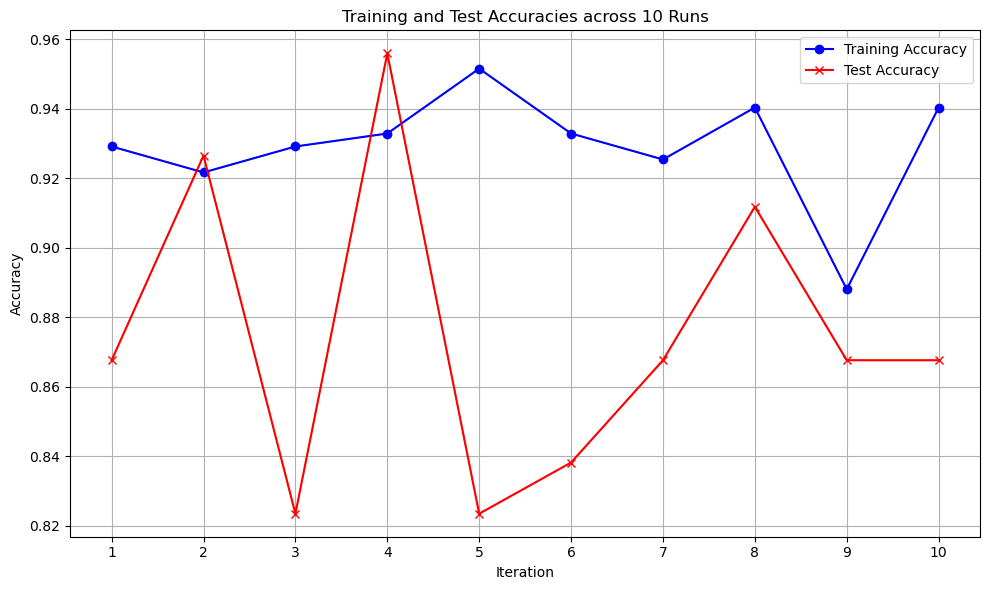

In [17]:

train_accuracies = []
test_accuracies = []

# Repeat the process 10 times
for i in range(10):
    # Split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=i)

    # Define the kernel
    kernel = 1.0 * RBF(1)

    # Create Gaussian Process Classifier model
    model = GaussianProcessClassifier(kernel=kernel, random_state=0)

    # Fit the model
    model.fit(X_train, y_train)

    # Get training accuracy
    train_accuracy = model.score(X_train, y_train)
    train_accuracies.append(train_accuracy)

    # Get test accuracy
    test_accuracy = model.score(X_test, y_test)
    test_accuracies.append(test_accuracy)

    print(f"Iteration {i+1}: Training Accuracy = {train_accuracy:.4f}, Test Accuracy = {test_accuracy:.4f}")

# Calculate the average and standard deviation of training and testing accuracies
average_train_accuracy = np.mean(train_accuracies)
std_train_accuracy = np.std(train_accuracies)
average_test_accuracy = np.mean(test_accuracies)
std_test_accuracy = np.std(test_accuracies)

print(f"\nAverage Training Accuracy: {average_train_accuracy:.4f}")
print(f"Training Accuracy Standard Deviation: {std_train_accuracy:.4f}")
print(f"Average Test Accuracy: {average_test_accuracy:.4f}")
print(f"Test Accuracy Standard Deviation: {std_test_accuracy:.4f}")


# Plotting the results
plt.figure(figsize=(10, 6))

# Plotting the training accuracy
plt.plot(range(1, 11), train_accuracies, marker='o', color='blue', label='Training Accuracy')

# Plotting the test accuracy
plt.plot(range(1, 11), test_accuracies, marker='x', color='red', label='Test Accuracy')

# Connecting scatter points with lines
plt.plot(range(1, 11), train_accuracies, color='blue', linewidth=1, linestyle='-', alpha=0.5)
plt.plot(range(1, 11), test_accuracies, color='red', linewidth=1, linestyle='-', alpha=0.5)

# Adding labels and title
plt.title('Training and Test Accuracies across 10 Runs')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.xticks(range(1, 11))
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [18]:
# working on whole dagtaset to get final model
kernel = 1.0 * RBF(1)
model = GaussianProcessClassifier(kernel=kernel,
        random_state=0).fit(X, y)

model.score(X, y)

0.9345238095238095

In [19]:
# Save the model to a file
with open('../../data/20240701/model/GPC_model_20240713.pkl', 'wb') as file:
    pickle.dump(model, file)

In [15]:
# Load the model from the file
with open('../../data/20240701/model/GPC_model_20240713.pkl', 'rb') as file:
    model = pickle.load(file)

In [16]:
model.kernel_.get_params()

{'k1': 3.29**2,
 'k2': RBF(length_scale=0.813),
 'k1__constant_value': 10.798057753693431,
 'k1__constant_value_bounds': (1e-05, 100000.0),
 'k2__length_scale': 0.8131575818404257,
 'k2__length_scale_bounds': (1e-05, 100000.0)}

/var/folders/wn/w203521n4h18b4_rz5rd9tw80000gp/T/ipykernel_87569/1654667042.py:22: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(x='group', y='sum', data=vesicles, palette='Set2', marker='o', size=8, edgecolor='black', linewidth=0.5, alpha=0.7)
/Users/haoliu/anaconda3/envs/ActiveLearning/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/haoliu/anaconda3/envs/ActiveLearning/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/var/folders/wn/w203521n4h18b4_rz5rd9tw80000gp/T/ipykernel_87569/1654667042.py:25: FutureWarning: Passing `palette` witho

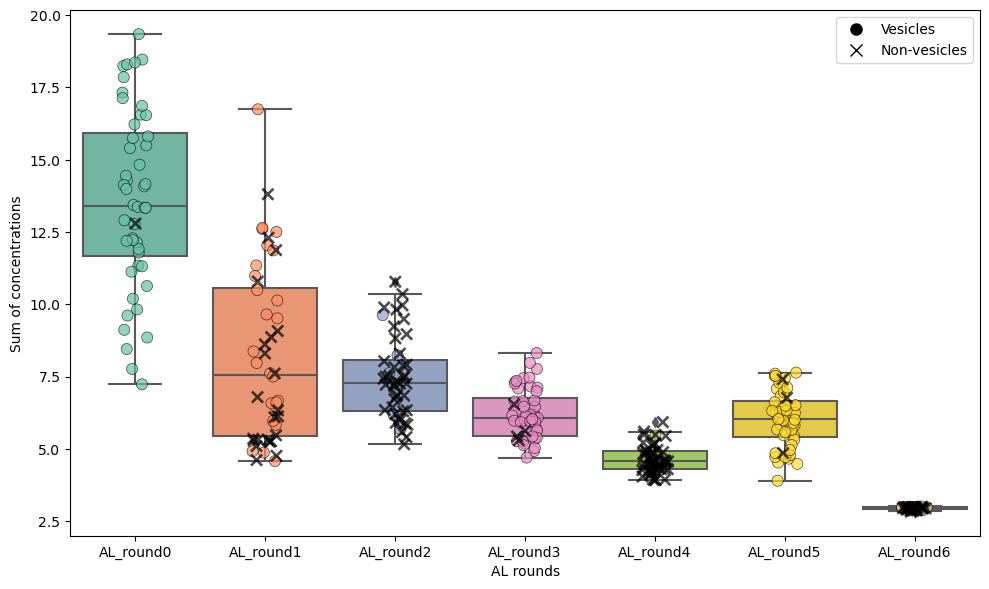

In [24]:
# See it on original scale
# Apply expm1 to the first 7 columns
df_input_update.iloc[:, :7] = df_input_update.iloc[:, :7].apply(np.expm1)

df_input_update['sum'] = df_input_update.iloc[:, :7].sum(axis=1)

# Split the DataFrame into 6 groups of 48 rows and add a 'group' column
group_labels = np.repeat([1, 2, 3, 4, 5, 6, 7], 48)
df_input_update['group'] = group_labels[:len(df_input_update)]

# Separate data for vesicles and non-vesicles
vesicles = df_input_update[df_input_update['num_vesicles'] == 1]
non_vesicles = df_input_update[df_input_update['num_vesicles'] == 0]

# Initialize the figure
plt.figure(figsize=(10, 6))

# Create a box plot with Seaborn
sns.boxplot(x='group', y='sum', data=df_input_update, palette='Set2', width=0.8)

# Overlay a scatter plot for vesicles
sns.stripplot(x='group', y='sum', data=vesicles, palette='Set2', marker='o', size=8, edgecolor='black', linewidth=0.5, alpha=0.7)

# Overlay a scatter plot for non-vesicles
sns.stripplot(x='group', y='sum', data=non_vesicles, palette='Set2', marker='x', size=8, edgecolor='black', linewidth=1.9, alpha=0.7)

# Add labels and title
plt.xlabel('AL rounds')
plt.ylabel('Sum of concentrations')
plt.xticks(ticks=[0, 1, 2, 3, 4, 5, 6], labels=['AL_round0', 'AL_round1', 'AL_round2', 'AL_round3', 'AL_round4', 'AL_round5', 'AL_round6'])

# Add custom legend
import matplotlib.lines as mlines

vesicles_legend = mlines.Line2D([], [], color='black', marker='o', linestyle='None', markersize=8, label='Vesicles')
non_vesicles_legend = mlines.Line2D([], [], color='black', marker='x', linestyle='None', markersize=8, label='Non-vesicles')

plt.legend(handles=[vesicles_legend, non_vesicles_legend])

# Show the plot
plt.tight_layout()
plt.show()

In [163]:
# Get the "Set2" color palette
palette = sns.color_palette("Set2")

# Convert the palette to an array of RGB values
palette_array = np.array(palette)
palette_array

array([[0.4       , 0.76078431, 0.64705882],
       [0.98823529, 0.55294118, 0.38431373],
       [0.55294118, 0.62745098, 0.79607843],
       [0.90588235, 0.54117647, 0.76470588],
       [0.65098039, 0.84705882, 0.32941176],
       [1.        , 0.85098039, 0.18431373],
       [0.89803922, 0.76862745, 0.58039216],
       [0.70196078, 0.70196078, 0.70196078]])

In [164]:
color_7th = palette[6]
color_7th

(0.8980392156862745, 0.7686274509803922, 0.5803921568627451)

/Users/haoliu/anaconda3/envs/ActiveLearning/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/haoliu/anaconda3/envs/ActiveLearning/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/haoliu/anaconda3/envs/ActiveLearning/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/haoliu/anaconda3/envs/ActiveLearning/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning

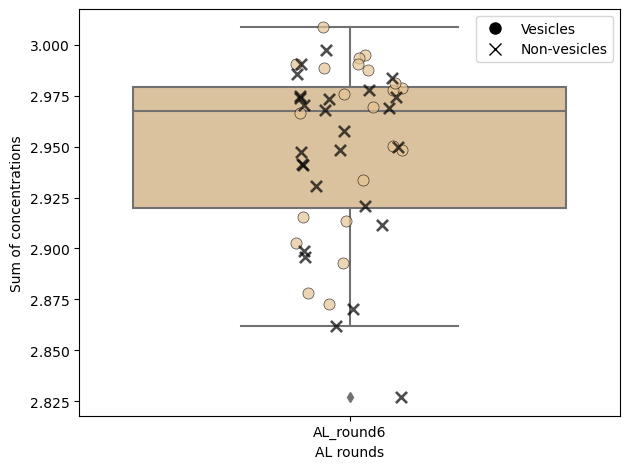

In [30]:
# Take a closer look at this round plot

df_input_update.iloc[:, :7] = df_input_update.iloc[:, :7].apply(np.expm1)

df_input_update['sum'] = df_input_update.iloc[:, :7].sum(axis=1)

# Split the DataFrame into 6 groups of 48 rows and add a 'group' column
group_labels = np.repeat([1, 2, 3, 4, 5, 6, 7], 48)
df_input_update['group'] = group_labels[:len(df_input_update)]

# Filter the DataFrame to include only the last round (group 7)
last_round_df = df_input_update[df_input_update['group'] == 7]

# Separate data for vesicles and non-vesicles in the last round
vesicles_last_round = last_round_df[last_round_df['num_vesicles'] == 1]
non_vesicles_last_round = last_round_df[last_round_df['num_vesicles'] == 0]

# Initialize the figure
# plt.figure(figsize=(10, 6))

# Create a box plot with Seaborn for the last round
sns.boxplot(x='group', y='sum', data=last_round_df, color=color_7th, width=0.8)

# Overlay a scatter plot for vesicles in the last round
sns.stripplot(x='group', y='sum', data=vesicles_last_round, color=color_7th, marker='o', size=8, edgecolor='black', linewidth=0.5, alpha=0.7)

# Overlay a scatter plot for non-vesicles in the last round
sns.stripplot(x='group', y='sum', data=non_vesicles_last_round, color=color_7th, marker='x', size=8, edgecolor='black', linewidth=1.9, alpha=0.7)

# Add labels and title
plt.xlabel('AL rounds')
plt.ylabel('Sum of concentrations')
plt.xticks(ticks=[0], labels=['AL_round6'])  # Only label for AL_round6

# Add custom legend
import matplotlib.lines as mlines

vesicles_legend = mlines.Line2D([], [], color='black', marker='o', linestyle='None', markersize=8, label='Vesicles')
non_vesicles_legend = mlines.Line2D([], [], color='black', marker='x', linestyle='None', markersize=8, label='Non-vesicles')

# plt.legend(handles=[vesicles_legend, non_vesicles_legend])

# Show the plot
plt.tight_layout()

plt.show()

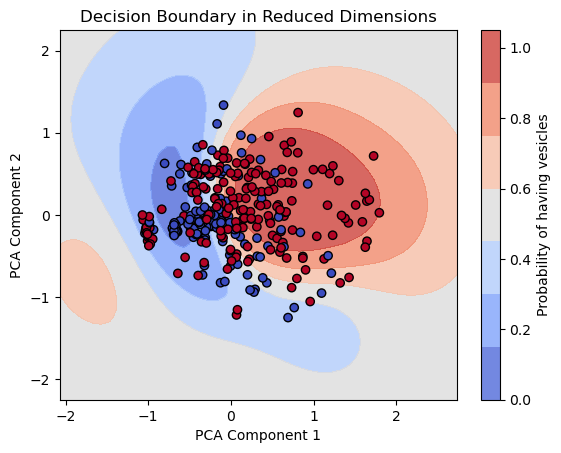

In [31]:
# Reduce dimensions using PCA for visualization
pca = PCA(n_components=2)
X_reduced = pca.fit_transform(X)

# Create a mesh grid for plotting
x_min, x_max = X_reduced[:, 0].min() - 1, X_reduced[:, 0].max() + 1
y_min, y_max = X_reduced[:, 1].min() - 1, X_reduced[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

# Predict on the mesh grid
# Z = model.predict(pca.inverse_transform(np.c_[xx.ravel(), yy.ravel()]))
# Z = Z.reshape(xx.shape)
grid_points = np.c_[xx.ravel(), yy.ravel()]
grid_points_original_space = pca.inverse_transform(grid_points)
probs = model.predict_proba(grid_points_original_space)
probs_class_1 = probs[:, 1].reshape(xx.shape)

# Plot decision boundary and data points
contour = plt.contourf(xx, yy, probs_class_1, alpha=0.8, cmap=plt.cm.coolwarm)
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=y, edgecolors='k', marker='o', cmap=plt.cm.coolwarm)
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('Decision Boundary in Reduced Dimensions')
# Add color bar
cbar = plt.colorbar(contour)
cbar.set_label('Probability of having vesicles')
cbar.set_ticks([0, 0.2, 0.4, 0.6, 0.8, 1])
plt.show()

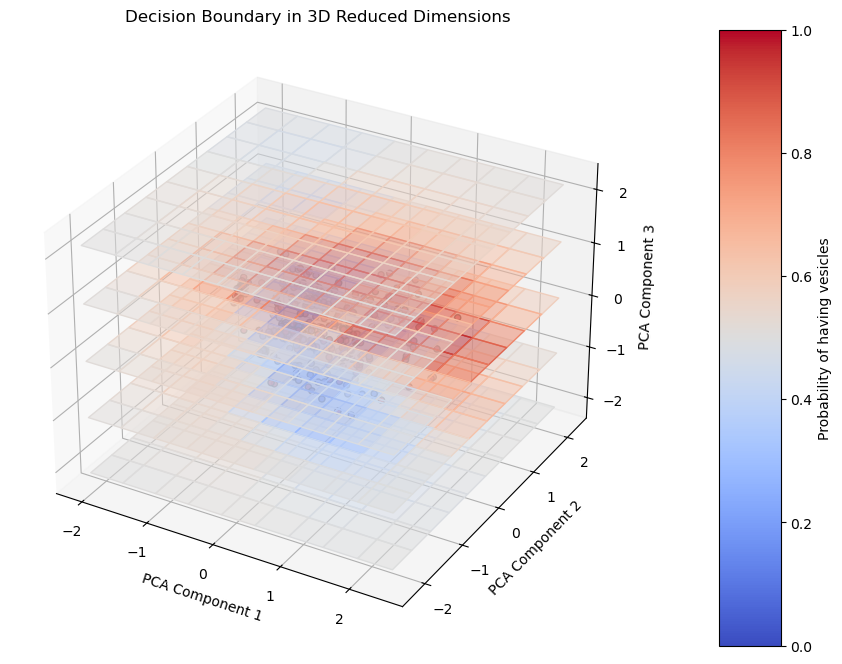

In [32]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from matplotlib.colors import Normalize

# Assuming X and y are already defined
# Fit PCA
pca = PCA(n_components=3)
X_reduced = pca.fit_transform(X)

# Create a mesh grid for plotting
x_min, x_max = X_reduced[:, 0].min() - 1, X_reduced[:, 0].max() + 1
y_min, y_max = X_reduced[:, 1].min() - 1, X_reduced[:, 1].max() + 1
z_min, z_max = X_reduced[:, 2].min() - 1, X_reduced[:, 2].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.5),
                     np.arange(y_min, y_max, 0.5))

# Create the figure and 3D axis
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot slices of the decision boundary at different z levels
z_levels = np.linspace(z_min, z_max, num=5)
norm = Normalize(vmin=0, vmax=1)

for z in z_levels:
    zz = np.full_like(xx, z)
    grid_points = np.c_[xx.ravel(), yy.ravel(), zz.ravel()]
    grid_points_original_space = pca.inverse_transform(grid_points)
    probs = model.predict_proba(grid_points_original_space)
    probs_class_1 = probs[:, 1].reshape(xx.shape)
    
    # Plot the surface for this z slice
    surf = ax.plot_surface(xx, yy, zz, facecolors=plt.cm.coolwarm(norm(probs_class_1)), alpha=0.5, shade=False)
    
# Plot the data points
sc = ax.scatter(X_reduced[:, 0], X_reduced[:, 1], X_reduced[:, 2], c=y, edgecolors='k', marker='o', cmap=plt.cm.coolwarm)

# Add labels
ax.set_xlabel('PCA Component 1')
ax.set_ylabel('PCA Component 2')
ax.set_zlabel('PCA Component 3')
plt.title('Decision Boundary in 3D Reduced Dimensions')

# Add color bar
mappable = plt.cm.ScalarMappable(cmap=plt.cm.coolwarm, norm=norm)
mappable.set_array([])
cbar = fig.colorbar(mappable, ax=ax, pad=0.1, aspect=10)
cbar.set_label('Probability of having vesicles')
cbar.set_ticks([0, 0.2, 0.4, 0.6, 0.8, 1])

plt.show()


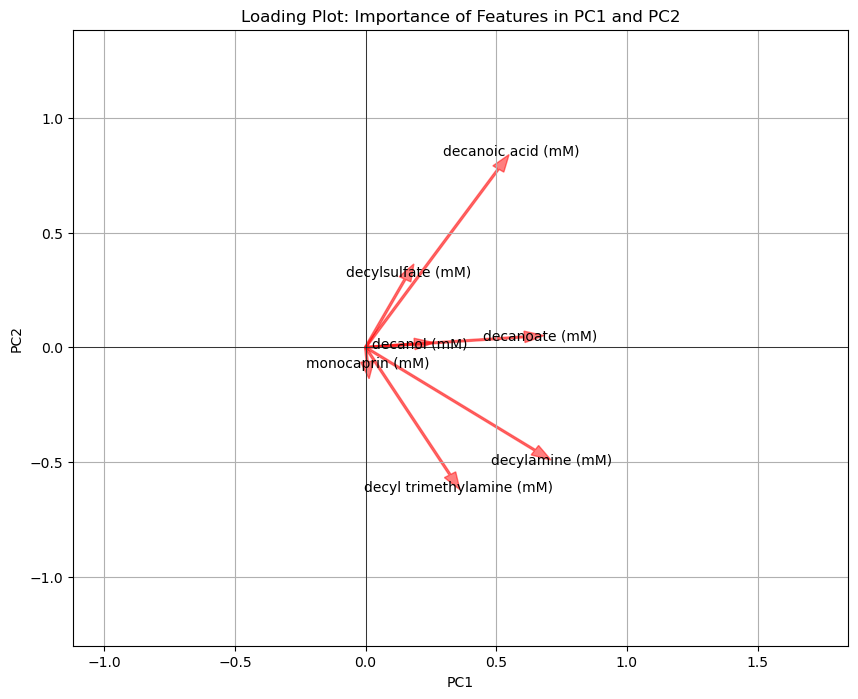

In [33]:
# Get the loadings for the first two PCs
loadings = pca.components_[:2, :]

# Feature names
feature_names = ['decanoic acid (mM)', 'decanoate (mM)',
                 'decylamine (mM)', 'decyl trimethylamine (mM)',
                 'decylsulfate (mM)', 'decanol (mM)',
                 'monocaprin (mM)']

# Create a DataFrame for better visualization
loadings_df = pd.DataFrame(loadings.T, columns=['PC1', 'PC2'], index=feature_names)

# Plot loadings with arrows
plt.figure(figsize=(10, 8))
plt.title('Loading Plot: Importance of Features in PC1 and PC2')

# Scale factor for the arrows to make them visually appealing
scale_factor = 1.1

for feature in loadings_df.index:
    plt.arrow(0, 0, loadings_df.loc[feature, 'PC1'] * scale_factor, loadings_df.loc[feature, 'PC2'] * scale_factor,
              color='r', alpha=0.5, width=0.008, head_width=0.05)
    plt.text(loadings_df.loc[feature, 'PC1'] * scale_factor * 1.1, loadings_df.loc[feature, 'PC2'] * scale_factor * 1.1,
             feature, color='black', ha='center', va='center')

# Set x and y limits based on PC1 and PC2 range
pc1_min, pc1_max = X_reduced[:, 0].min(), X_reduced[:, 0].max()
pc2_min, pc2_max = X_reduced[:, 1].min(), X_reduced[:, 1].max()
plt.xlim(pc1_min - 0.05, pc1_max + 0.05)
plt.ylim(pc2_min - 0.05, pc2_max + 0.05)

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.grid(True)
plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0, color='black', linewidth=0.5)
plt.show()

In [36]:
df_input_update_ori = df_input_update.copy()
df_input_update_ori.iloc[:,0:7] = df_input_update_ori.iloc[:,0:7].applymap(lambda x: np.expm1(x))
df_input_update_ori 

/var/folders/wn/w203521n4h18b4_rz5rd9tw80000gp/T/ipykernel_87569/1676378797.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_input_update_ori.iloc[:,0:7] = df_input_update_ori.iloc[:,0:7].applymap(lambda x: np.expm1(x))


,decanoic acid_Concentration (mM),decanoate_Concentration (mM),decylamine_Concentration (mM),decyl trimethylamine_Concentration (mM),decylsulfate_Concentration (mM),decanol_Concentration (mM),monocaprin_Concentration (mM),num_vesicles
0,0.850,1.600,2.425,3.725,4.350,0.5550,0.785,1
1,3.425,0.905,0.192,1.875,2.375,0.2310,0.113,1
2,2.200,1.025,2.650,4.975,4.250,0.1725,0.225,1
3,3.625,4.975,0.465,0.074,3.375,0.8025,0.120,1
4,2.225,3.225,4.350,1.425,1.750,1.1175,0.350,1
...,...,...,...,...,...,...,...,...
331,0.119,0.114,0.010,0.895,1.775,0.0000,0.008,0
332,0.020,0.007,0.067,1.500,1.275,0.0345,0.047,1
333,0.147,0.080,0.044,0.730,1.975,0.0135,0.019,1
334,0.014,0.029,0.097,1.000,1.650,0.0510,0.037,1


In [37]:
df_input_update_ori.to_csv('df_input_update_ori_20240713.csv', index=False)

In [29]:
df_input_update_ori = pd.read_csv('df_input_update_ori_20240713.csv')

In [30]:
# Checking compositions for each round
df1 = df_input_update_ori.iloc[48*0: 48*0+48]
df2 = df_input_update_ori.iloc[48*1: 48*1+48]
df3 = df_input_update_ori.iloc[48*2: 48*2+48]
df4 = df_input_update_ori.iloc[48*3: 48*3+48]
df5 = df_input_update_ori.iloc[48*4: 48*4+48]
df6 = df_input_update_ori.iloc[48*5: 48*5+48]
df7 = df_input_update_ori.iloc[48*6: 48*6+48]

In [51]:
# Define a fixed color map for the features
color_map = {
    ('decanoic acid_Concentration (mM)',): 'blue',
    ('decanoate_Concentration (mM)',): 'orange',
    ('decylamine_Concentration (mM)',): 'green',
    ('decyl trimethylamine_Concentration (mM)',): 'red',
    ('decylsulfate_Concentration (mM)',): 'purple',
    ('decanol_Concentration (mM)',): 'brown',
    ('monocaprin_Concentration (mM)',): 'pink'
}

# color_map = {
#     'decanoic acid_Concentration (mM)': 'blue',
#     'decanoate_Concentration (mM)': 'orange',
#     'decylamine_Concentration (mM)': 'green',
#     'decyl trimethylamine_Concentration (mM)': 'red',
#     'decylsulfate_Concentration (mM)': 'purple',
#     'decanol_Concentration (mM)': 'brown',
#     'monocaprin_Concentration (mM)': 'pink'
# }

# Function to plot horizontal bars for each sample
def plot_samples(df, title, color_map):
    num_samples = df.shape[0]
    features = df.columns

    plt.figure(figsize=(15, num_samples * 0.5))

    for i in range(num_samples):
        sample = df.iloc[i, :]
        left = 0
        for feature in features:
            plt.barh(i, sample[feature], left=left, color=color_map[feature], label=feature if i == 0 else "")
            left += sample[feature]

    plt.xlabel('Concentration (mM)')
    plt.ylabel('Sample Index')
    plt.title(title)
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.tight_layout()
    plt.show()


# Plot
# plot_samples(df1.drop('num_vesicles', axis=1), 'Sample Concentrations - AL6', color_map)


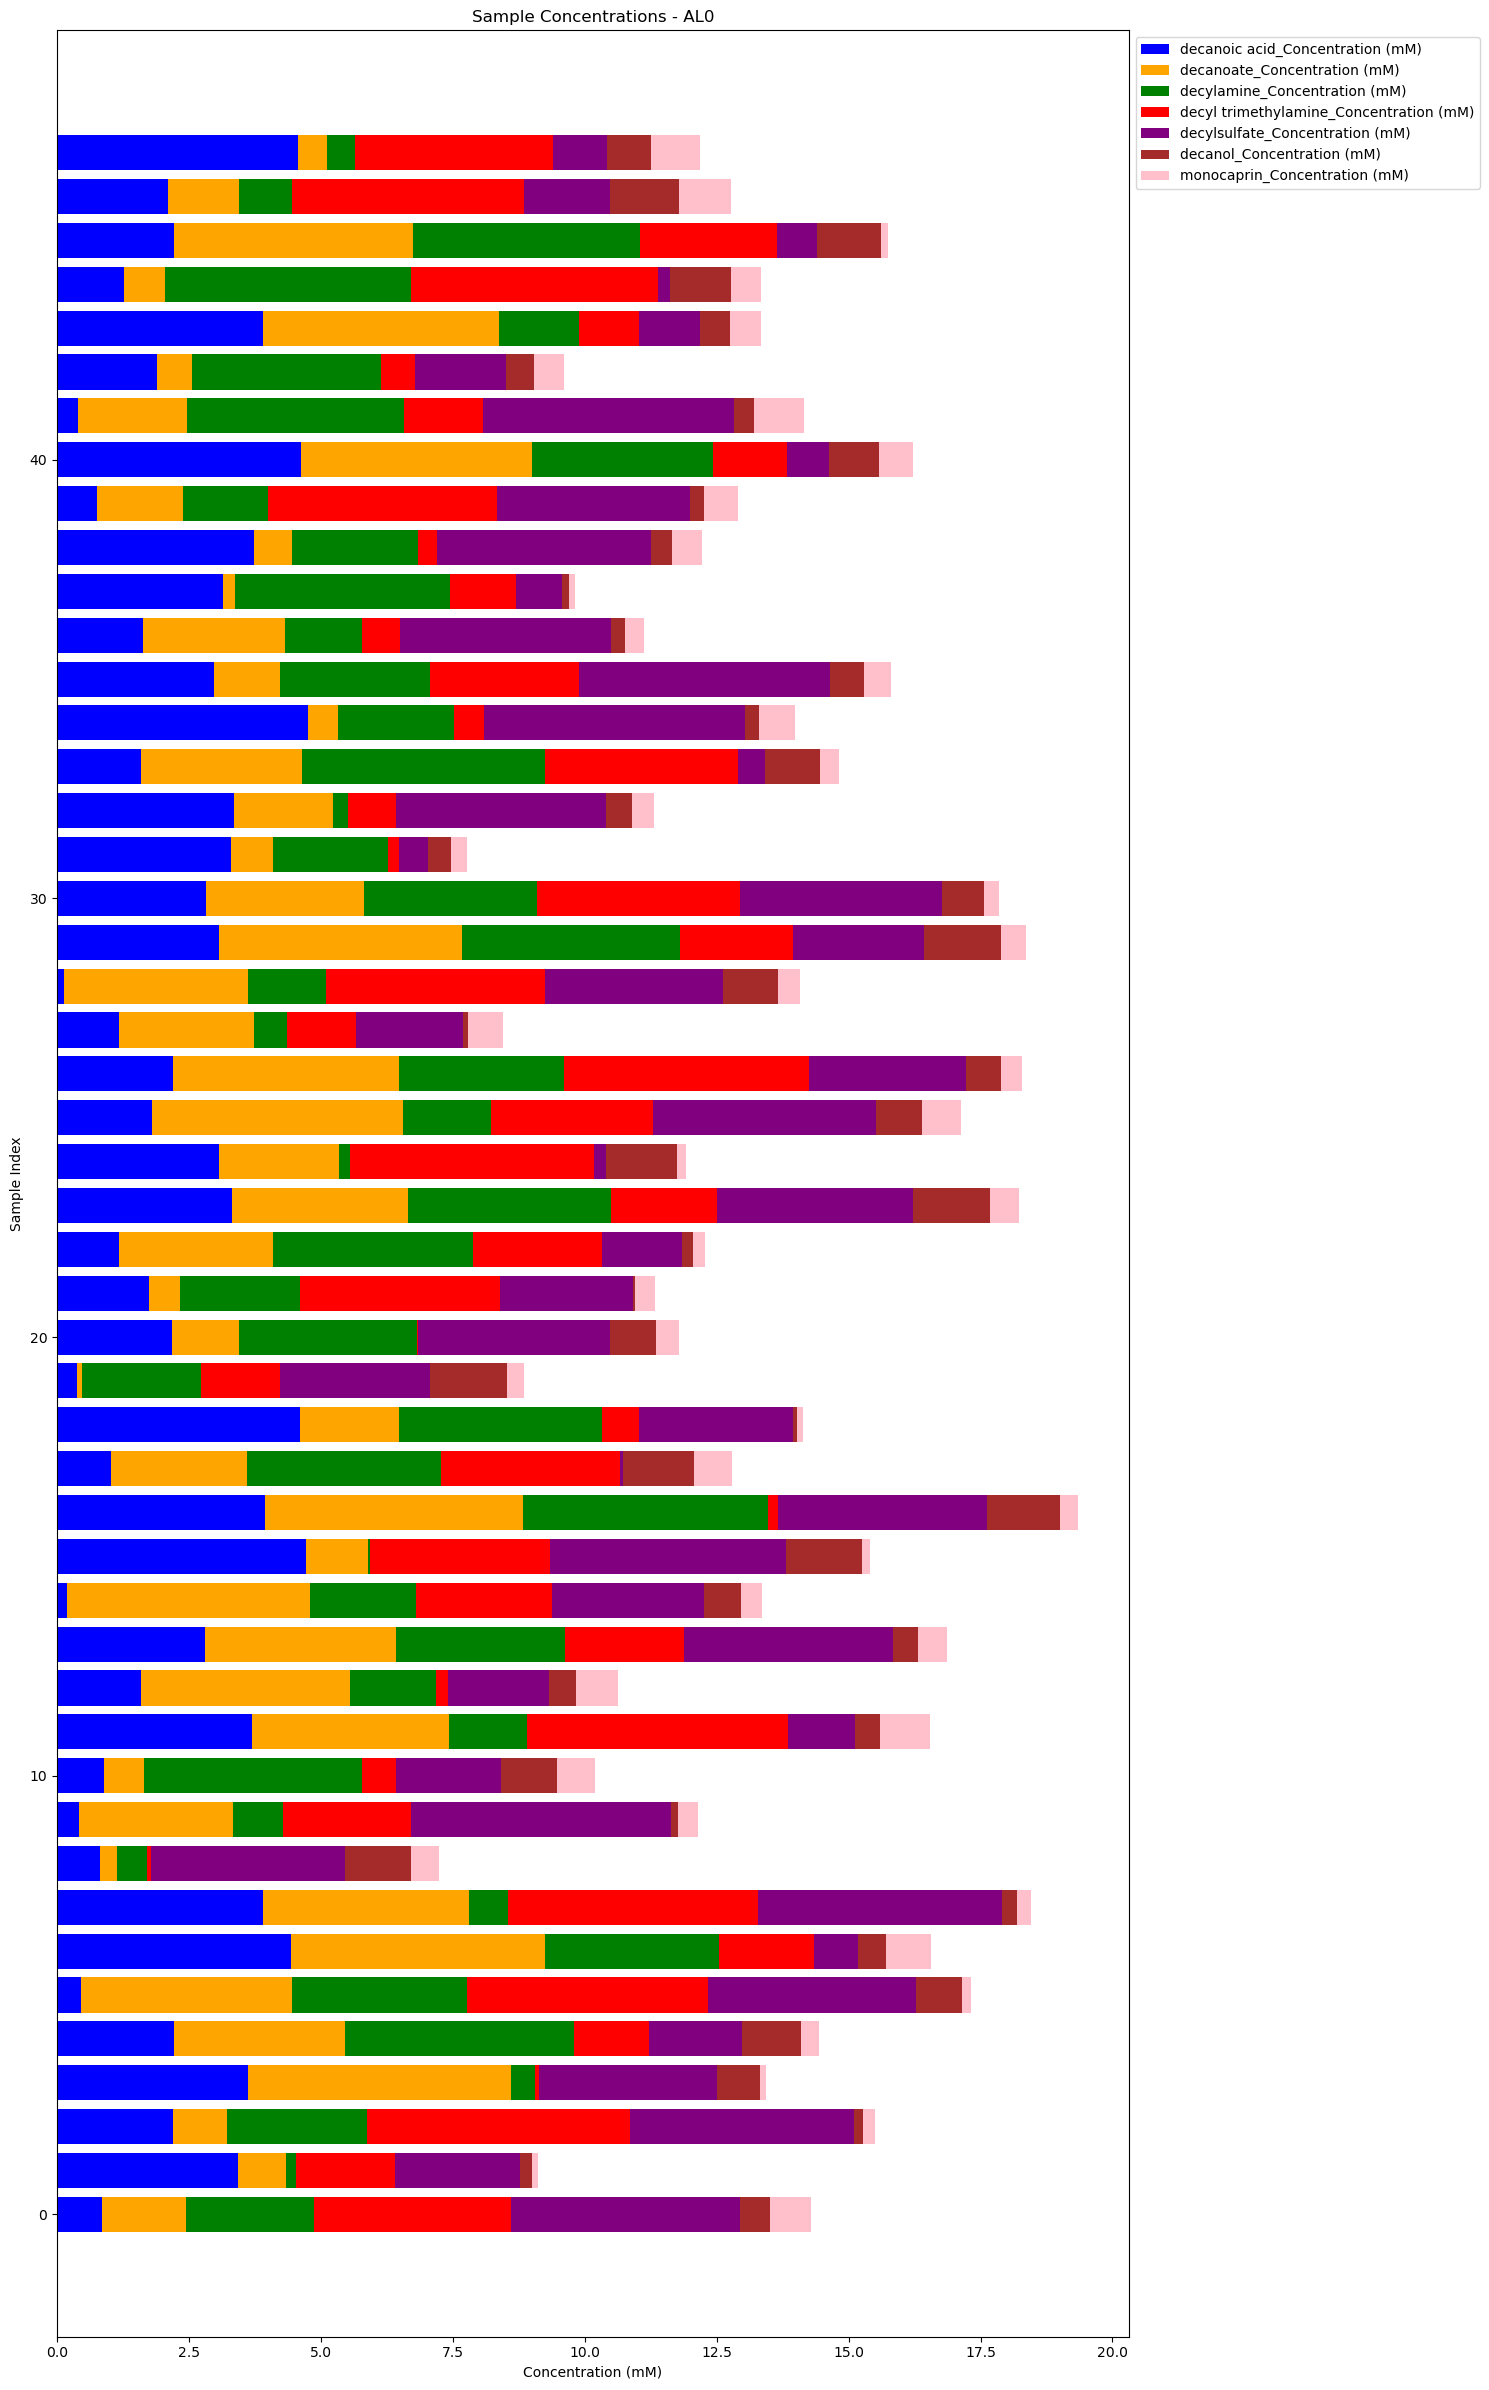

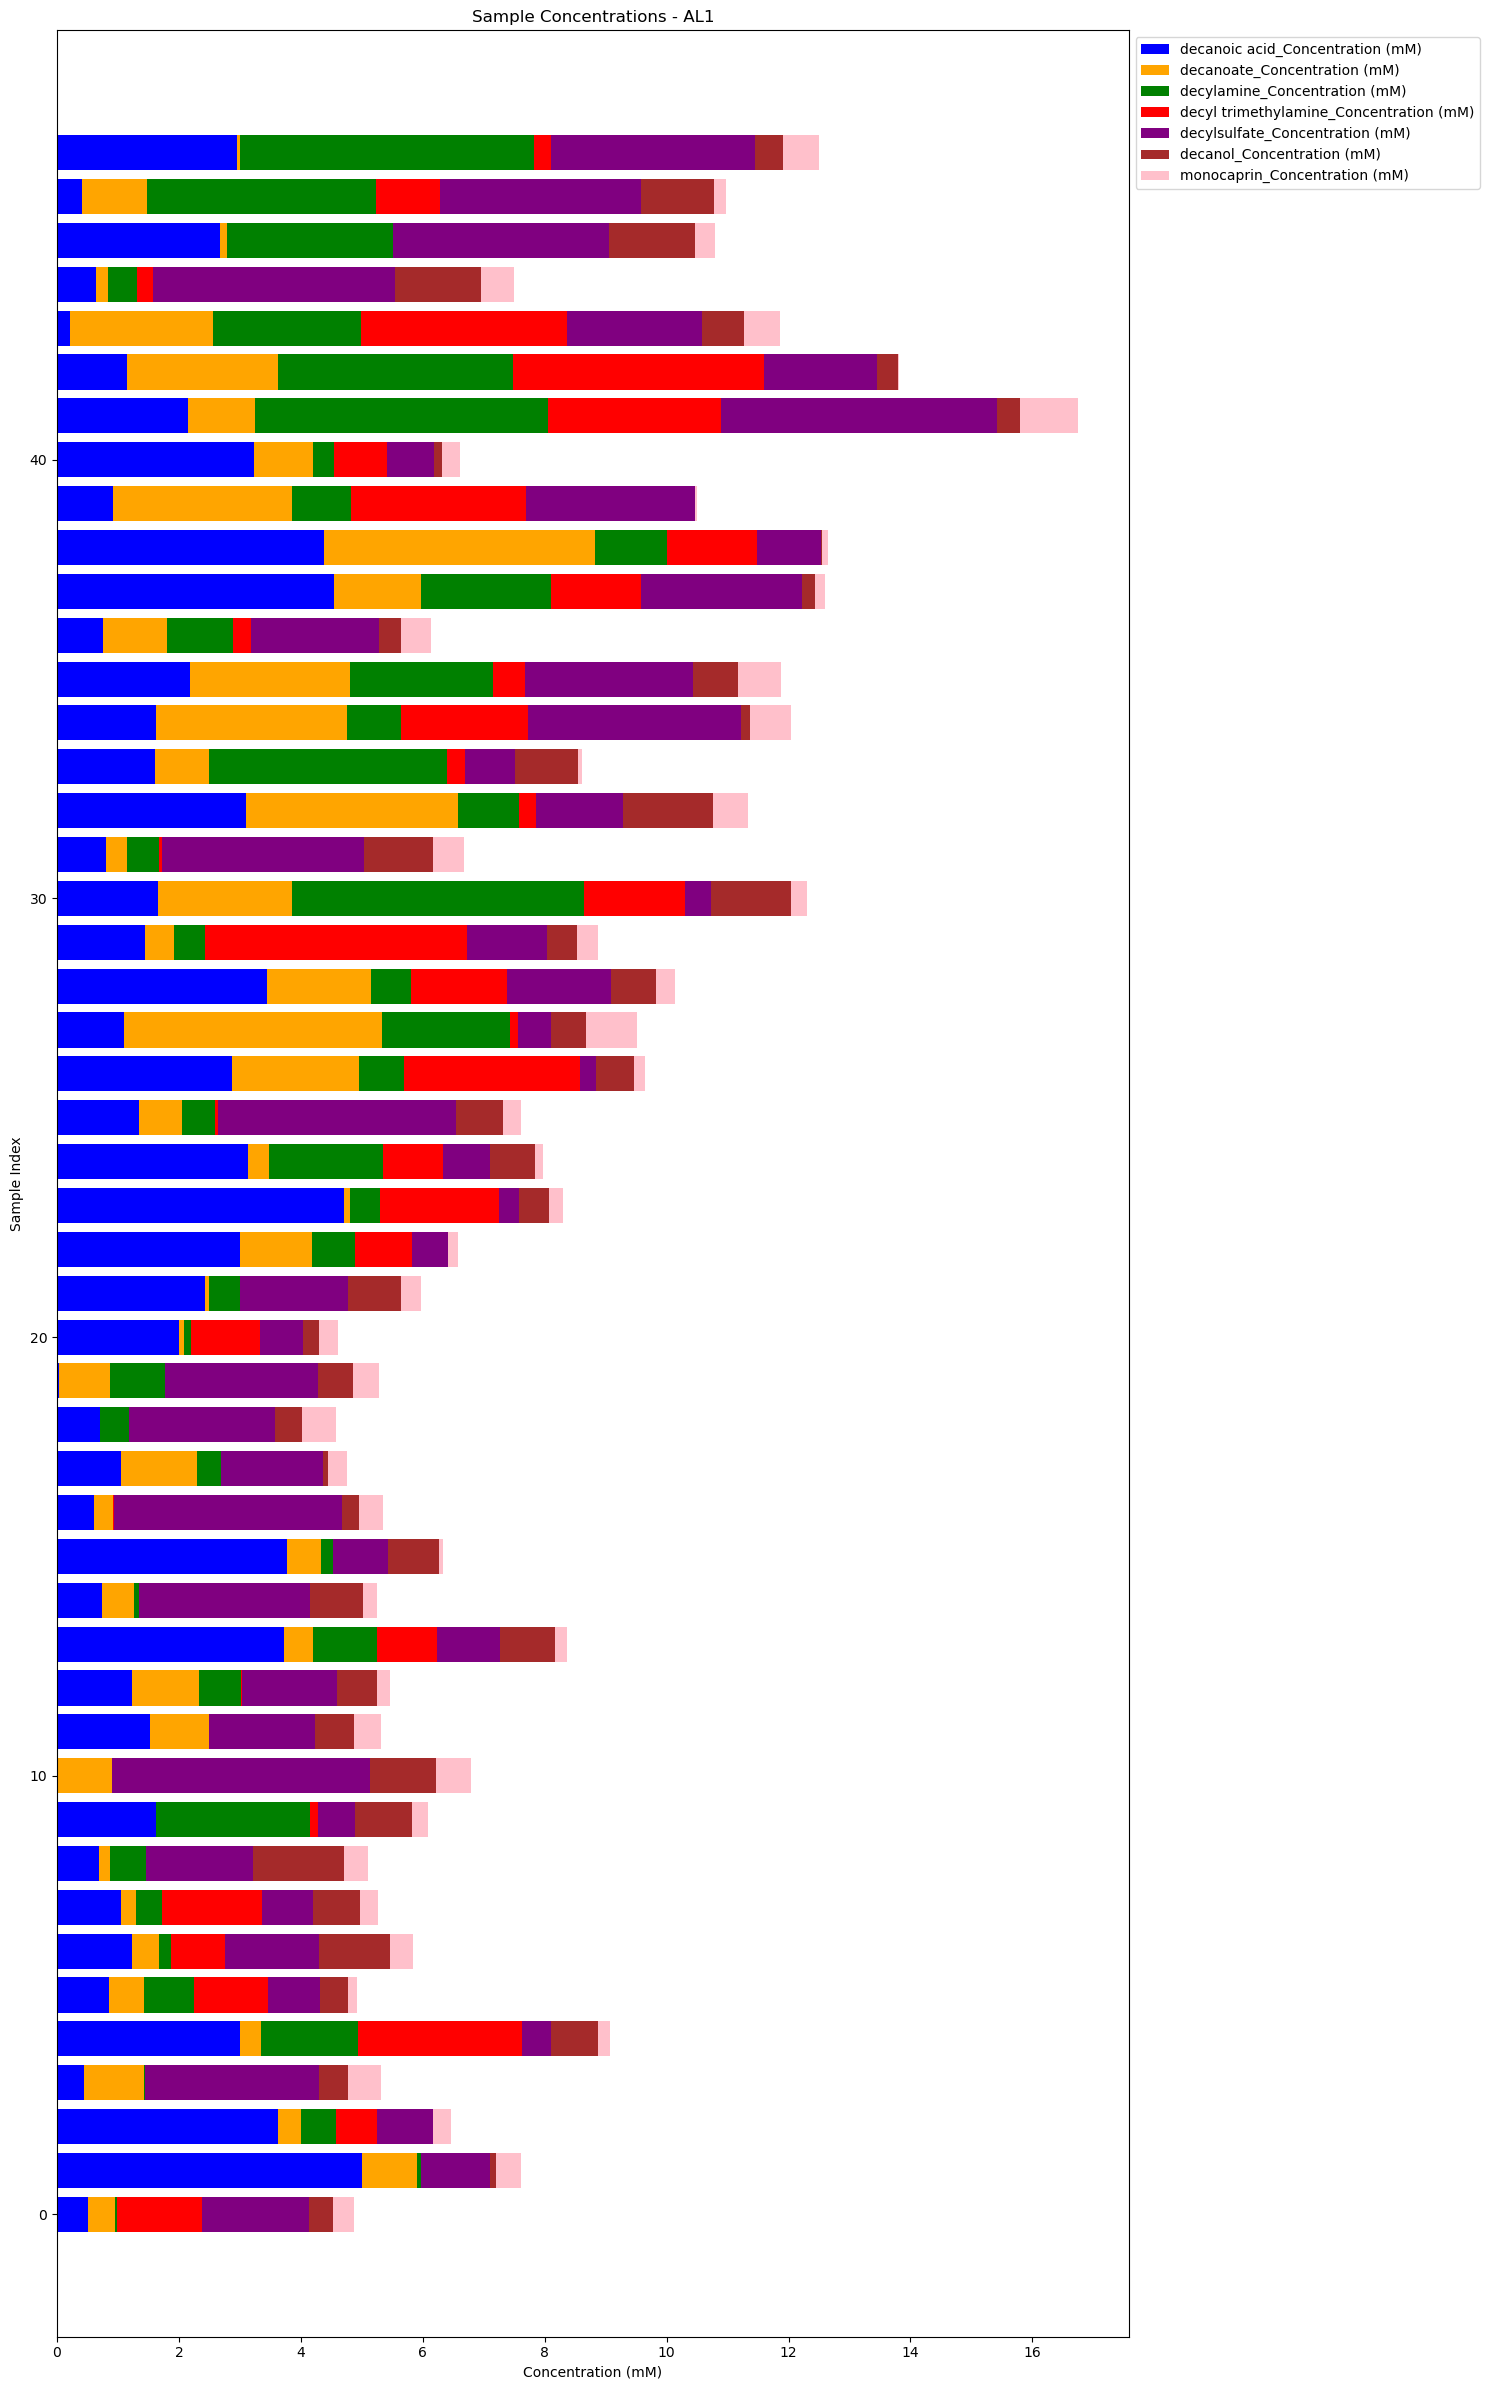

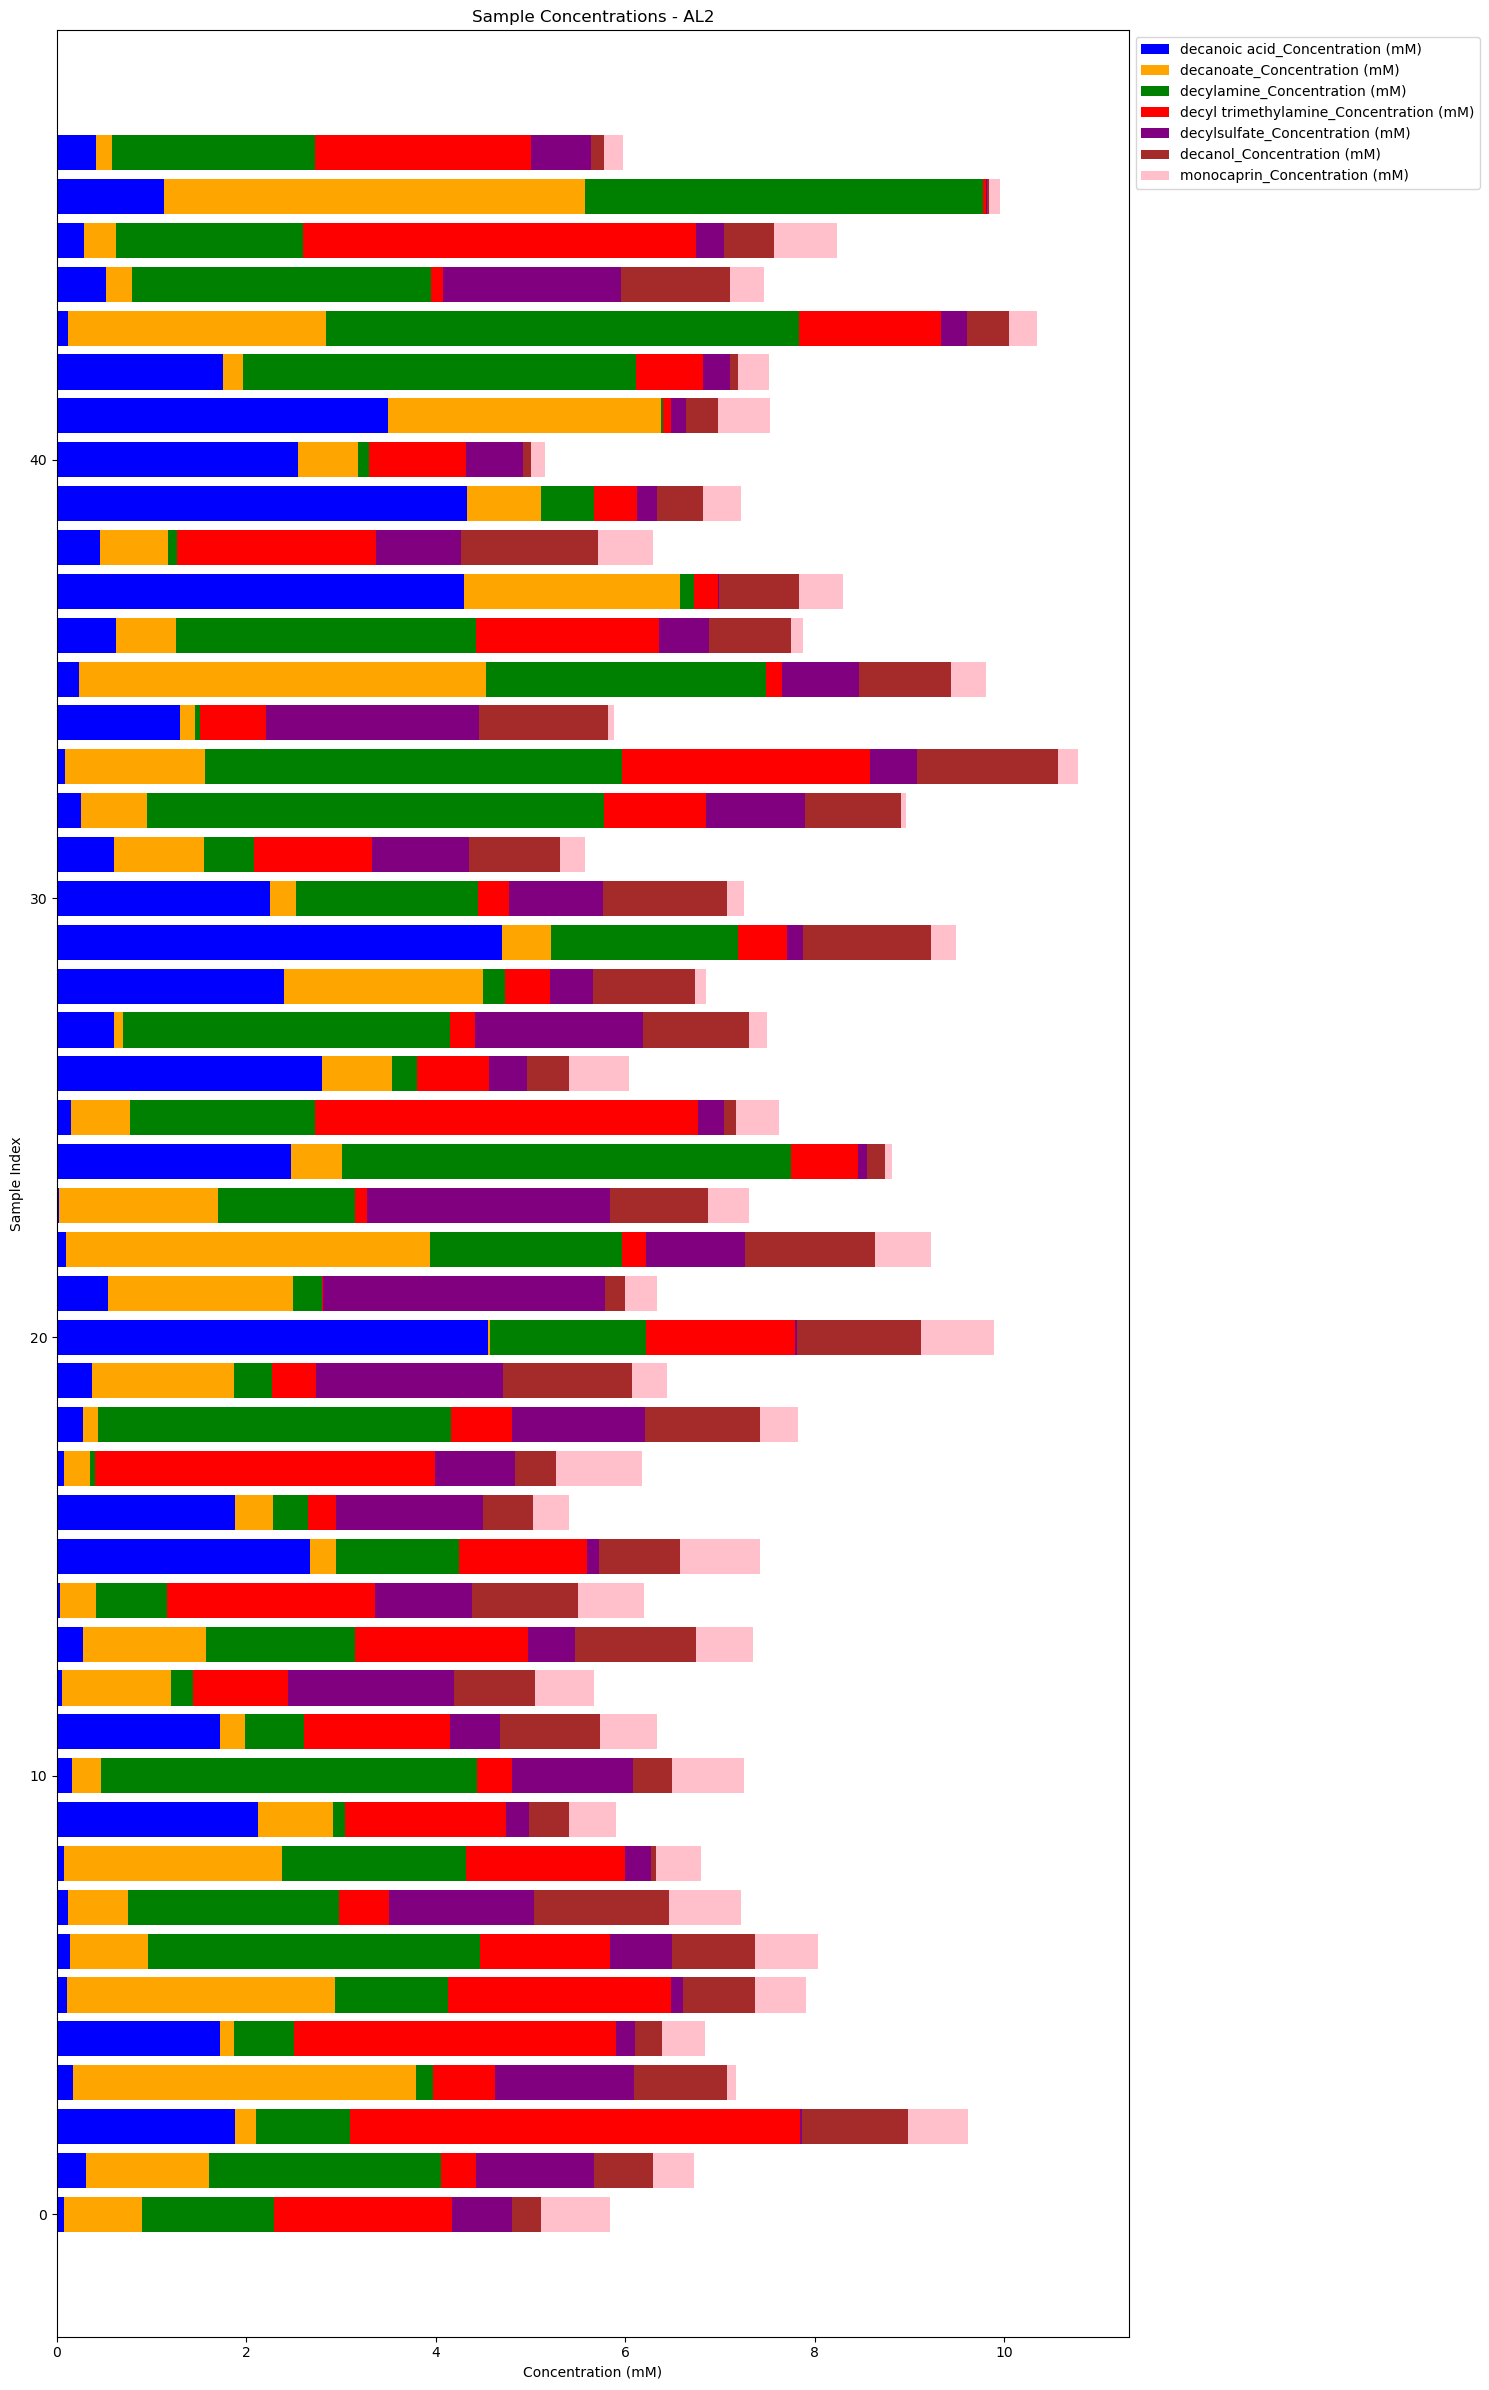

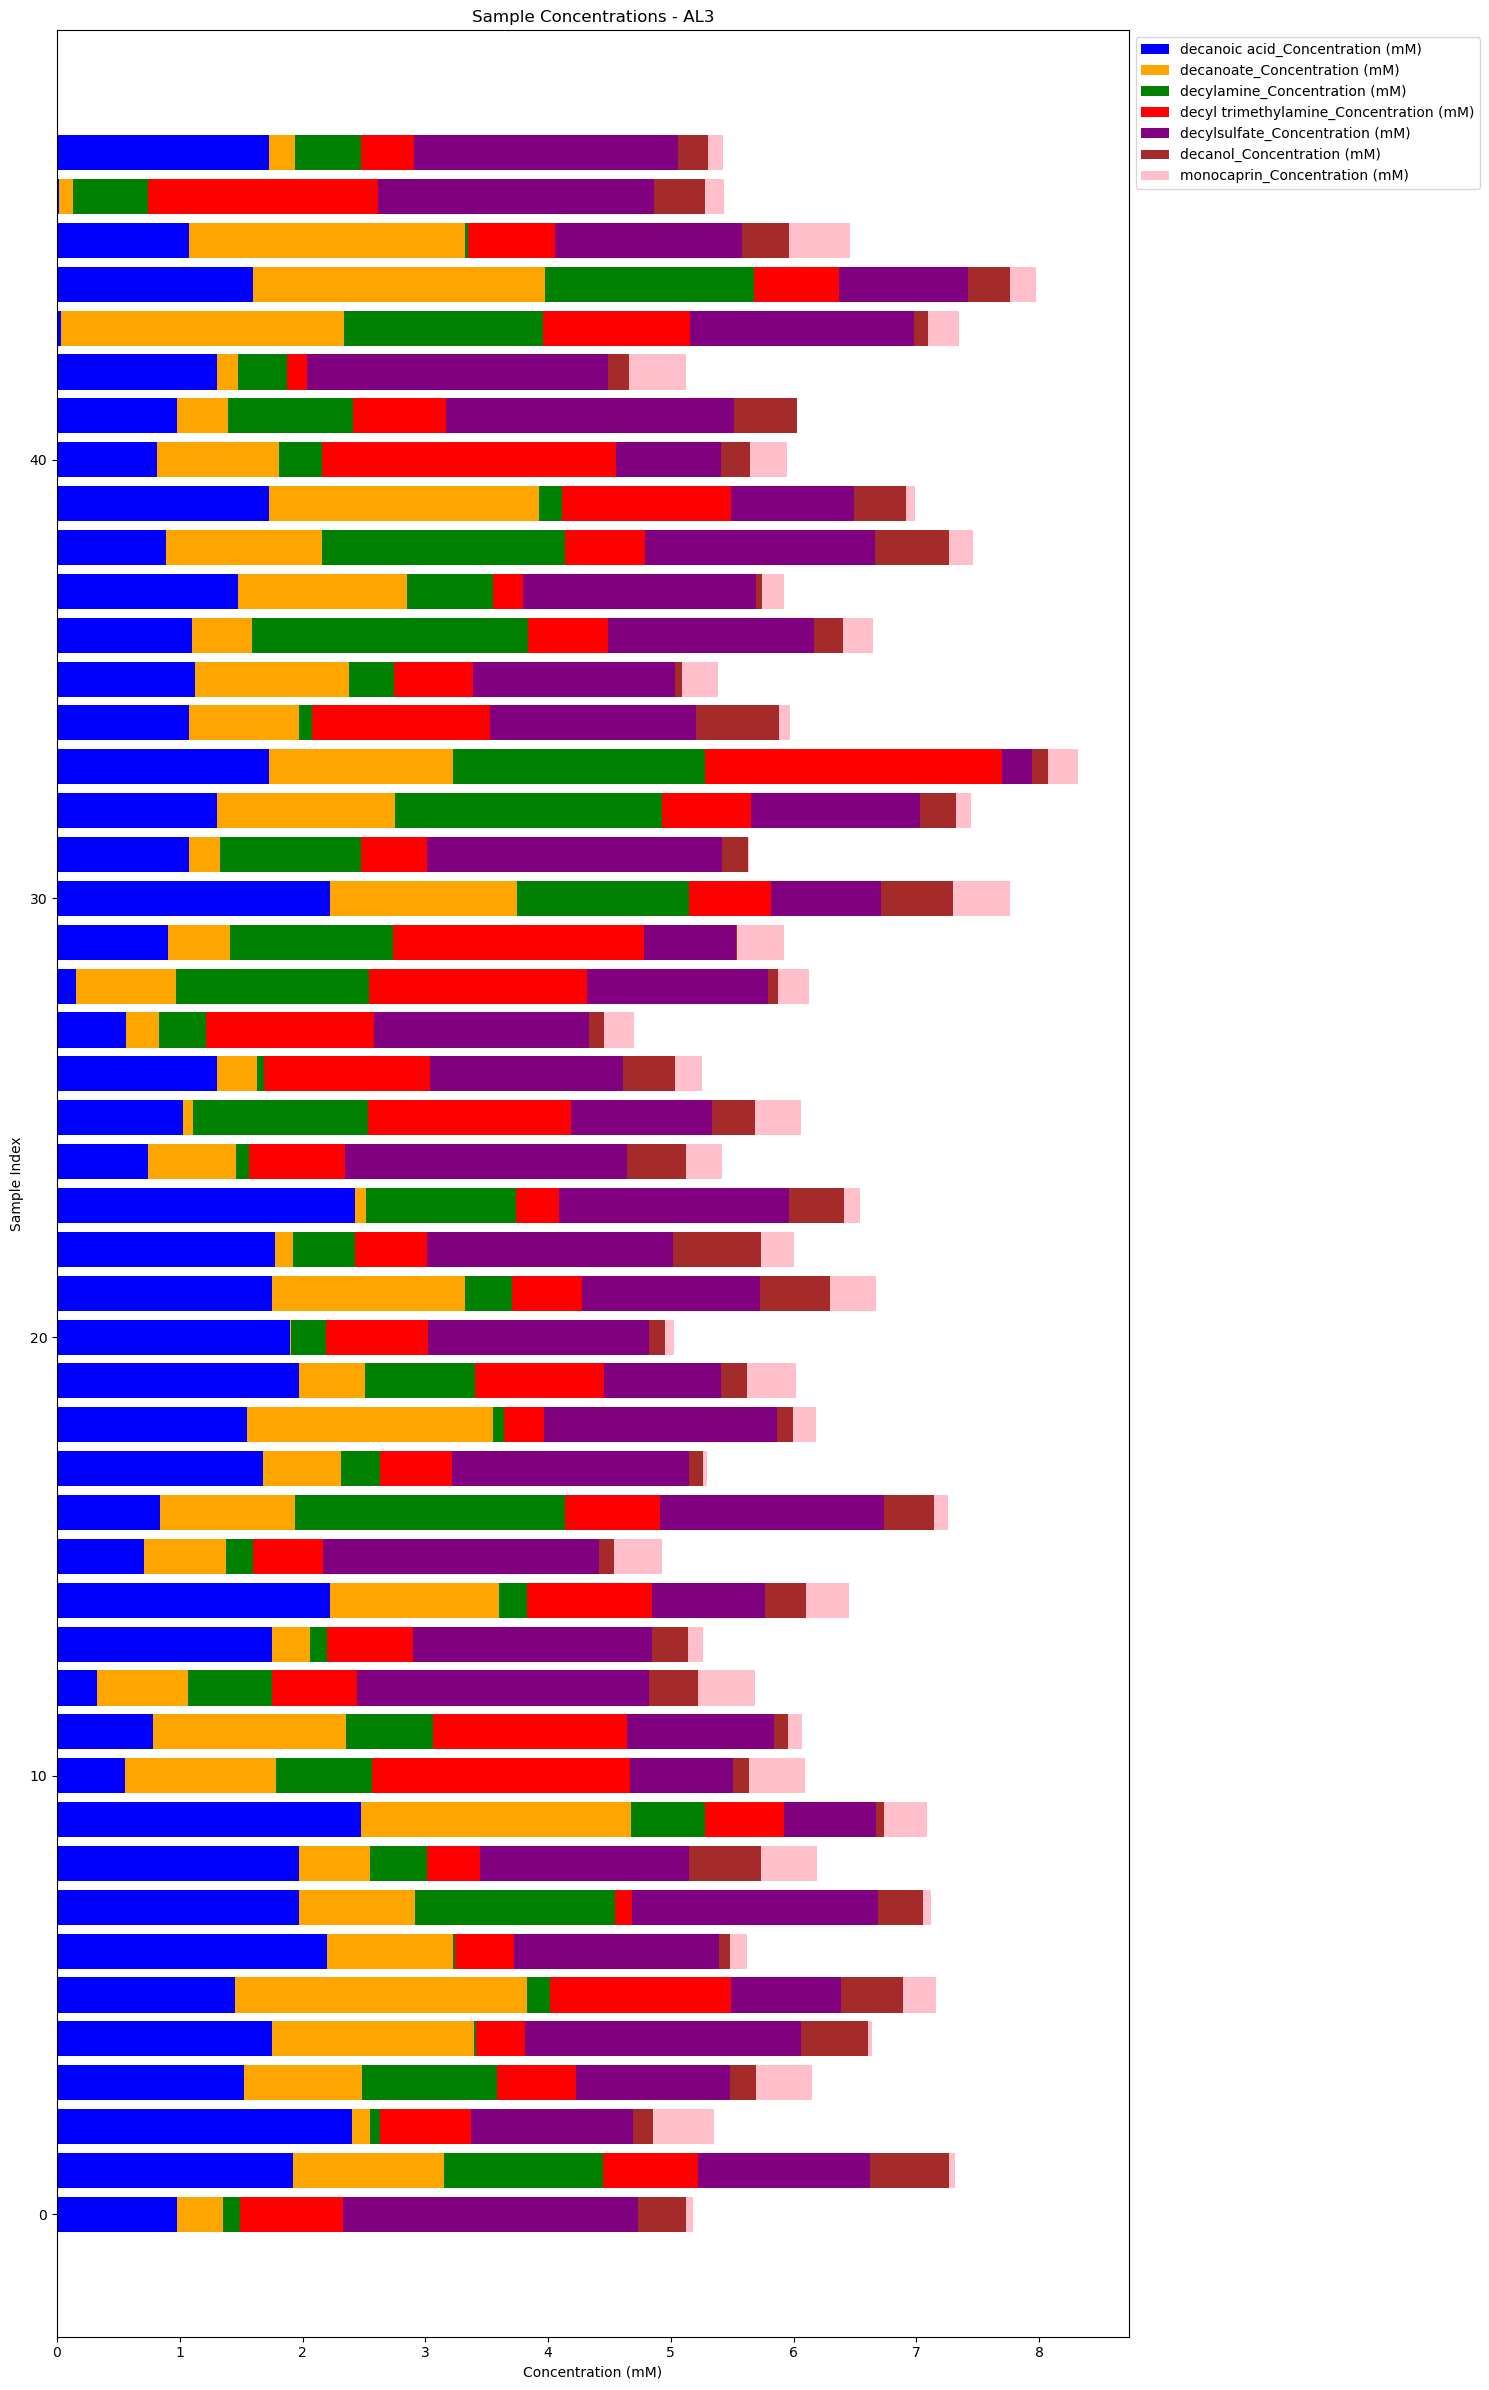

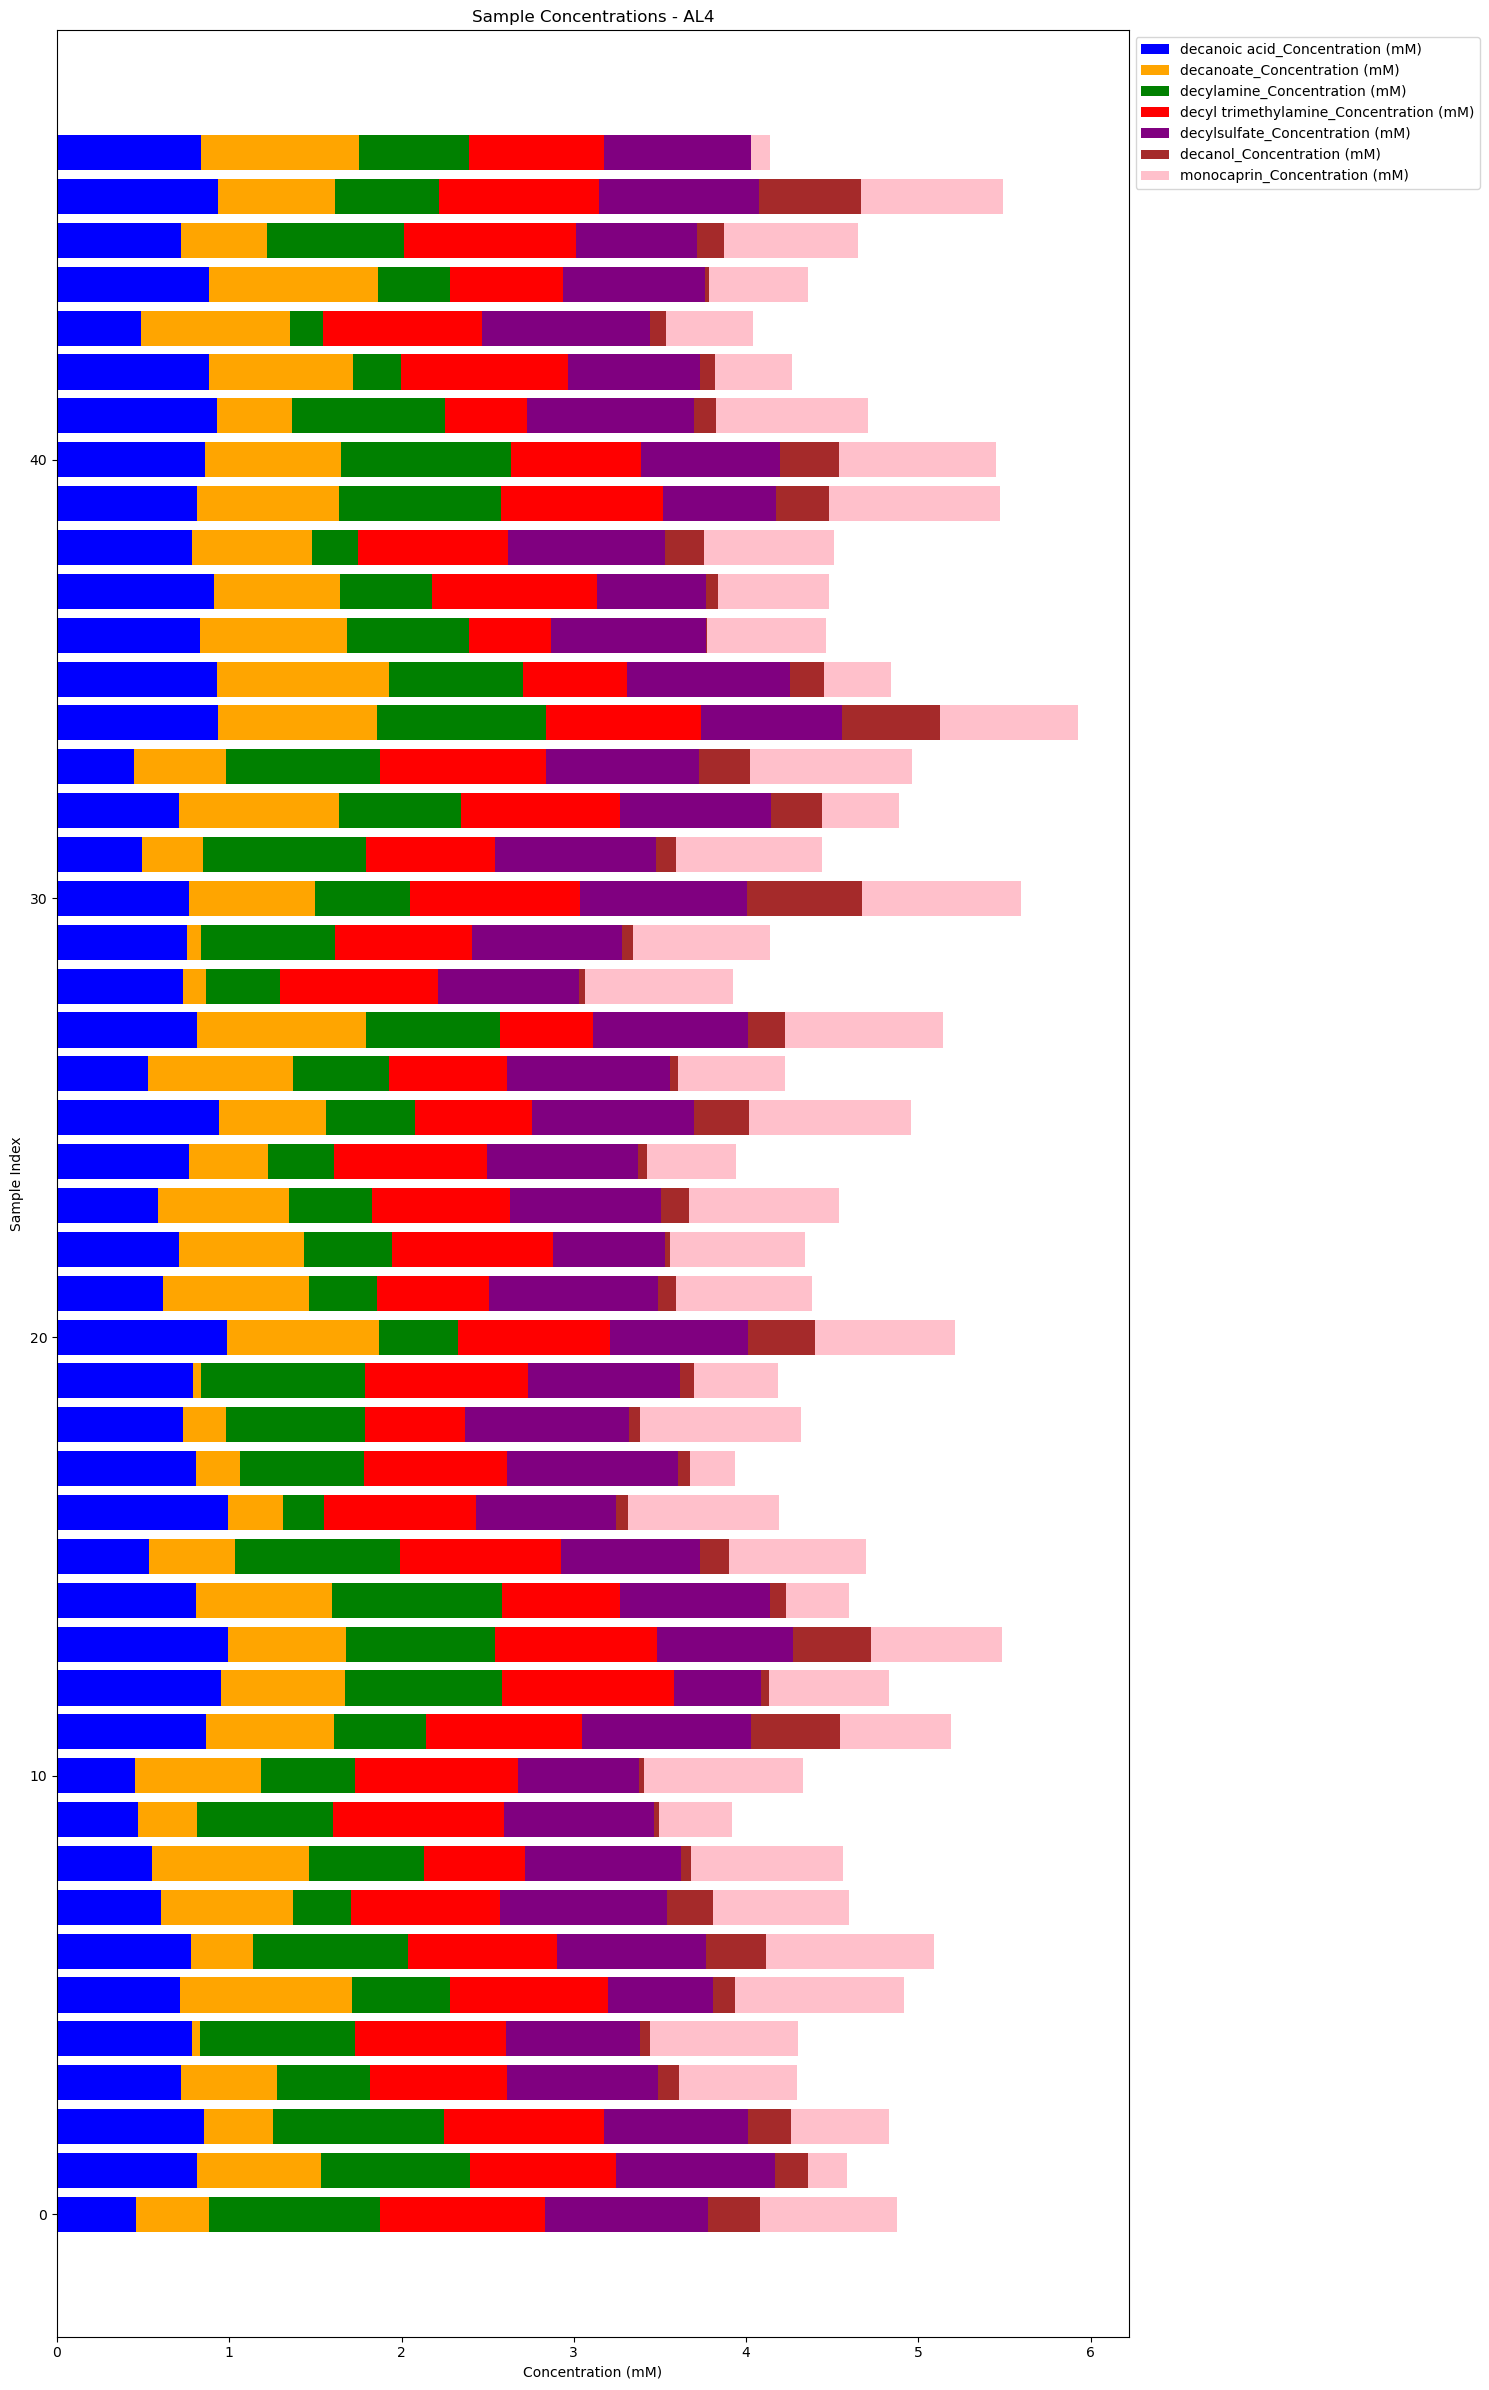

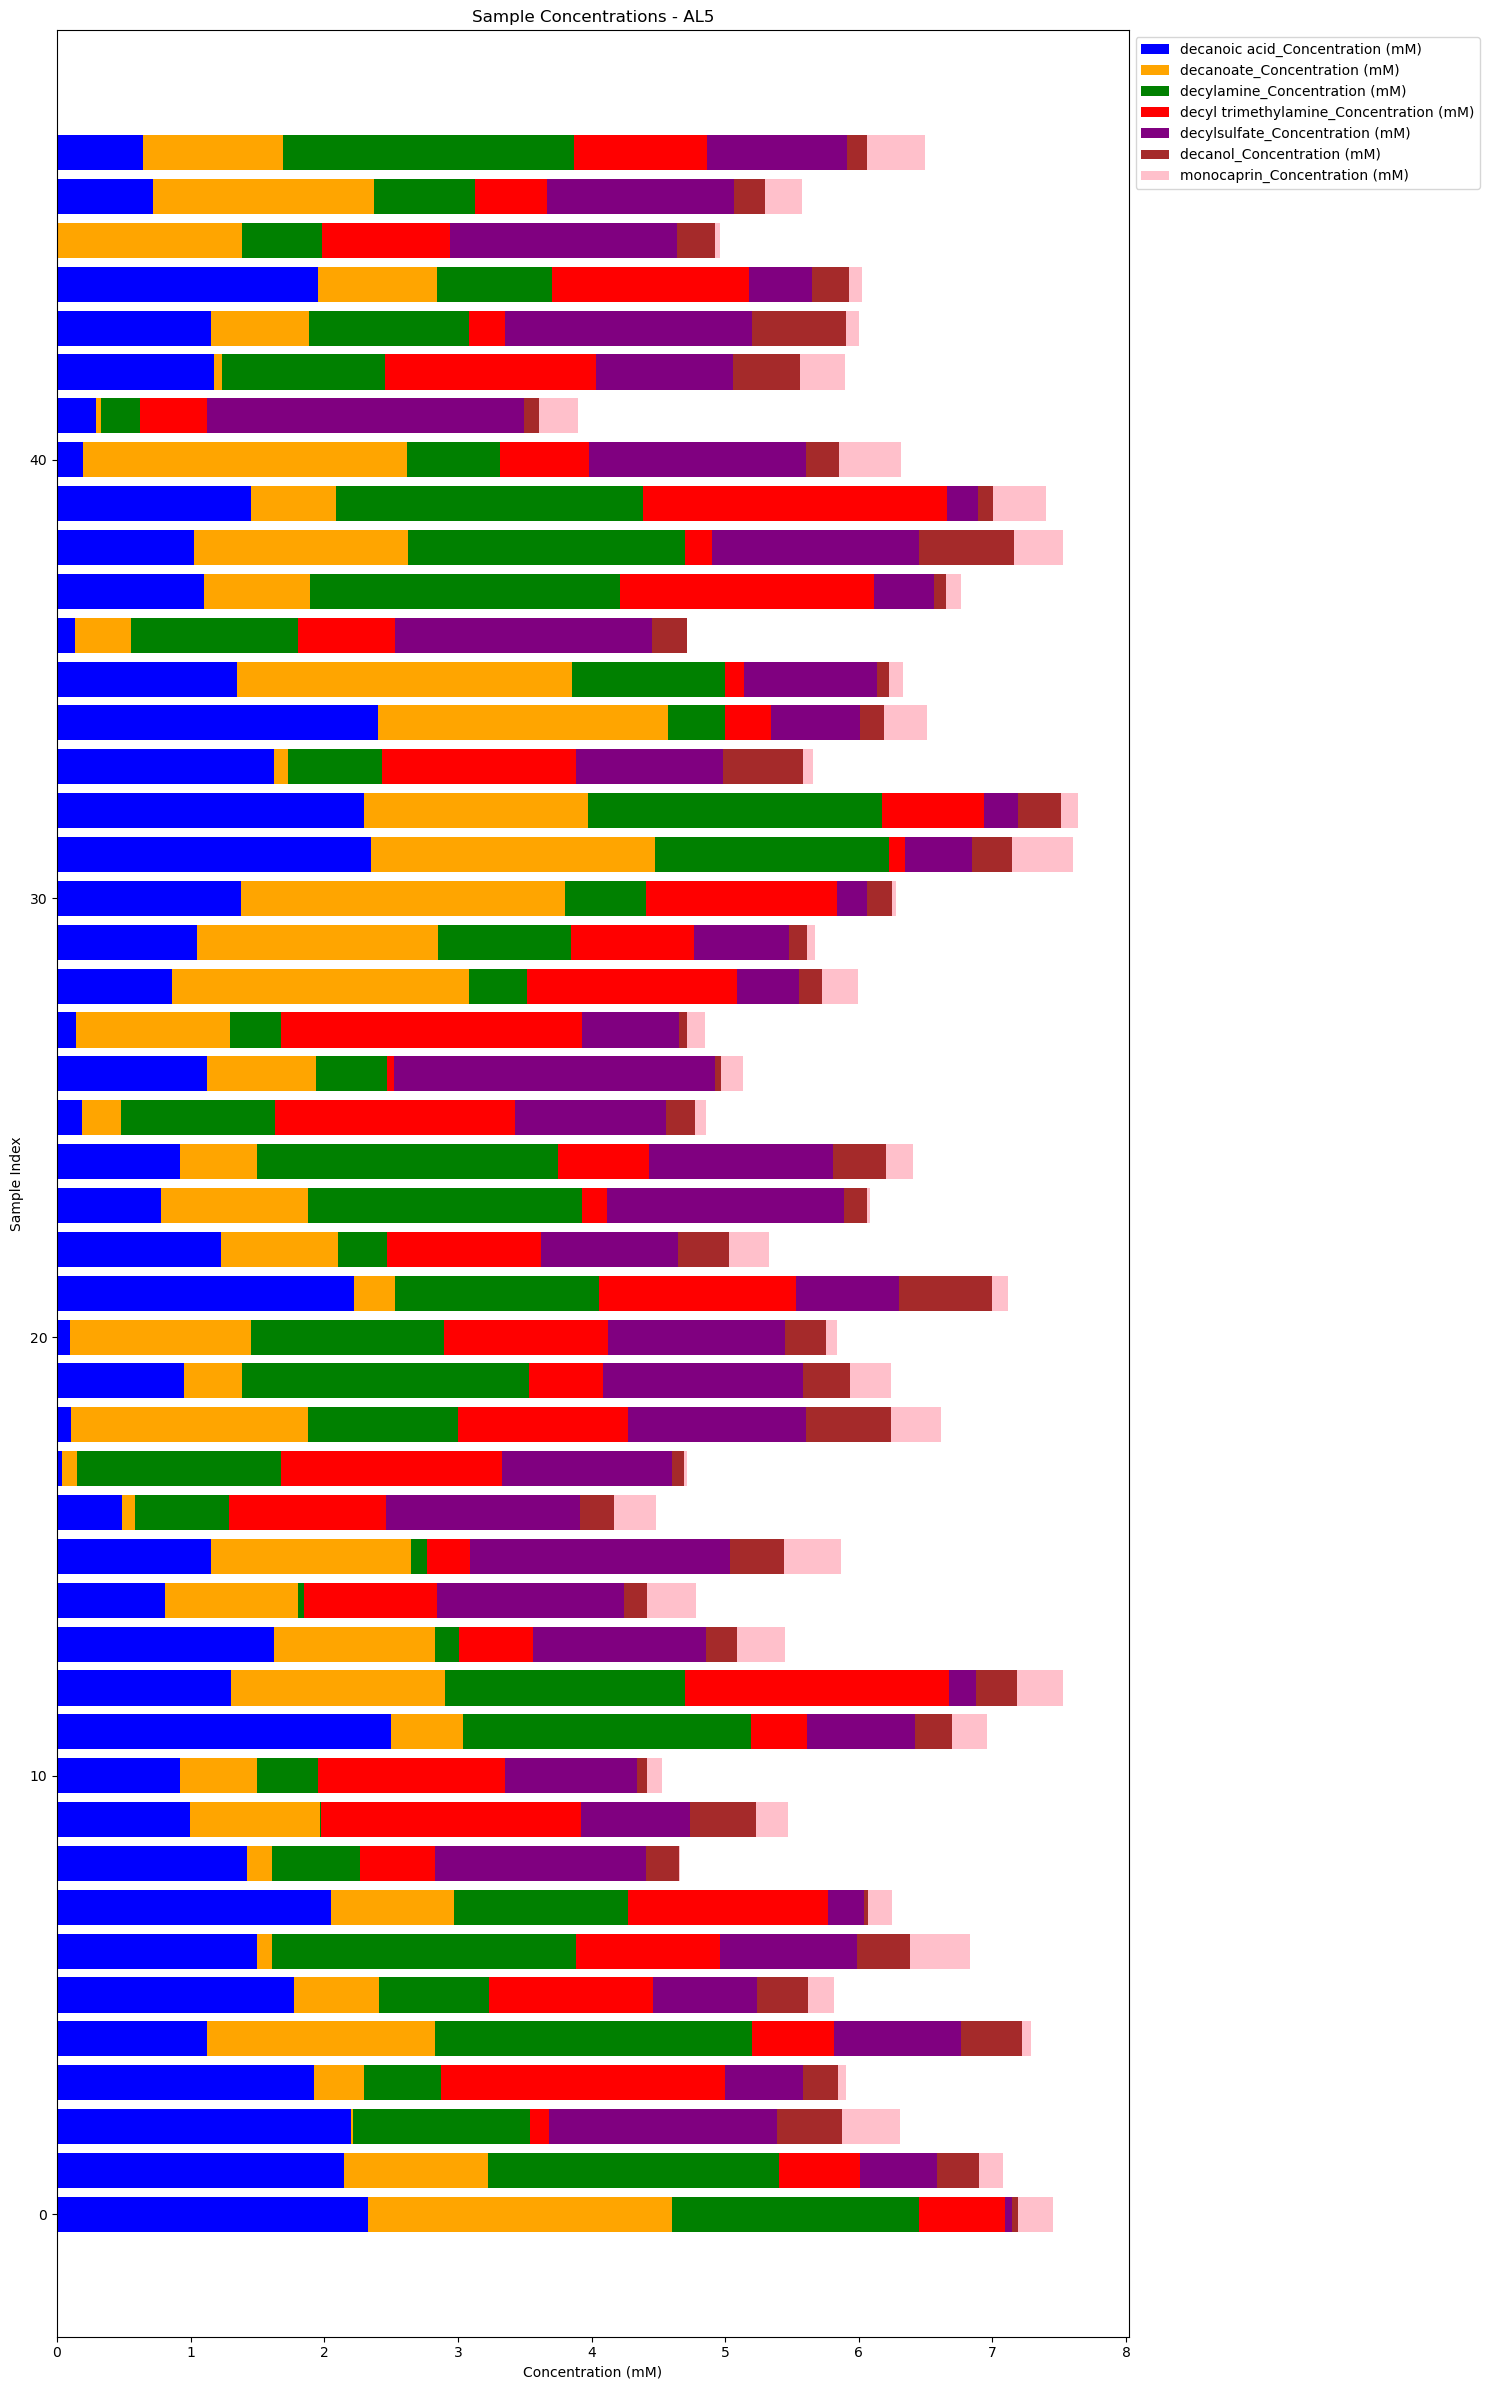

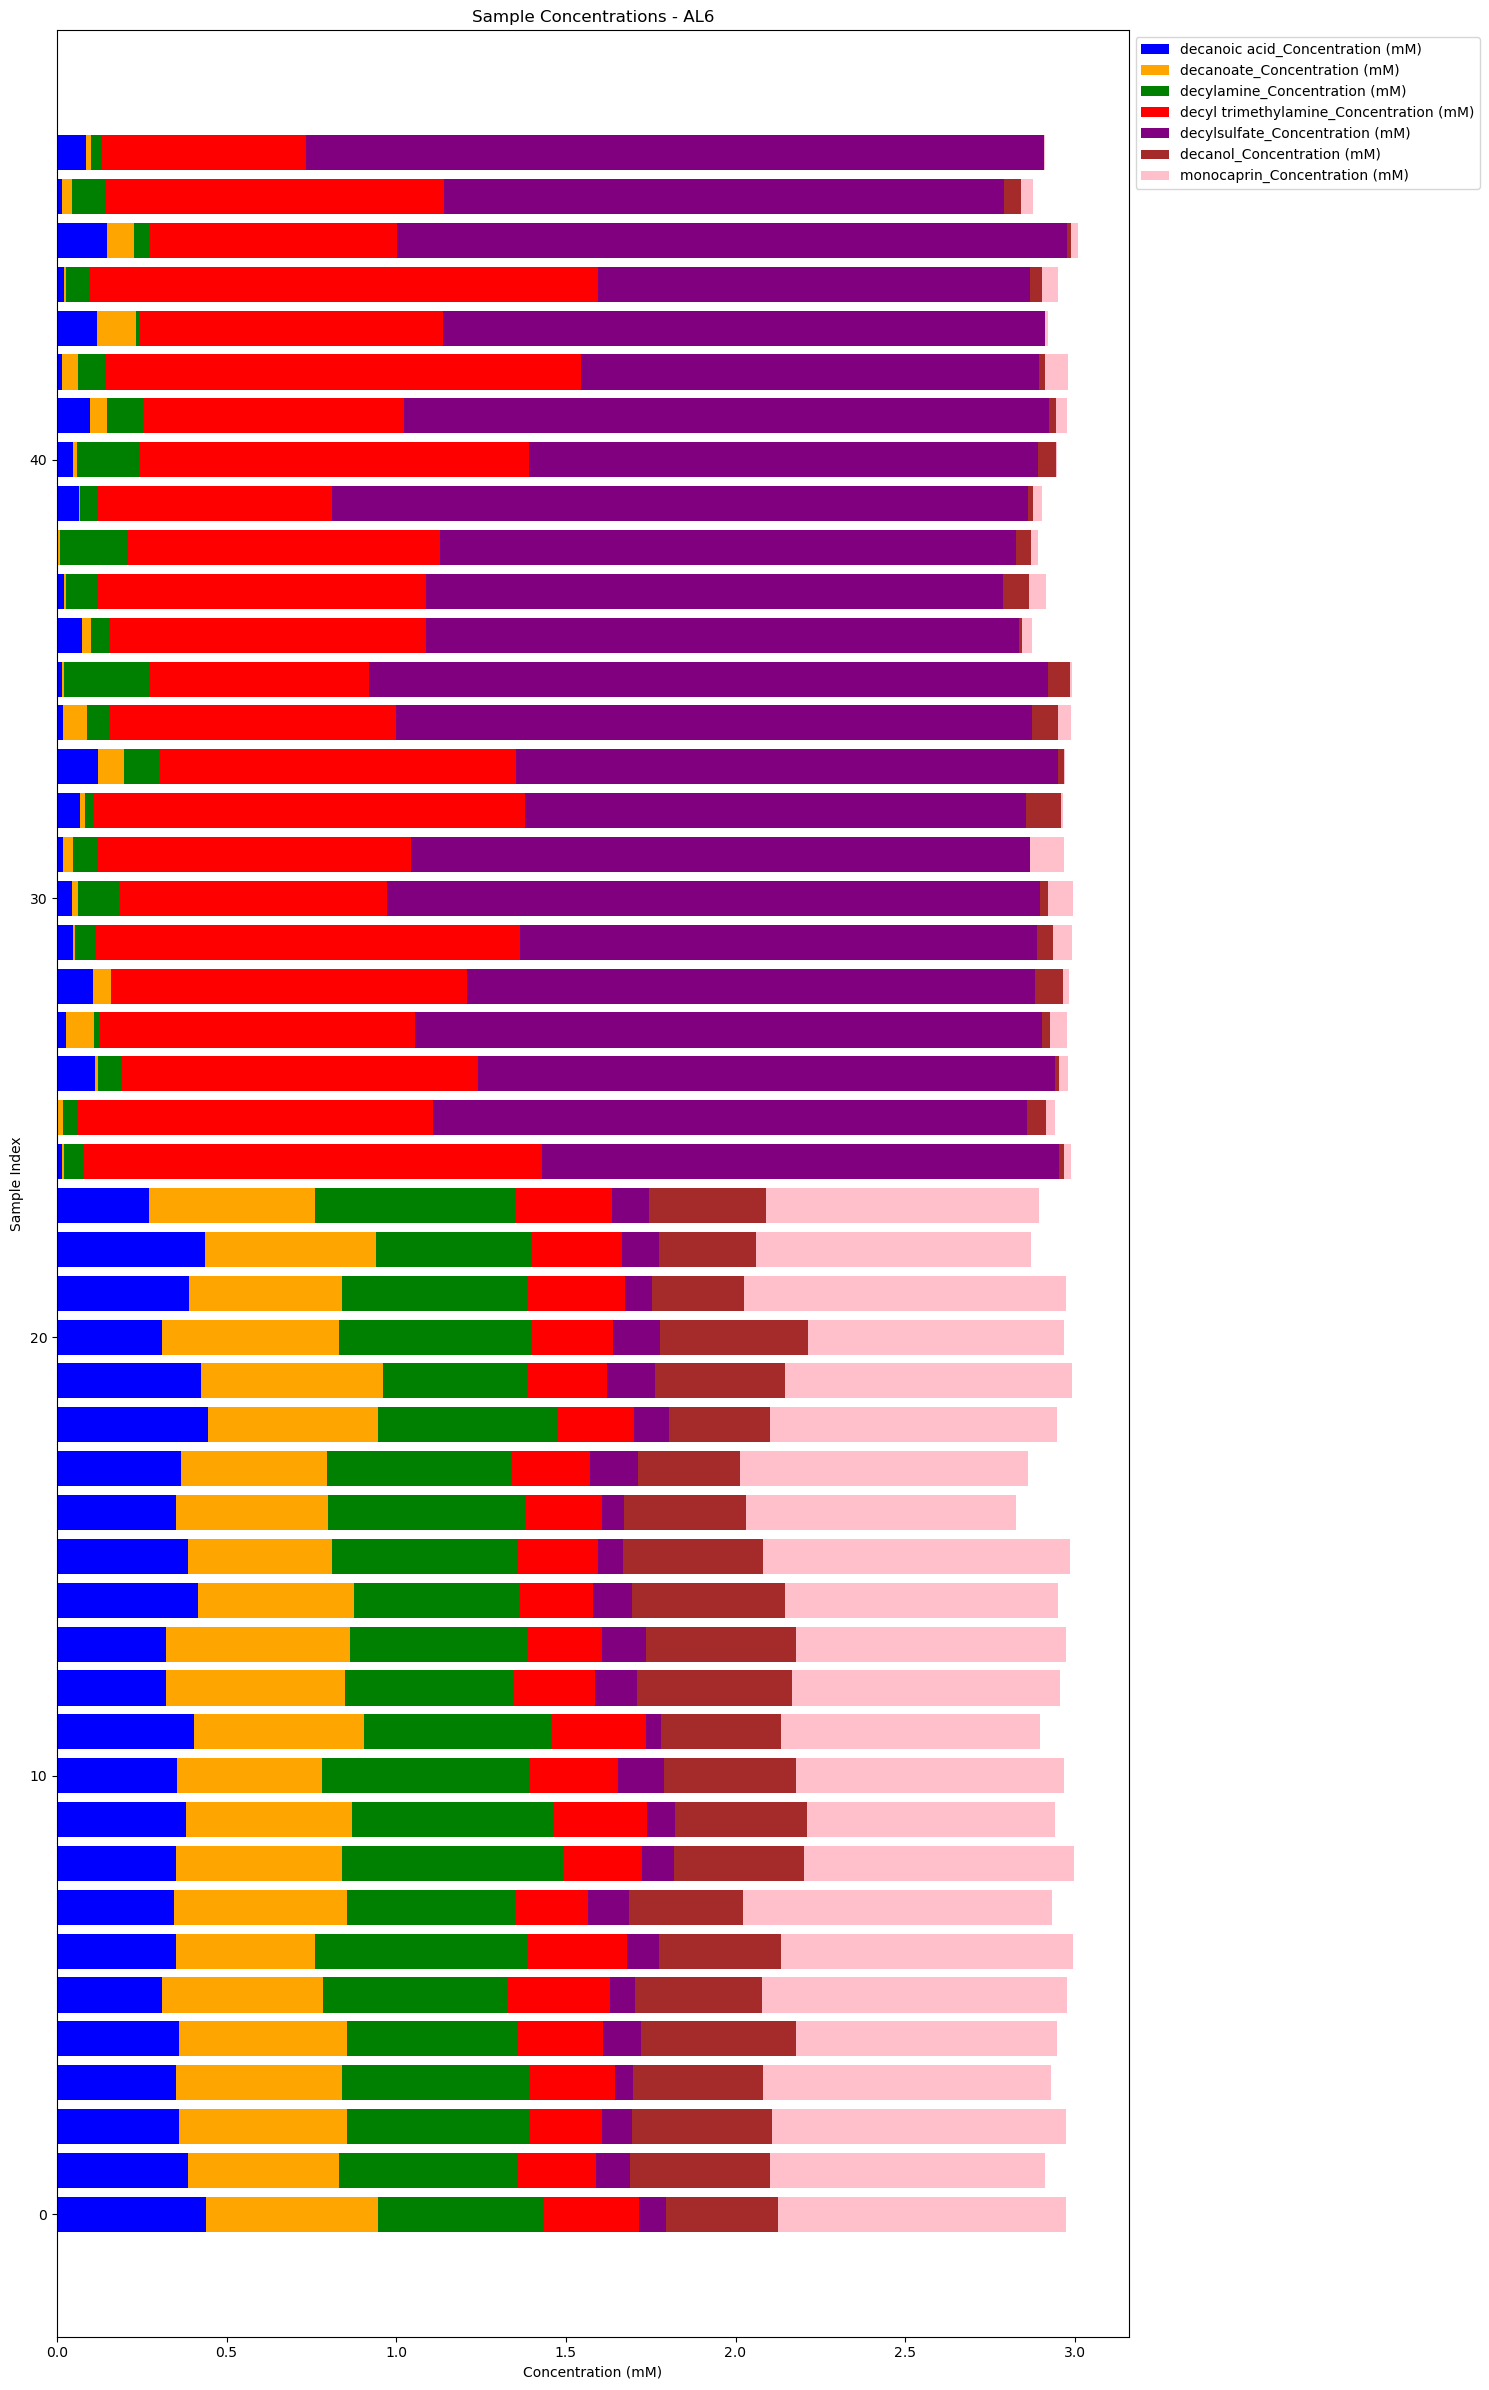

In [40]:
dfs = [df1, df2, df3, df4, df5, df6, df7]

# Loop through each DataFrame and plot the samples
for i, df in enumerate(dfs):
    title = f'Sample Concentrations - AL{i}'
    plot_samples(df.drop('num_vesicles', axis=1), title, color_map)

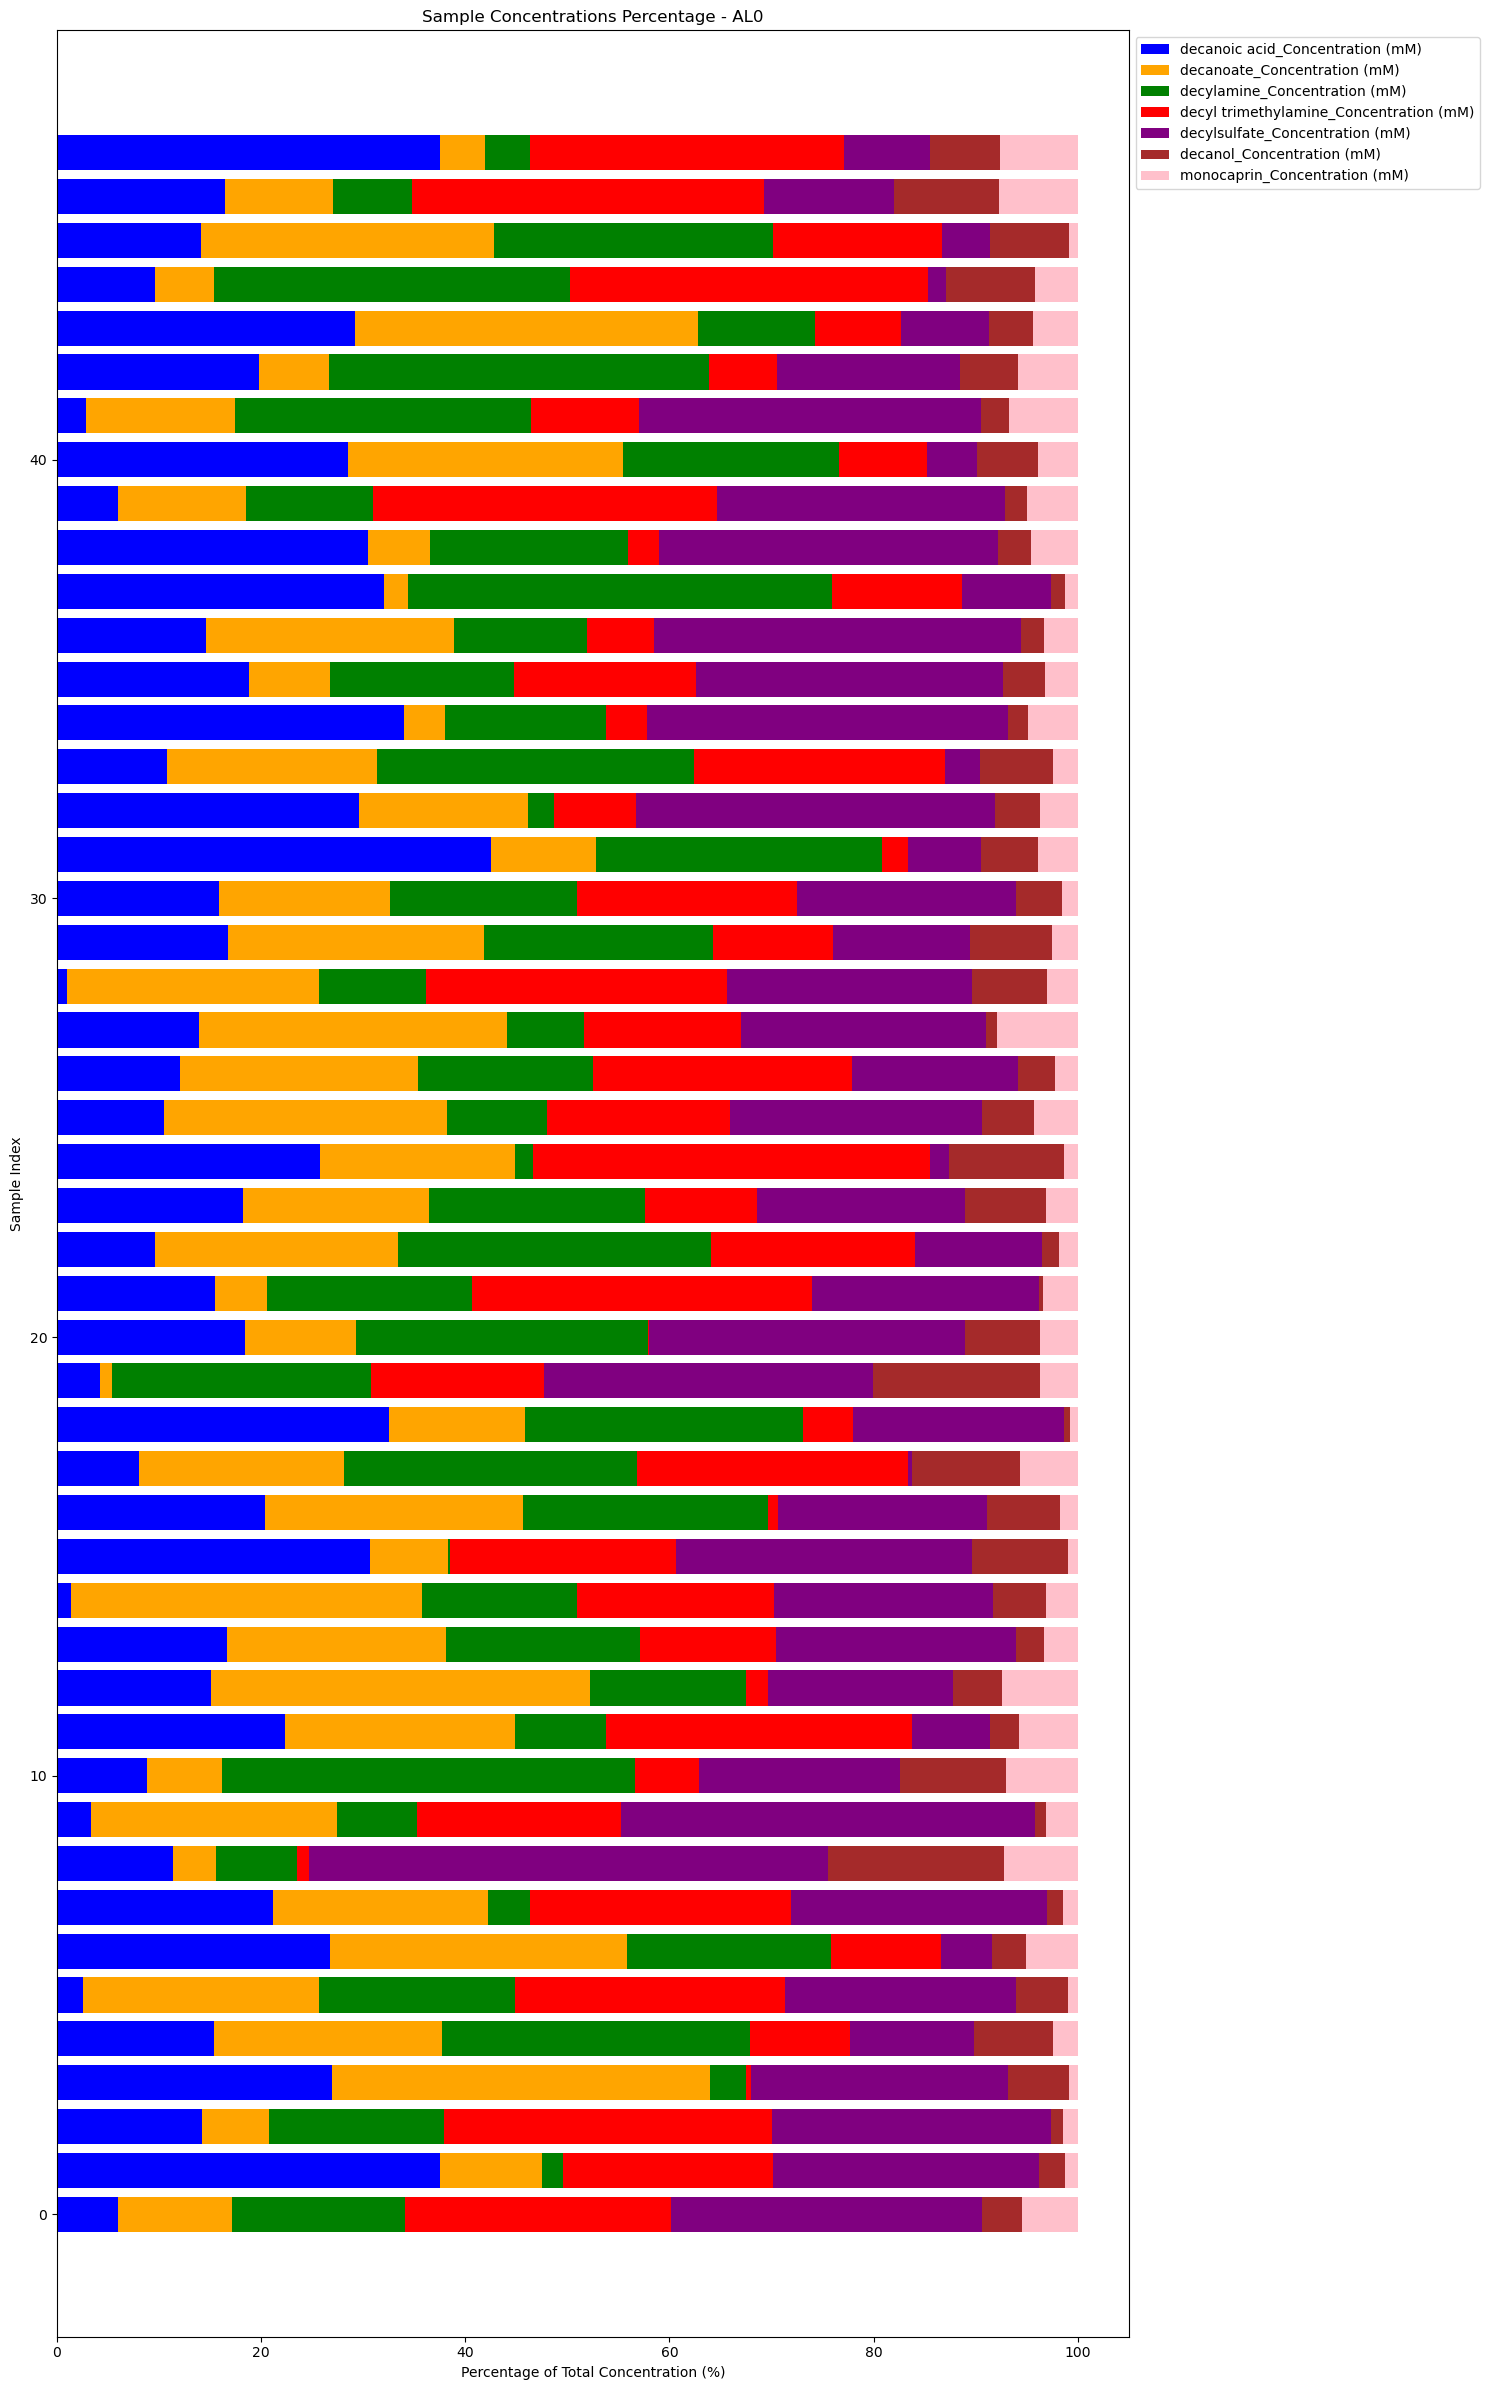

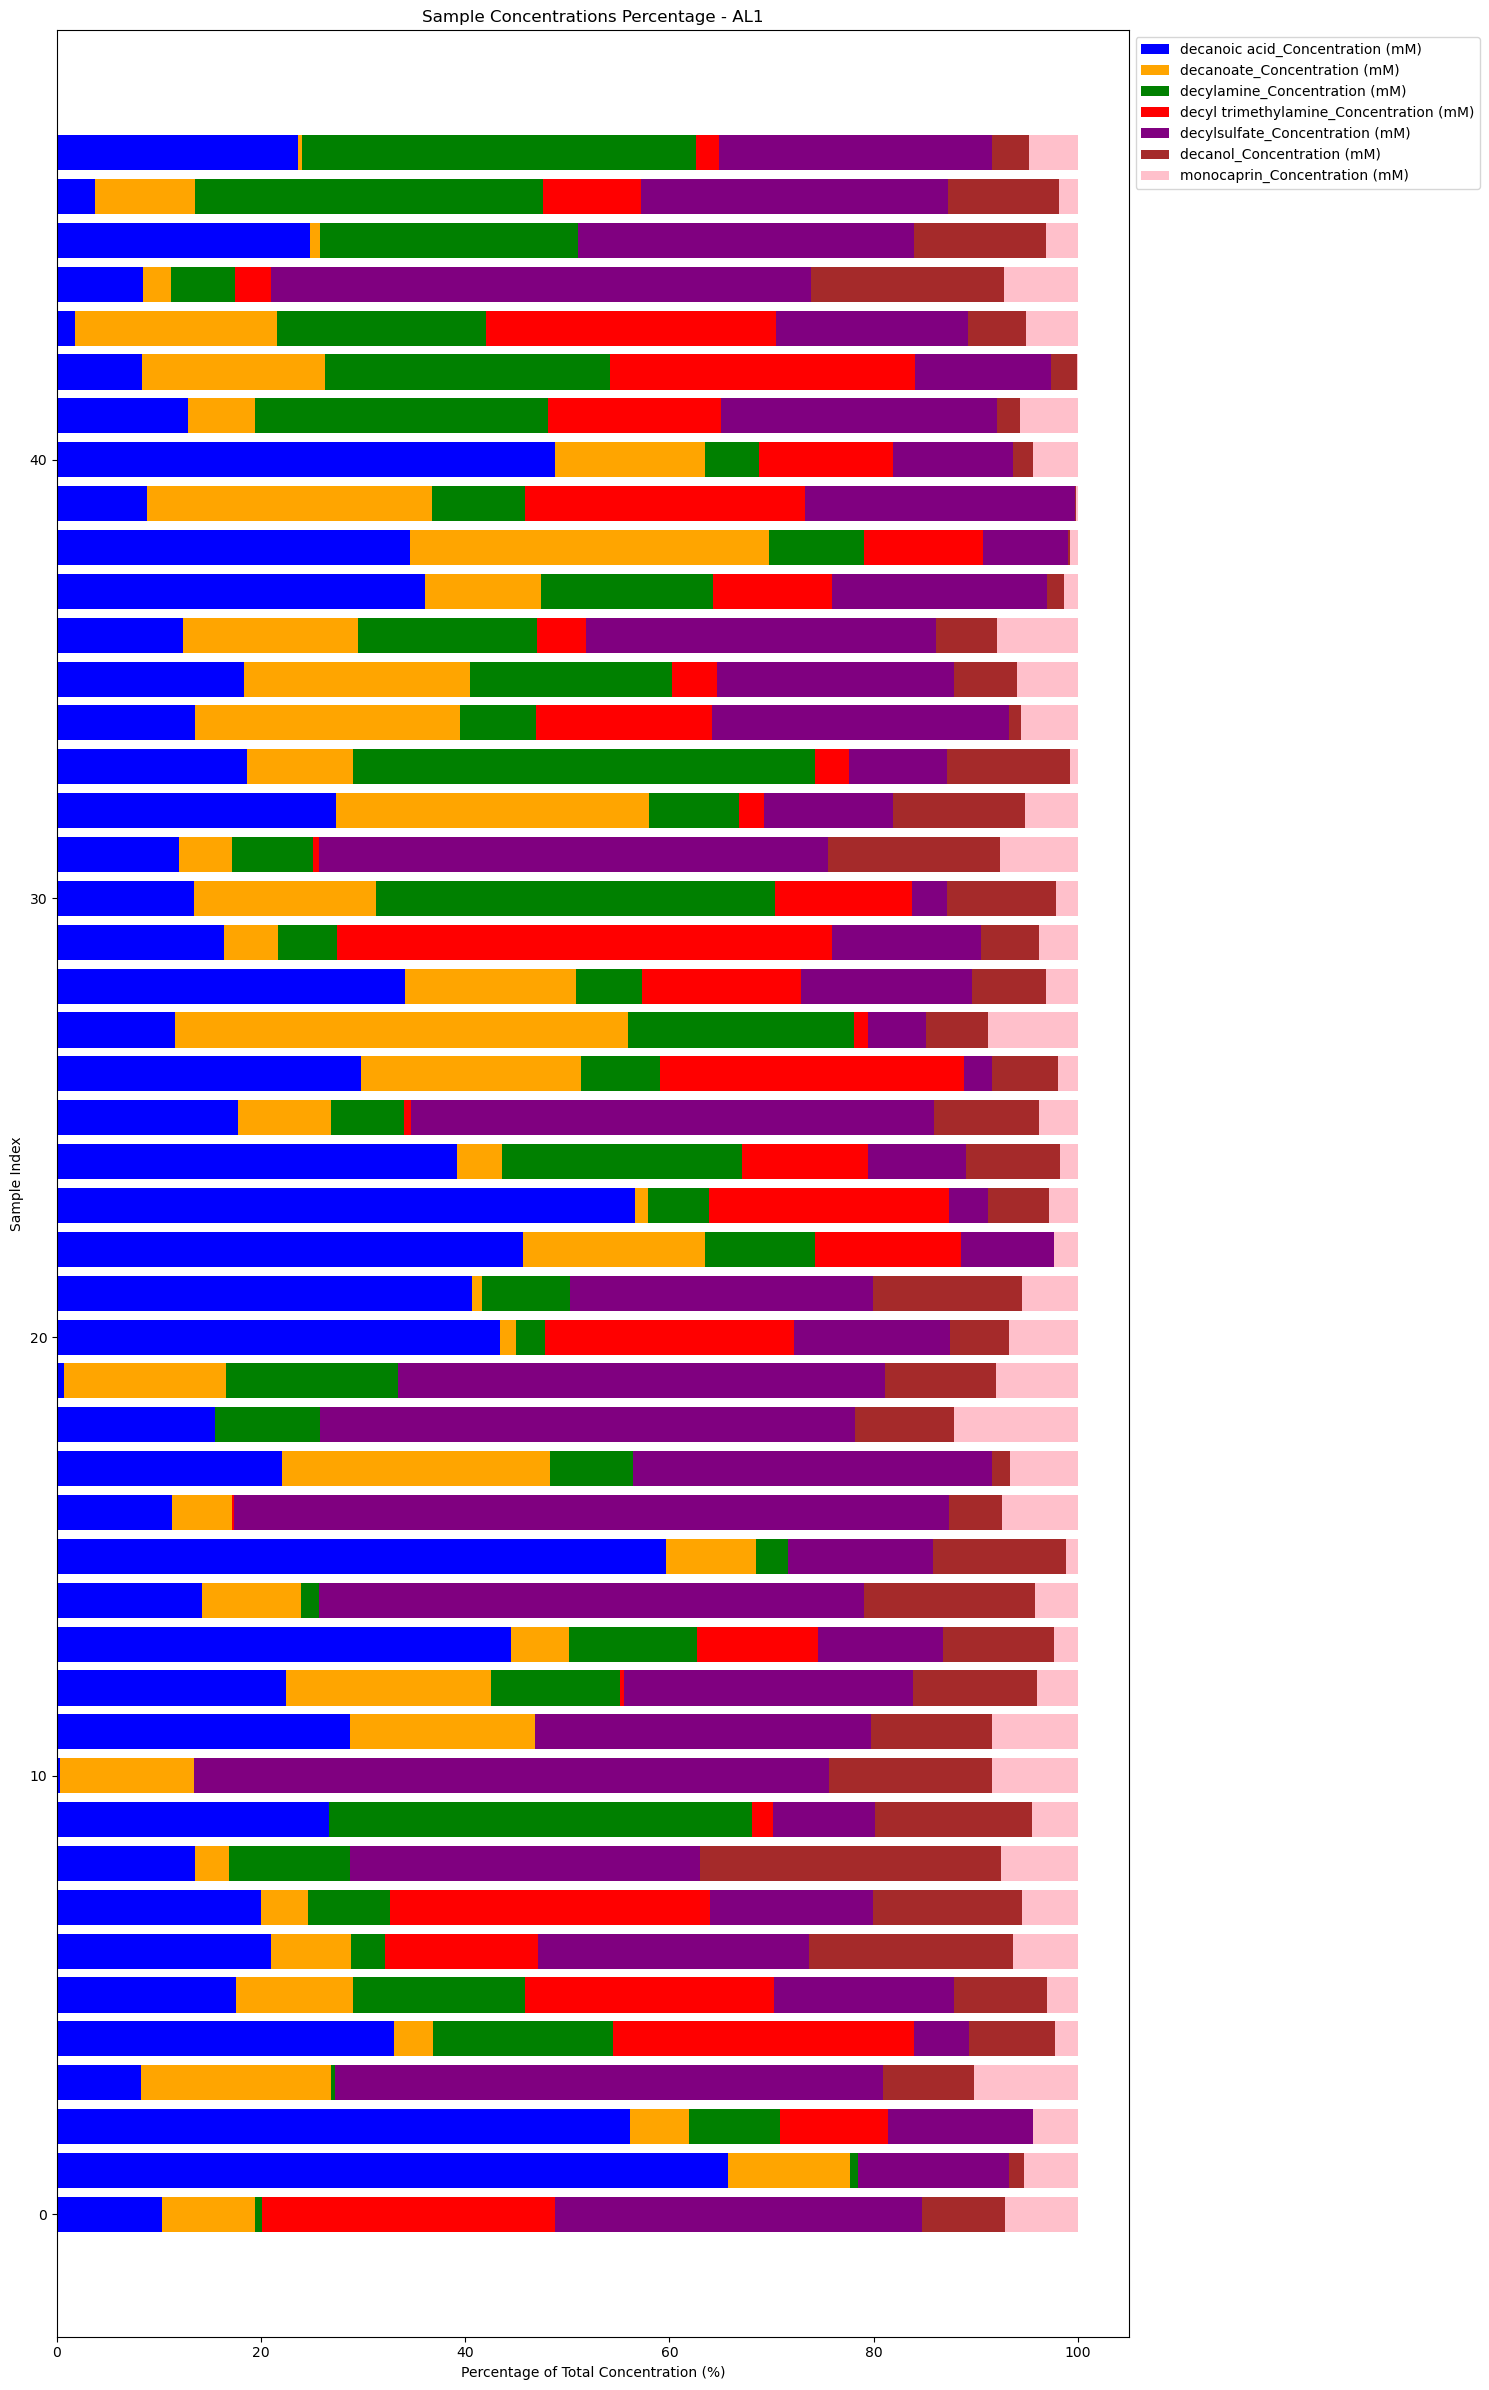

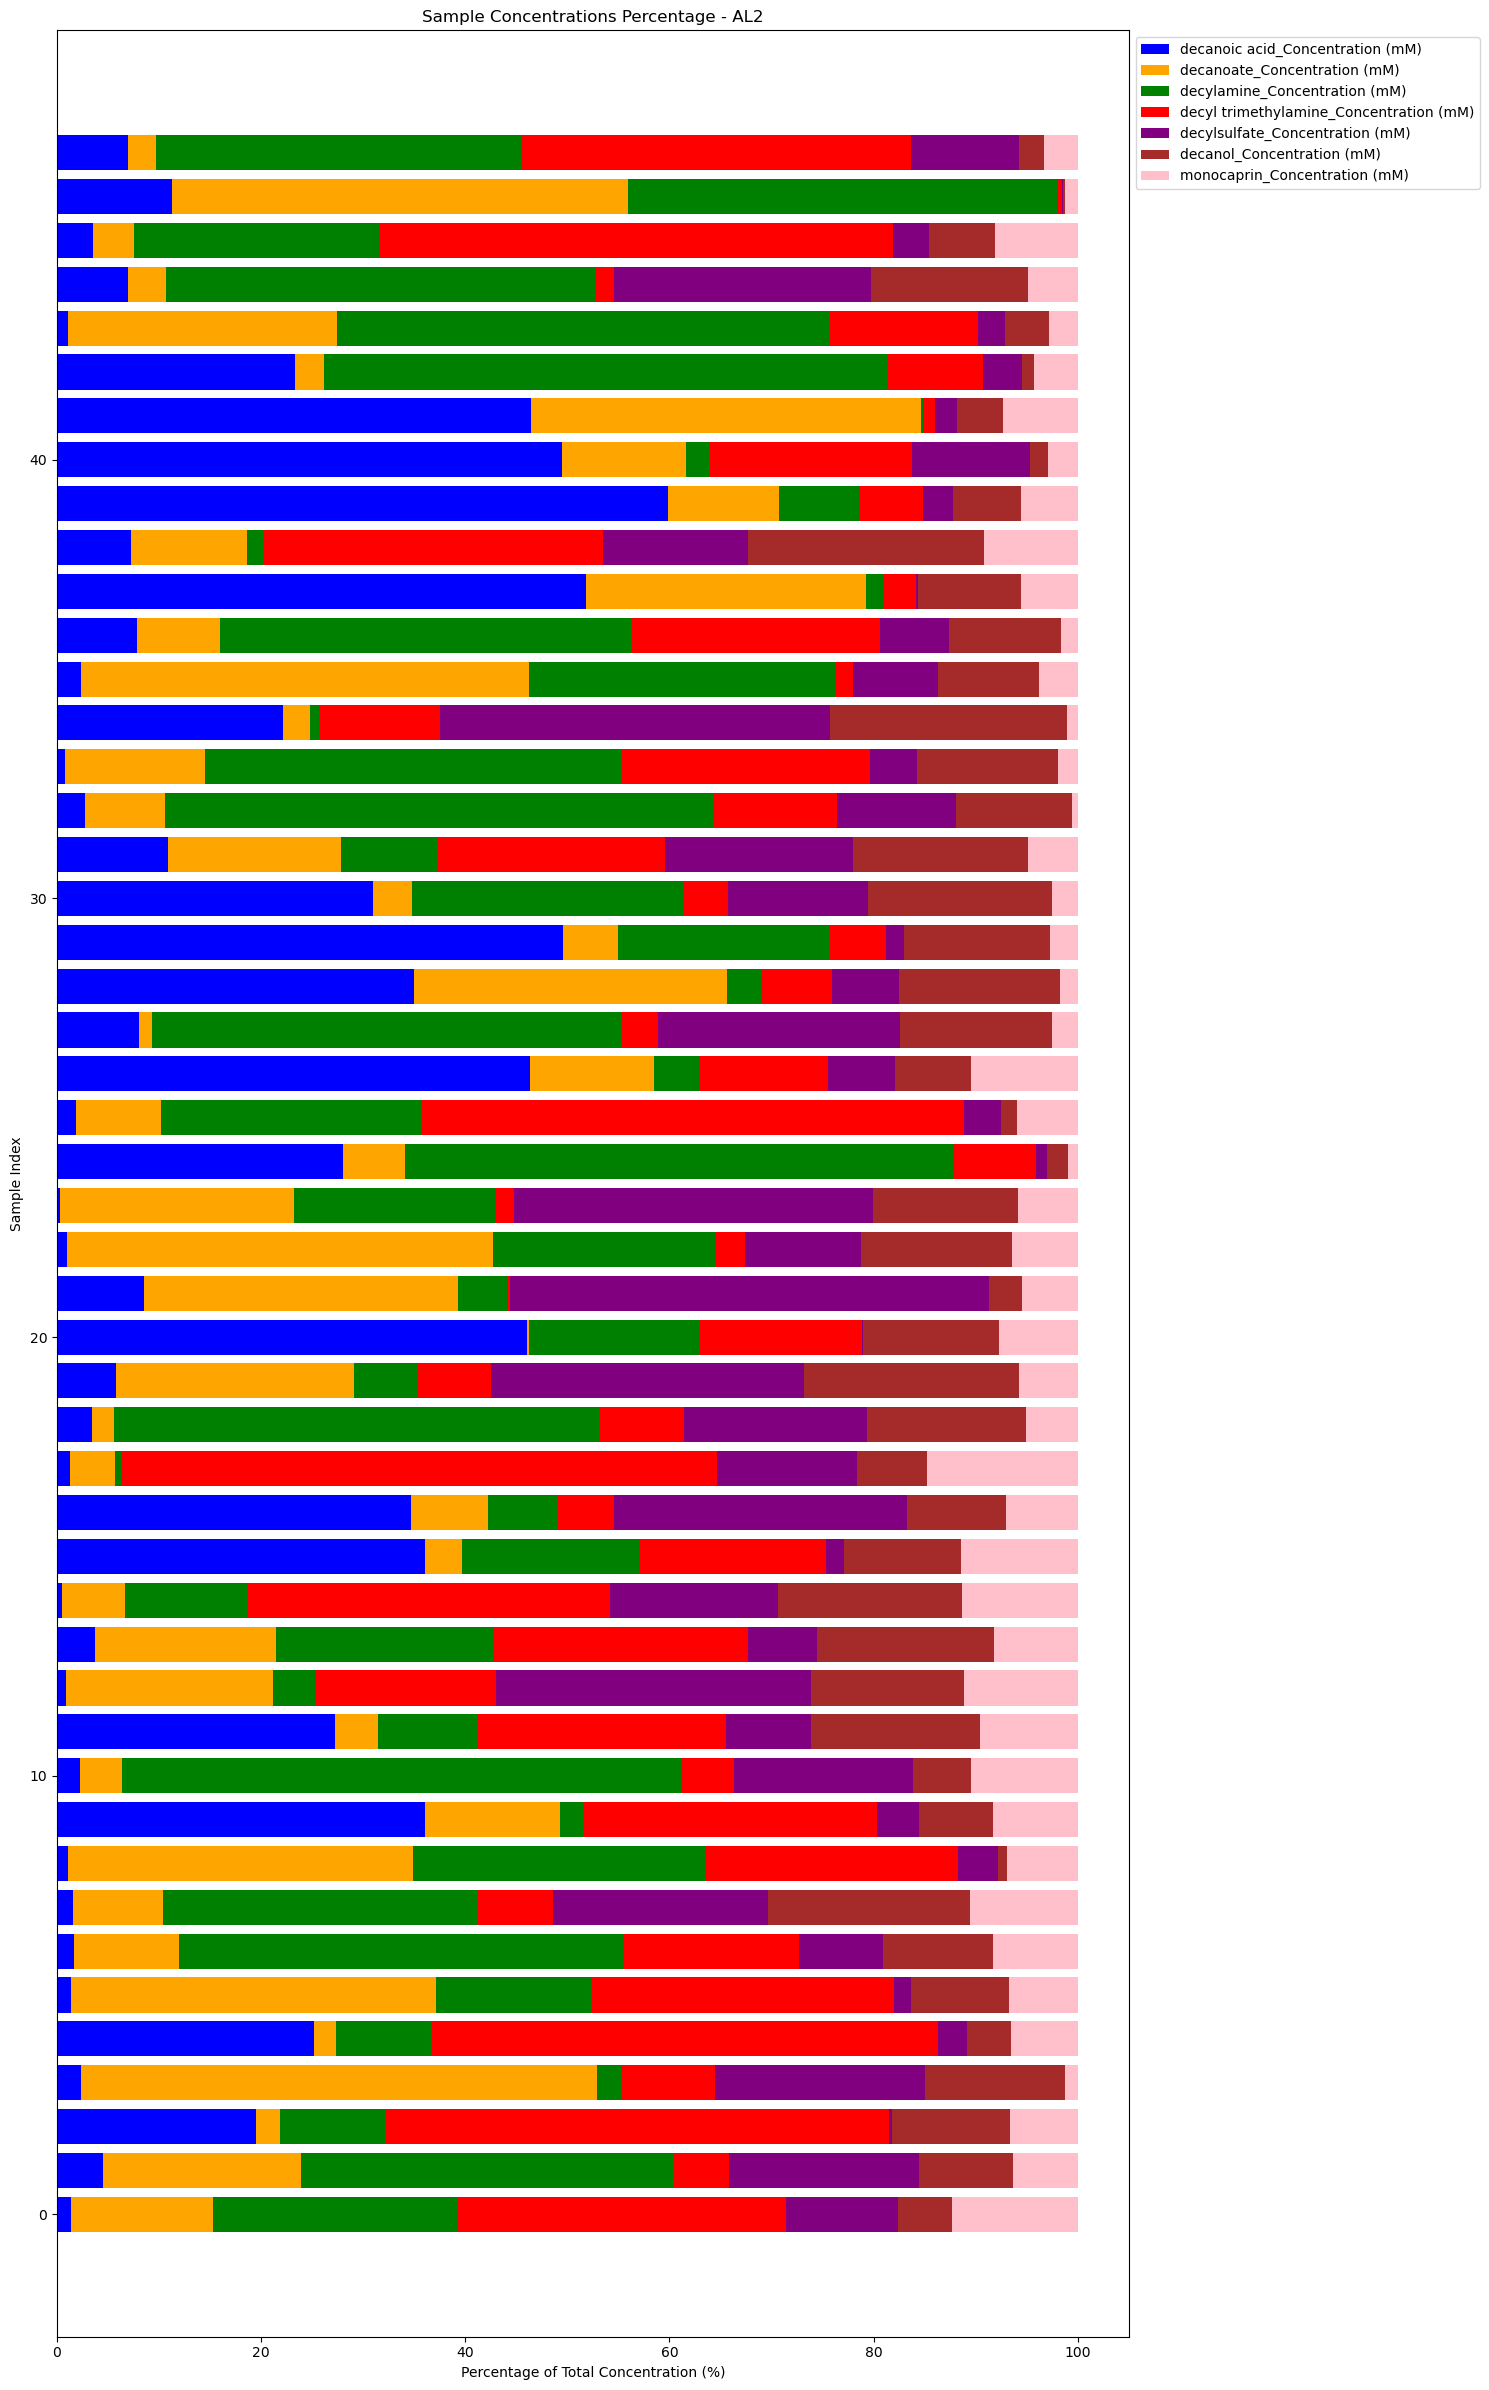

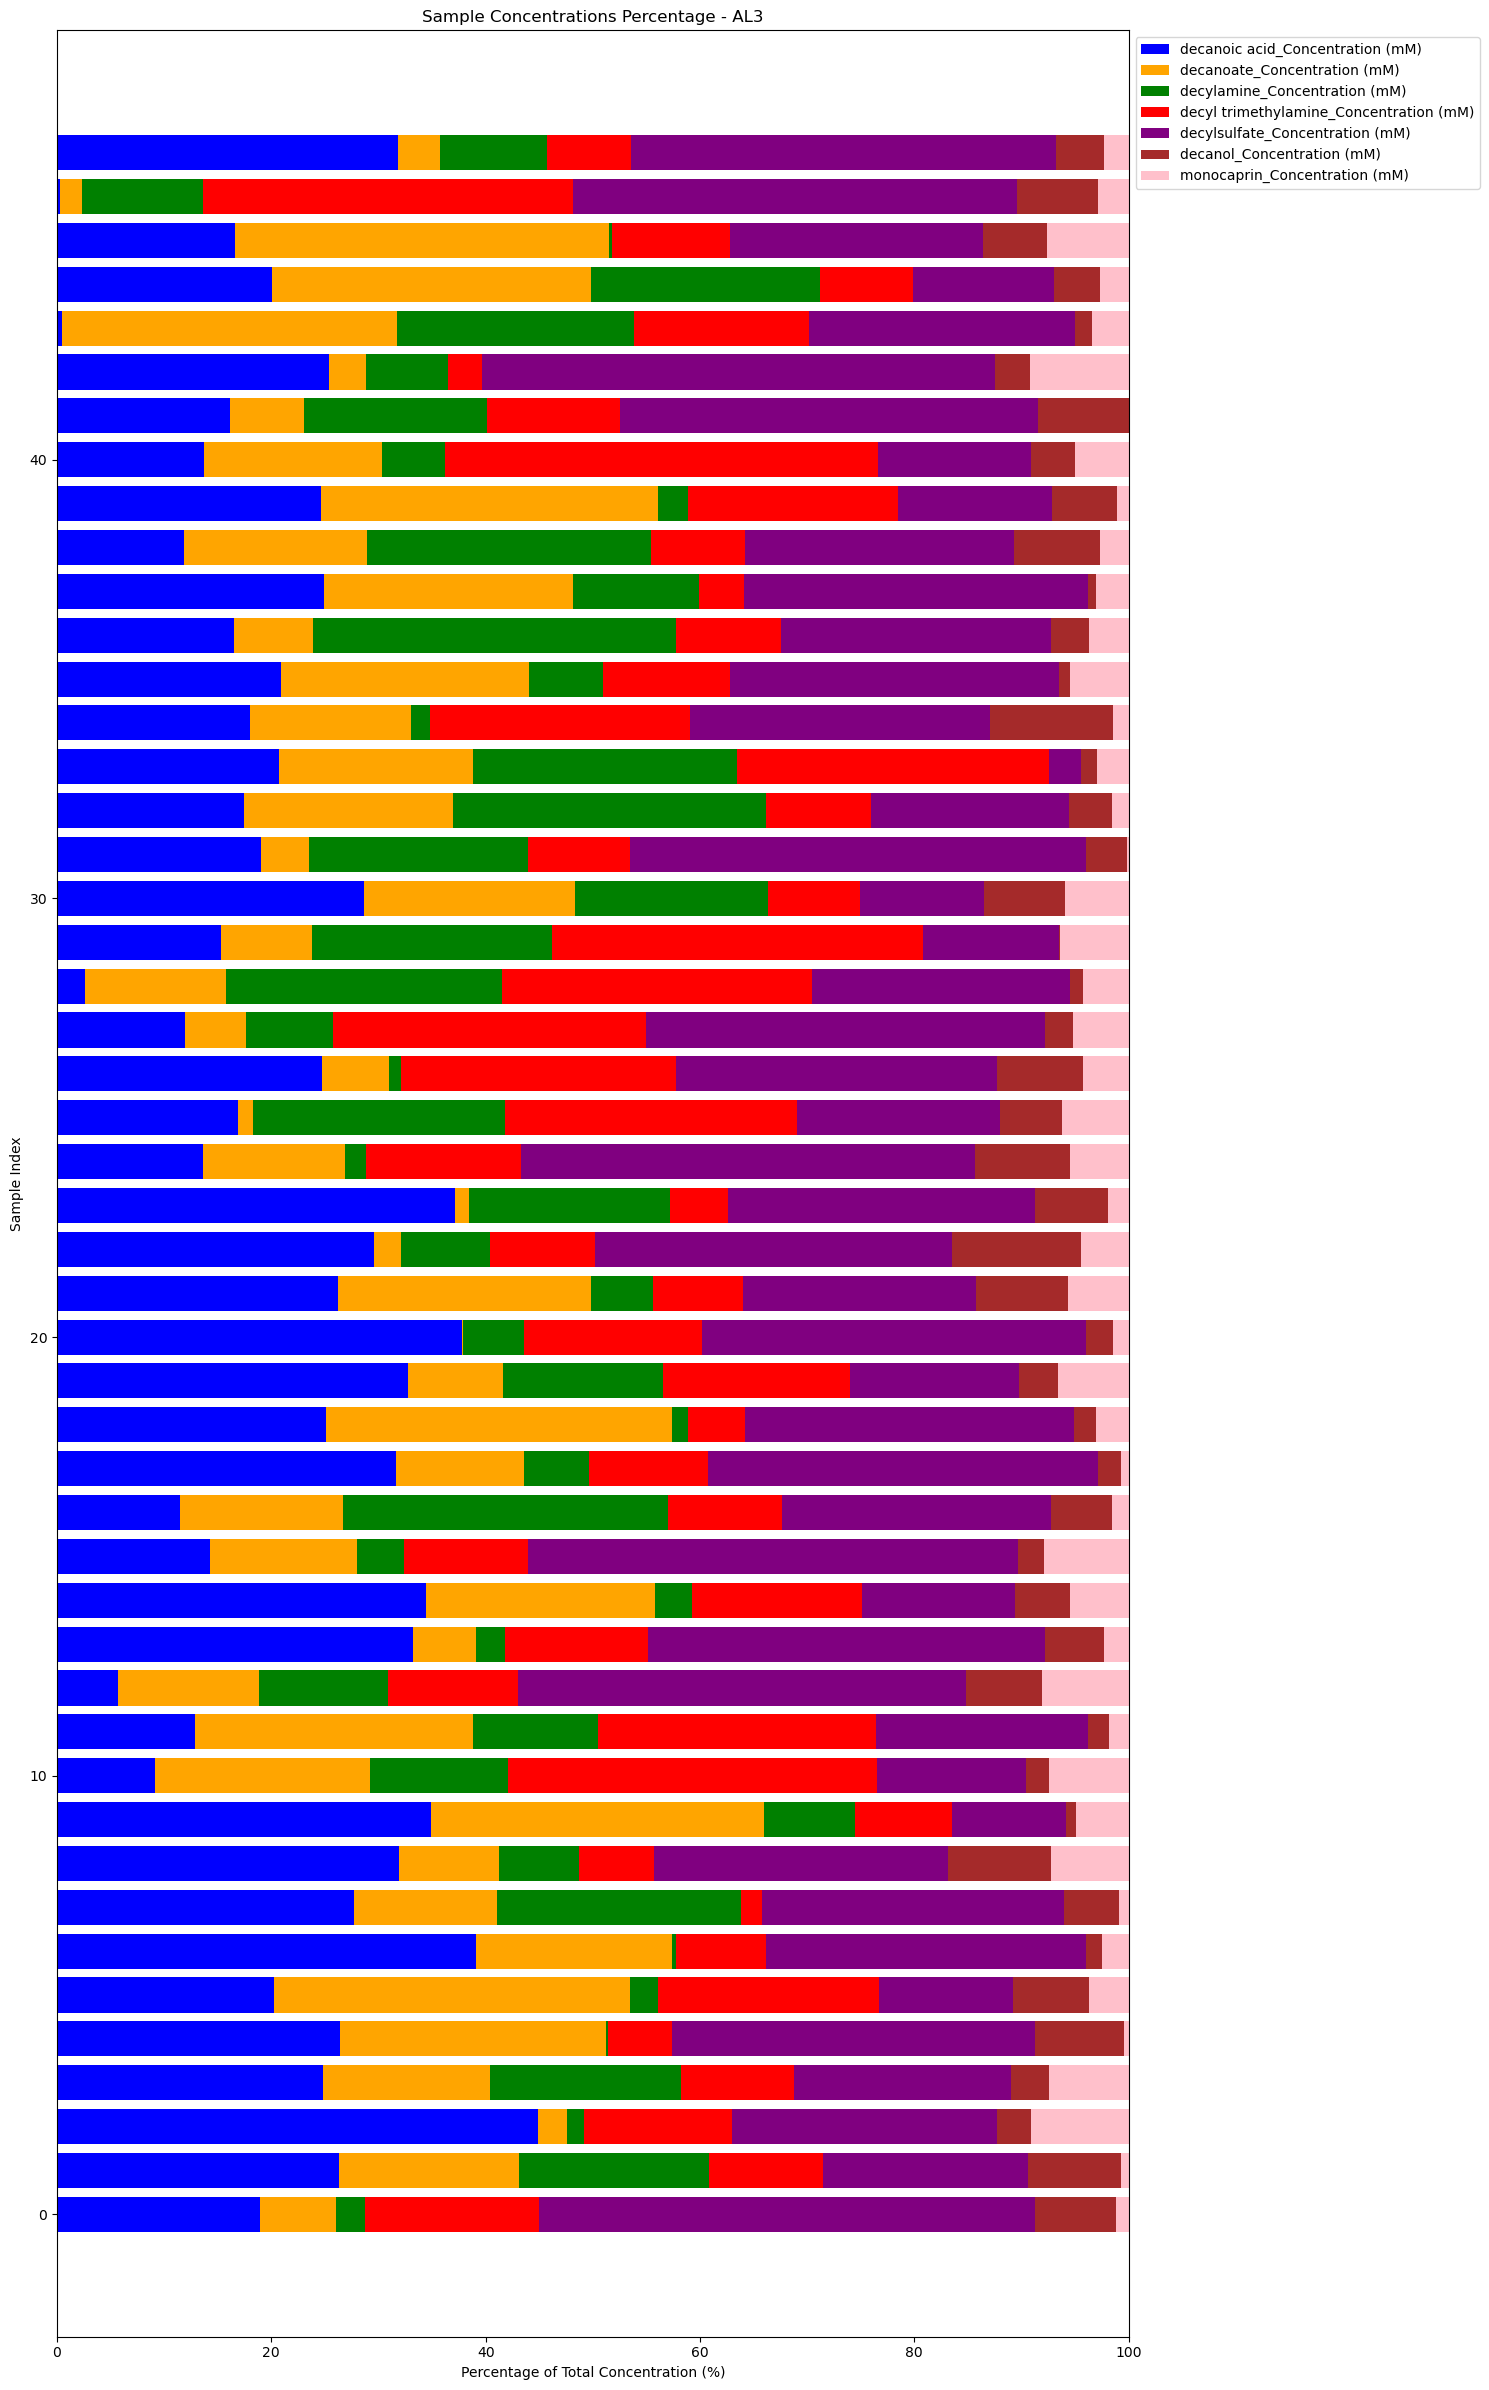

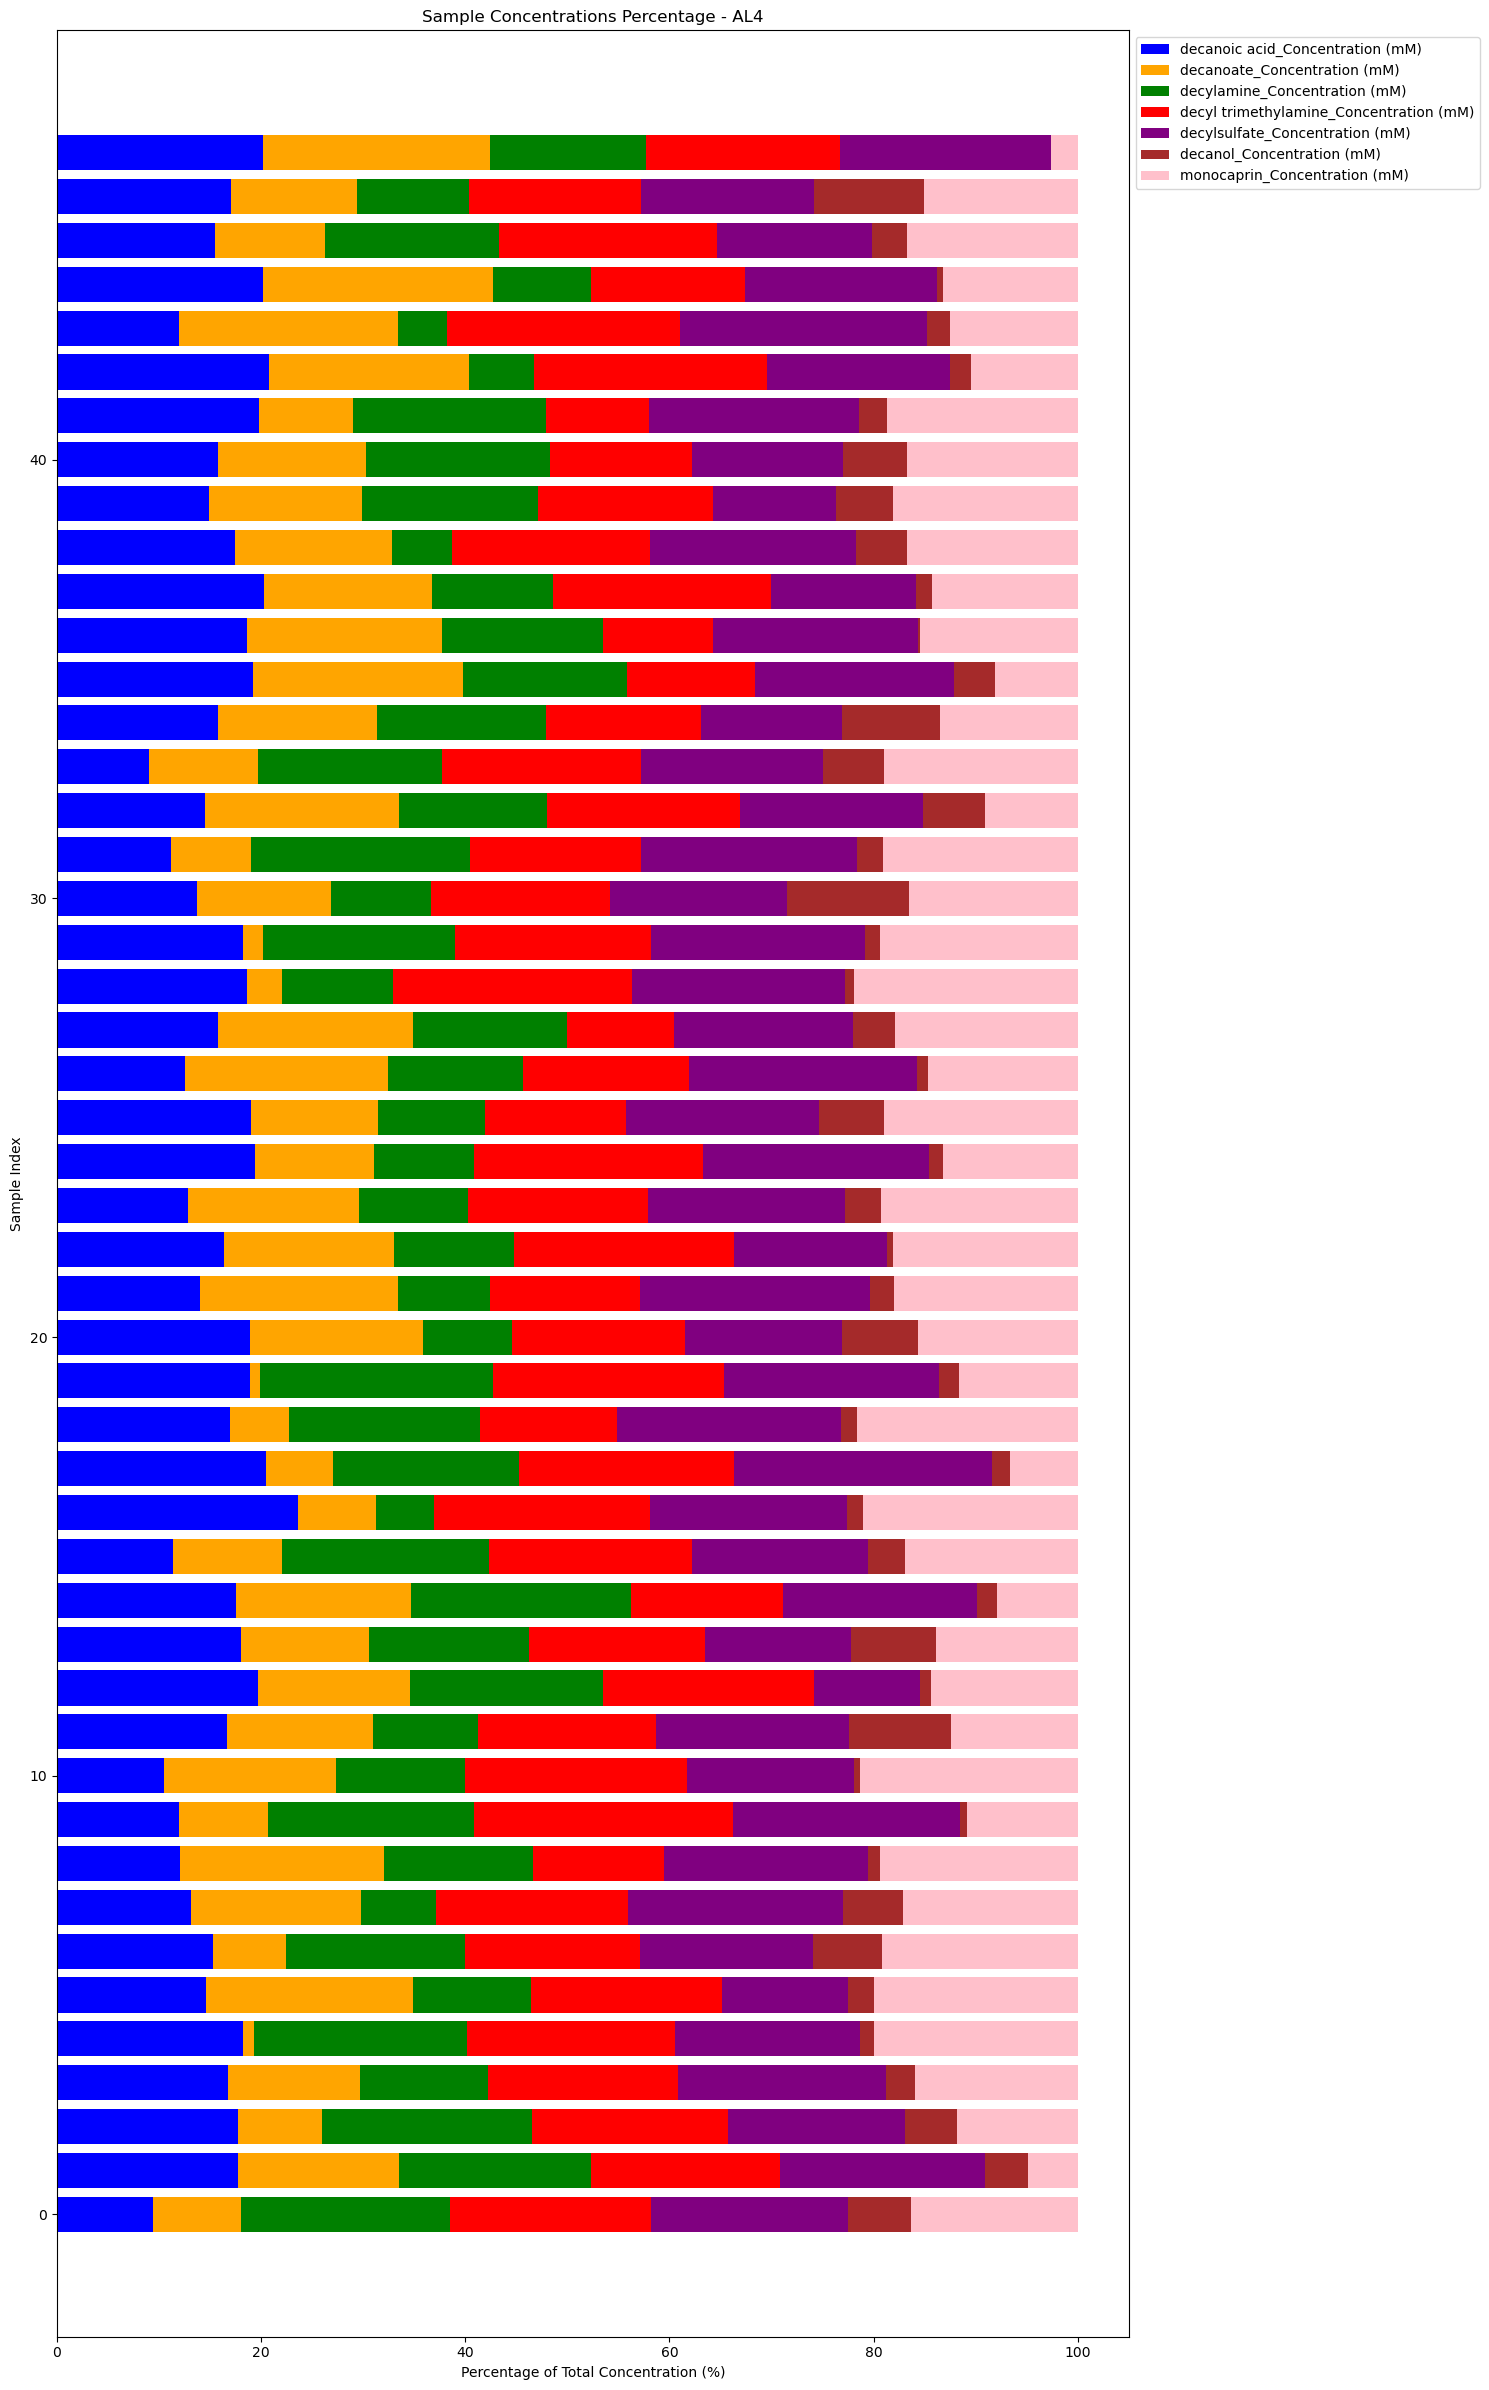

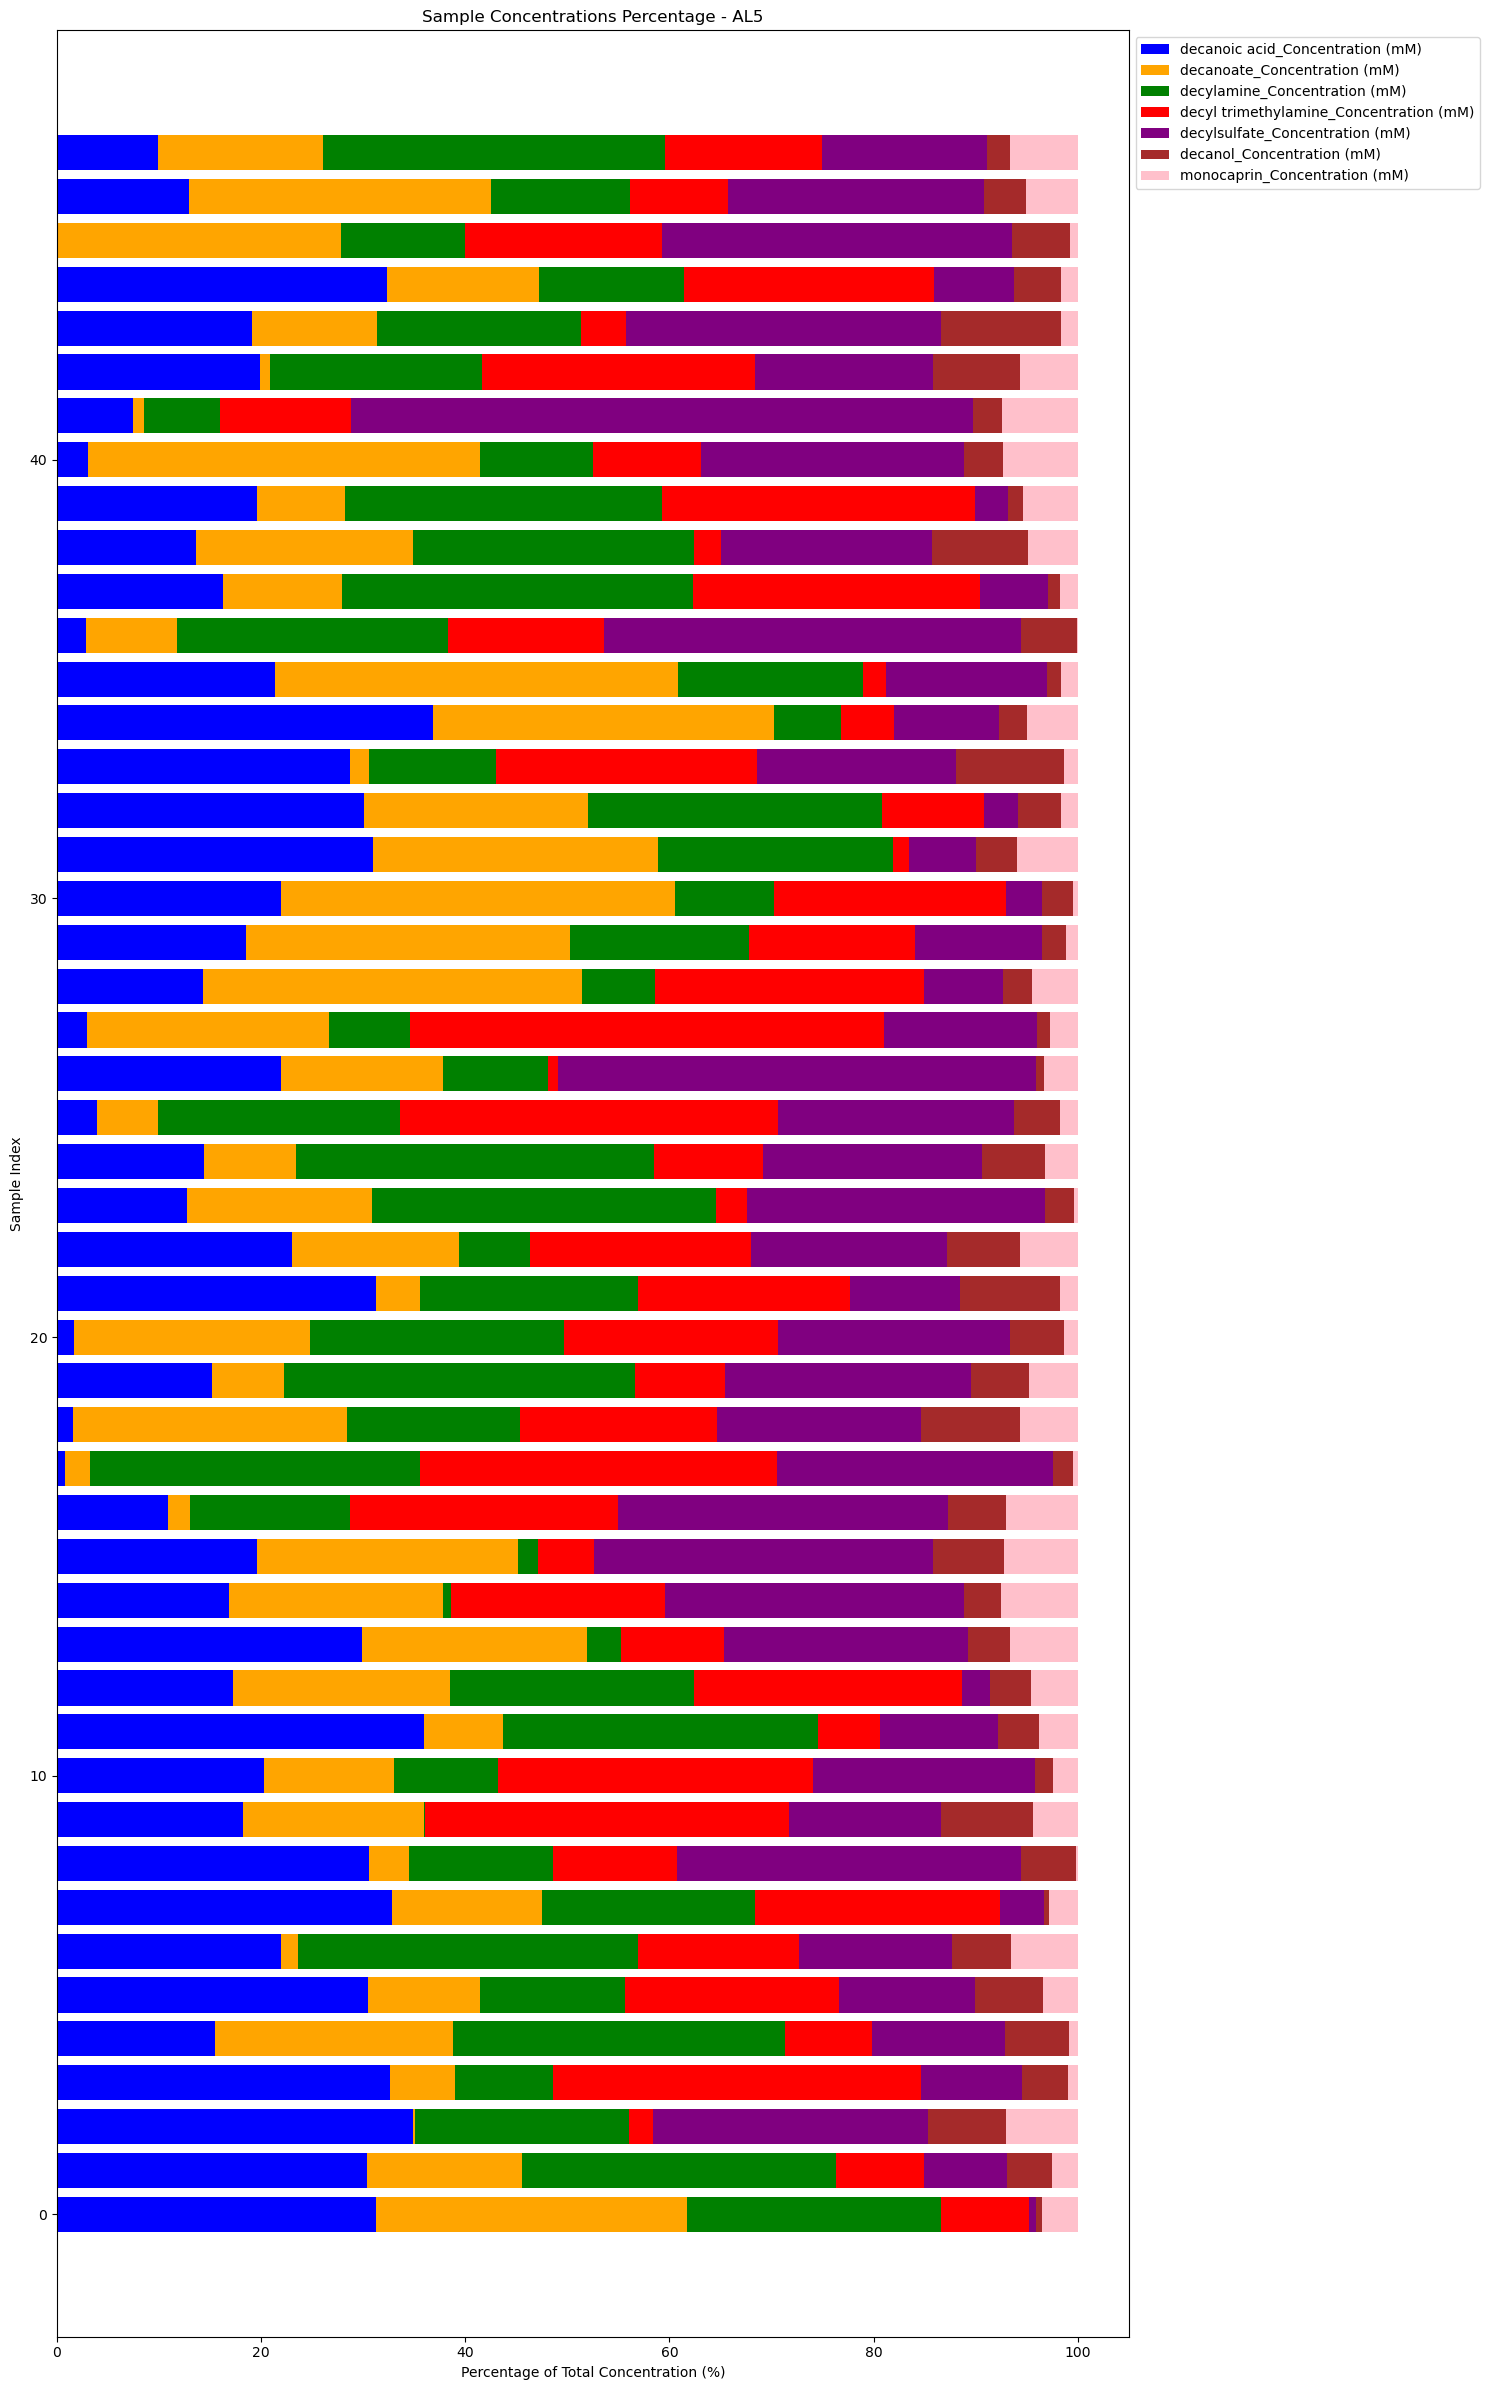

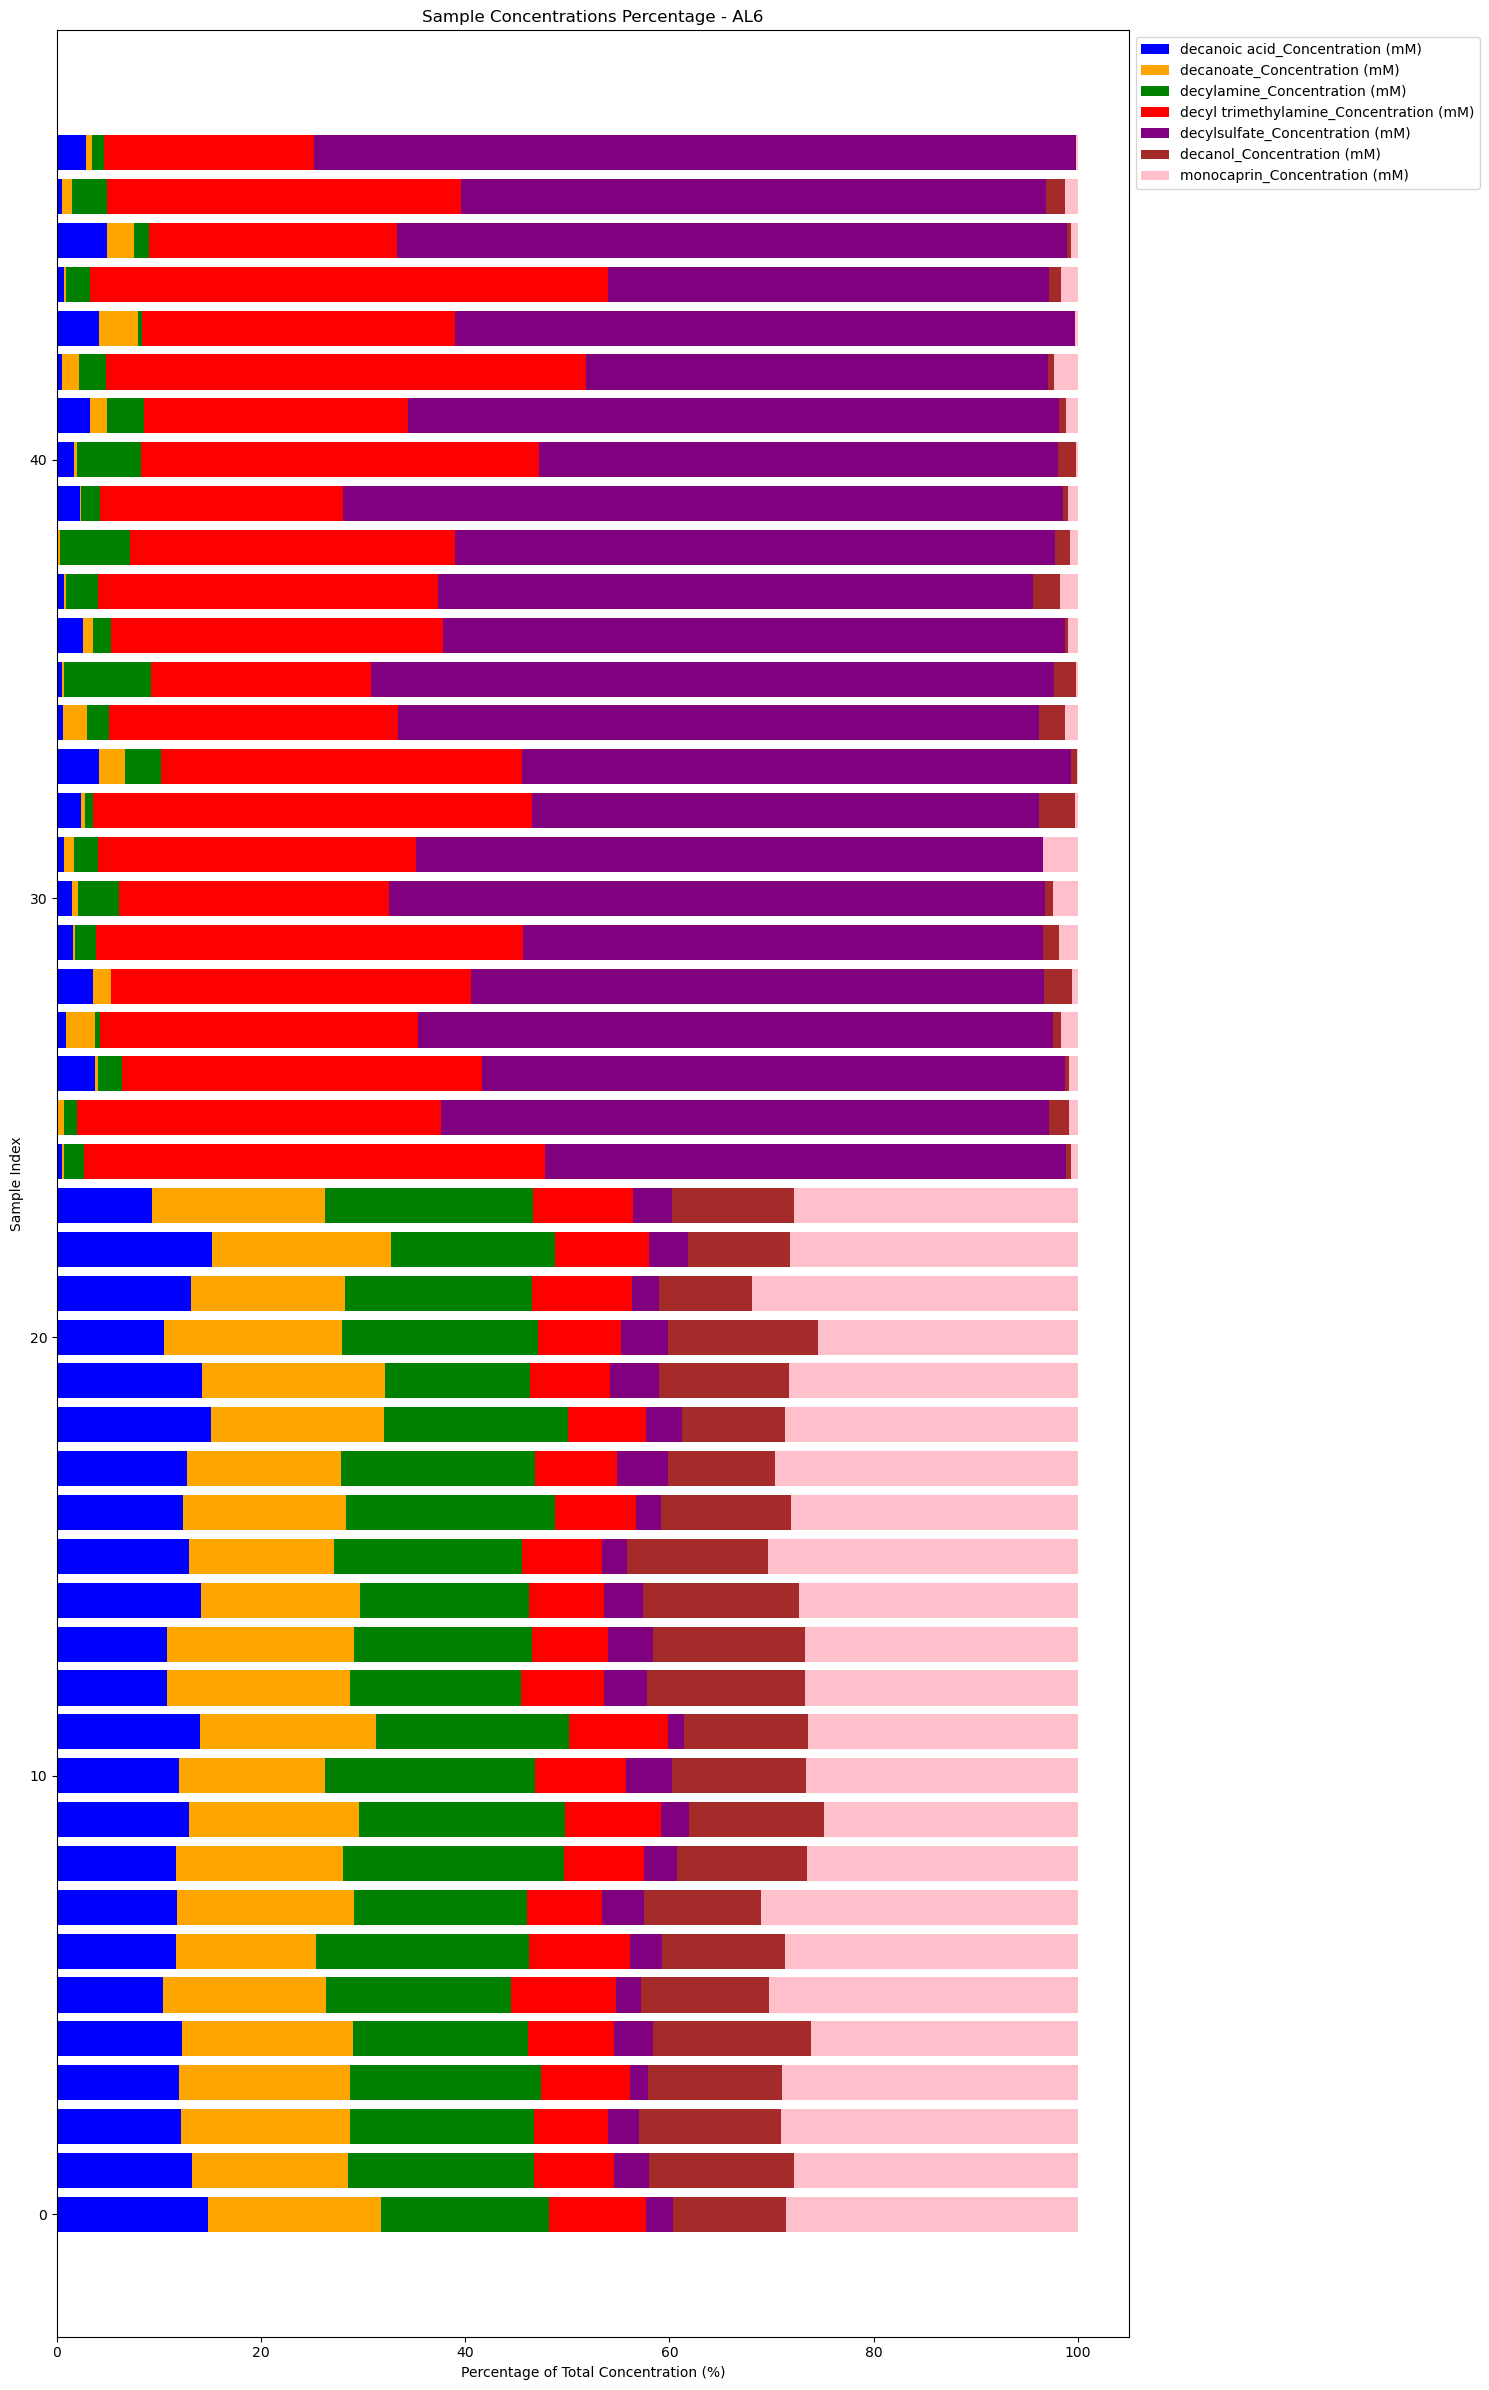

In [77]:
# color_map = {
#     ('decanoic acid_Concentration (mM)',): 'blue',
#     ('decanoate_Concentration (mM)',): 'orange',
#     ('decylamine_Concentration (mM)',): 'green',
#     ('decyl trimethylamine_Concentration (mM)',): 'red',
#     ('decylsulfate_Concentration (mM)',): 'purple',
#     ('decanol_Concentration (mM)',): 'brown',
#     ('monocaprin_Concentration (mM)',): 'pink'
# }

color_map = {
    'decanoic acid_Concentration (mM)': 'blue',
    'decanoate_Concentration (mM)': 'orange',
    'decylamine_Concentration (mM)': 'green',
    'decyl trimethylamine_Concentration (mM)': 'red',
    'decylsulfate_Concentration (mM)': 'purple',
    'decanol_Concentration (mM)': 'brown',
    'monocaprin_Concentration (mM)': 'pink'
}

# Function to plot horizontal bars for each sample with percentages
def plot_samples_percentage(df, title, color_map):
    num_samples = df.shape[0]
    features = df.columns

    plt.figure(figsize=(15, num_samples * 0.5))

    for i in range(num_samples):
        sample = df.iloc[i, :]
        total_concentration = sample.sum()
        left = 0
        for feature in features:
            percentage = (sample[feature] / total_concentration) * 100
            plt.barh(i, percentage, left=left, color=color_map[feature], label=feature if i == 0 else "")
            left += percentage

    plt.xlabel('Percentage of Total Concentration (%)')
    plt.ylabel('Sample Index')
    plt.title(title)
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
    plt.tight_layout()
    plt.show()

# Create a list of DataFrames
dfs = [df1, df2, df3, df4, df5, df6, df7]

# Loop through each DataFrame and plot the samples
for i, df in enumerate(dfs):
    title = f'Sample Concentrations Percentage - AL{i}'
    plot_samples_percentage(df.drop('num_vesicles', axis=1), title, color_map)


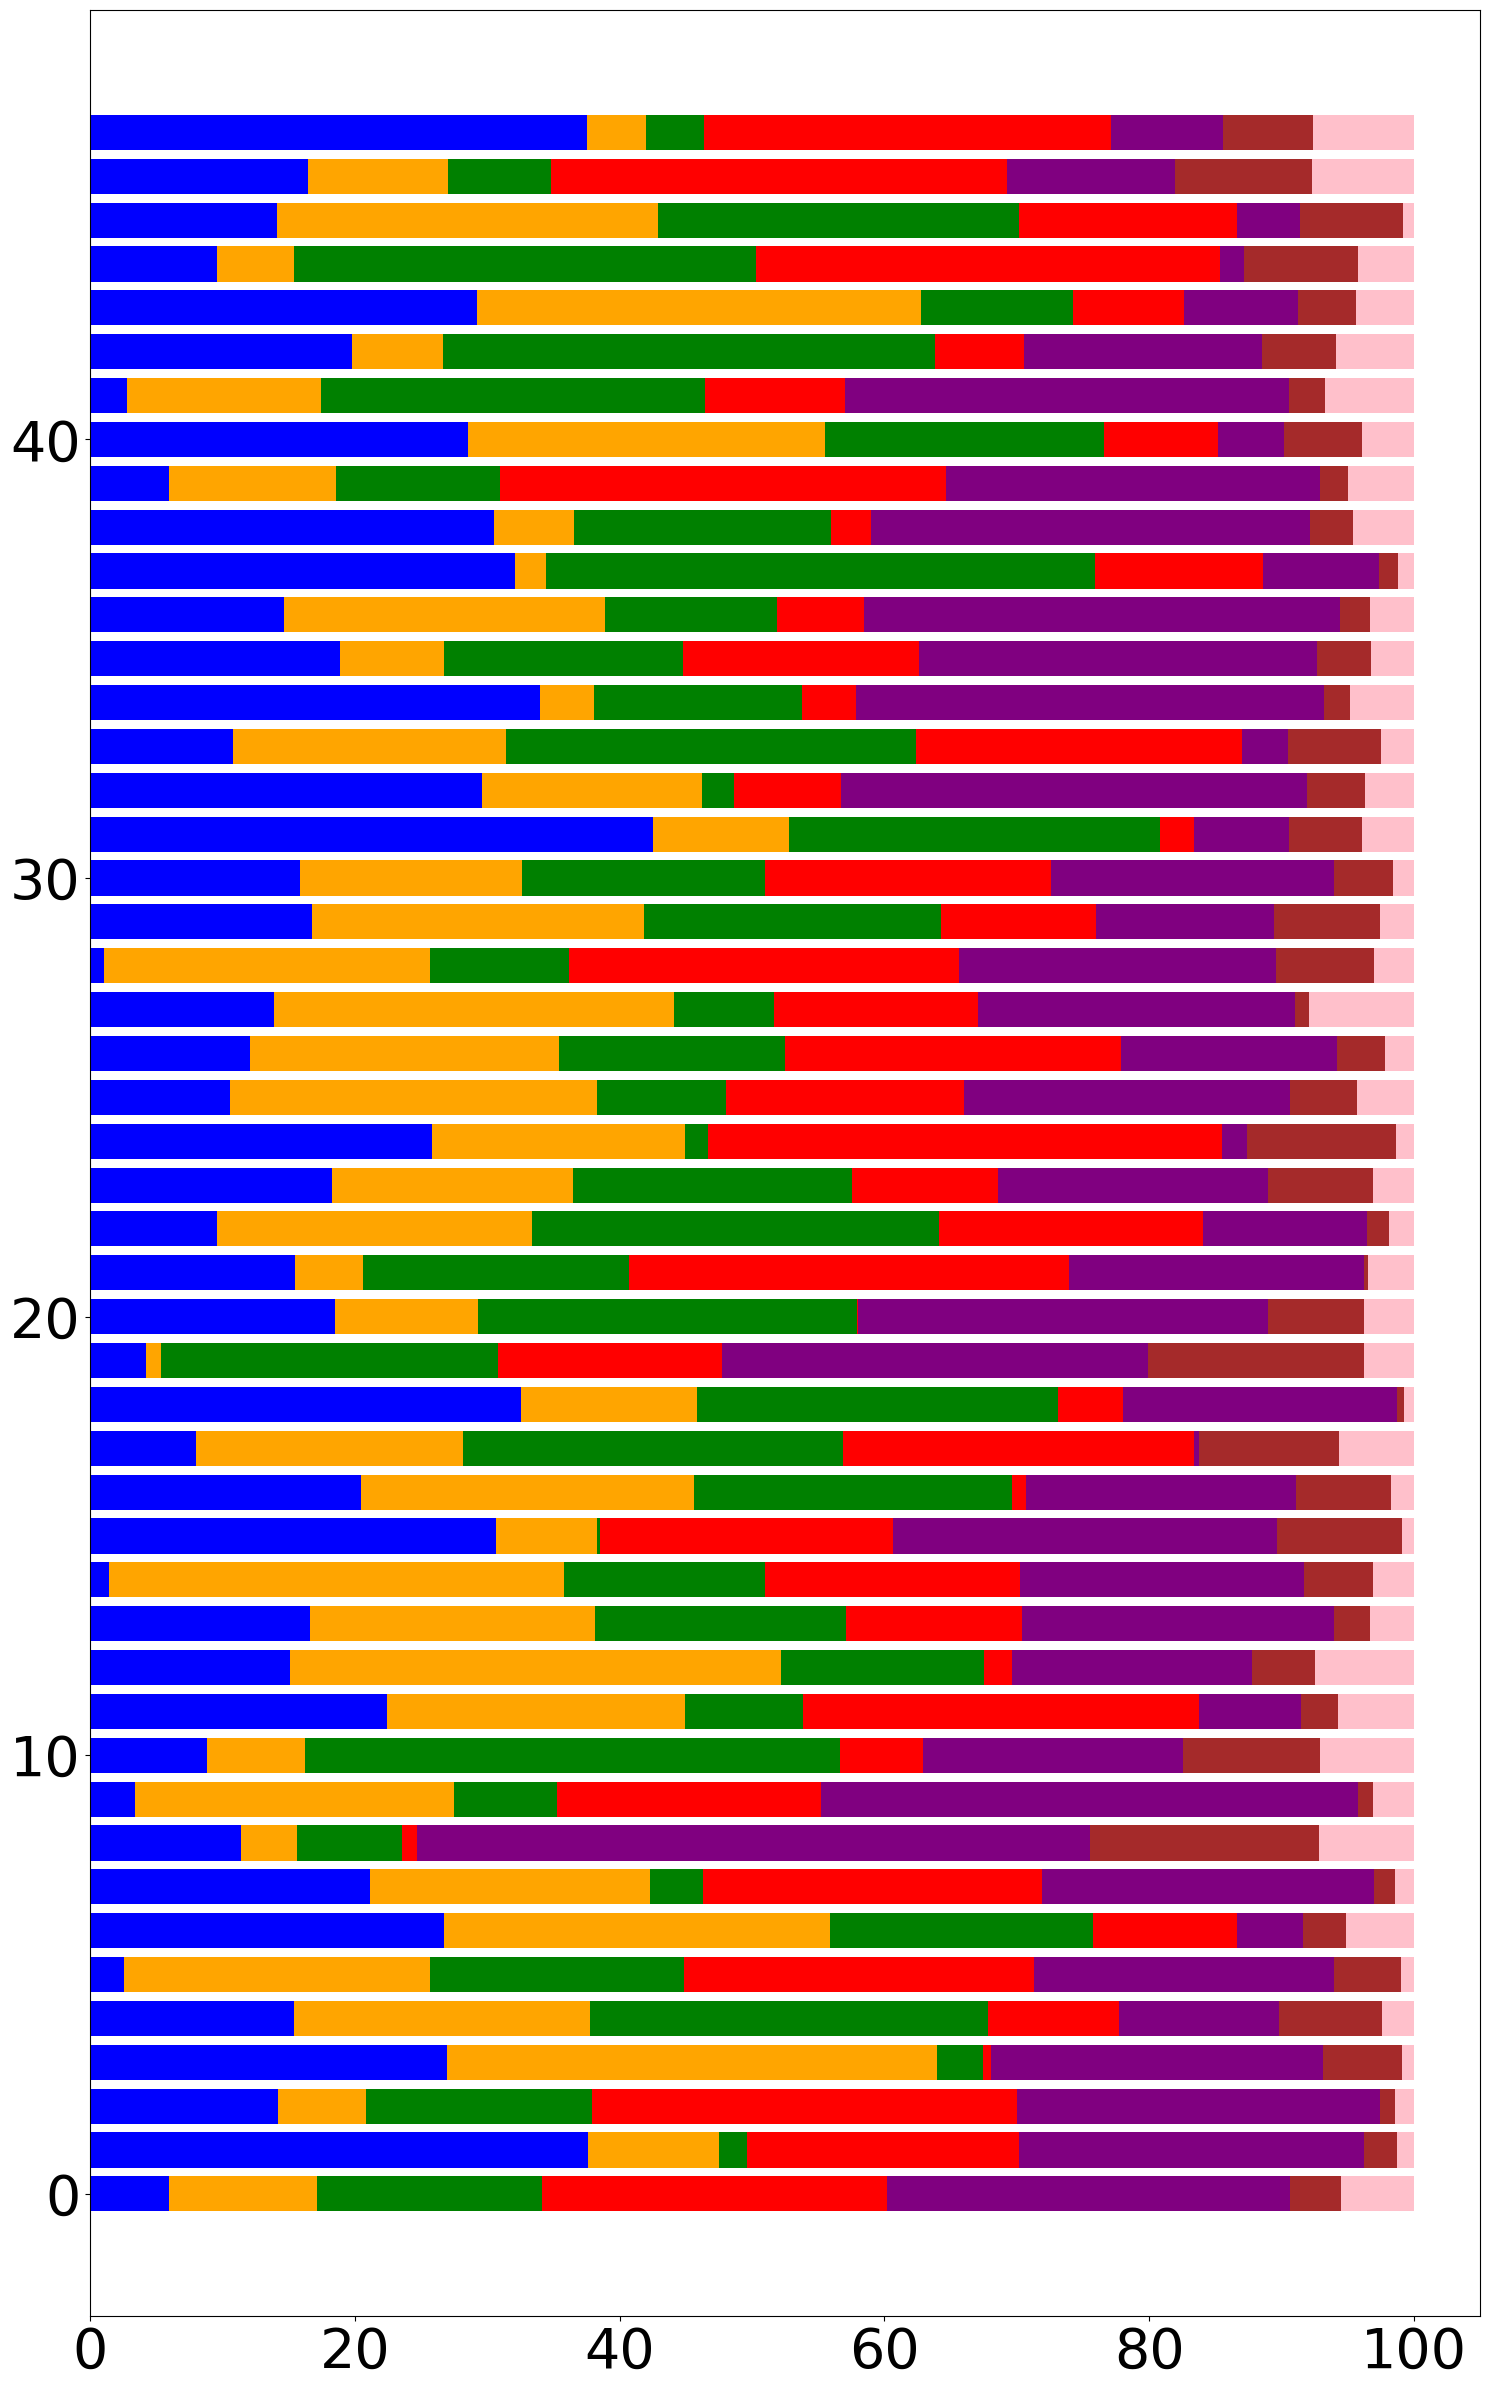

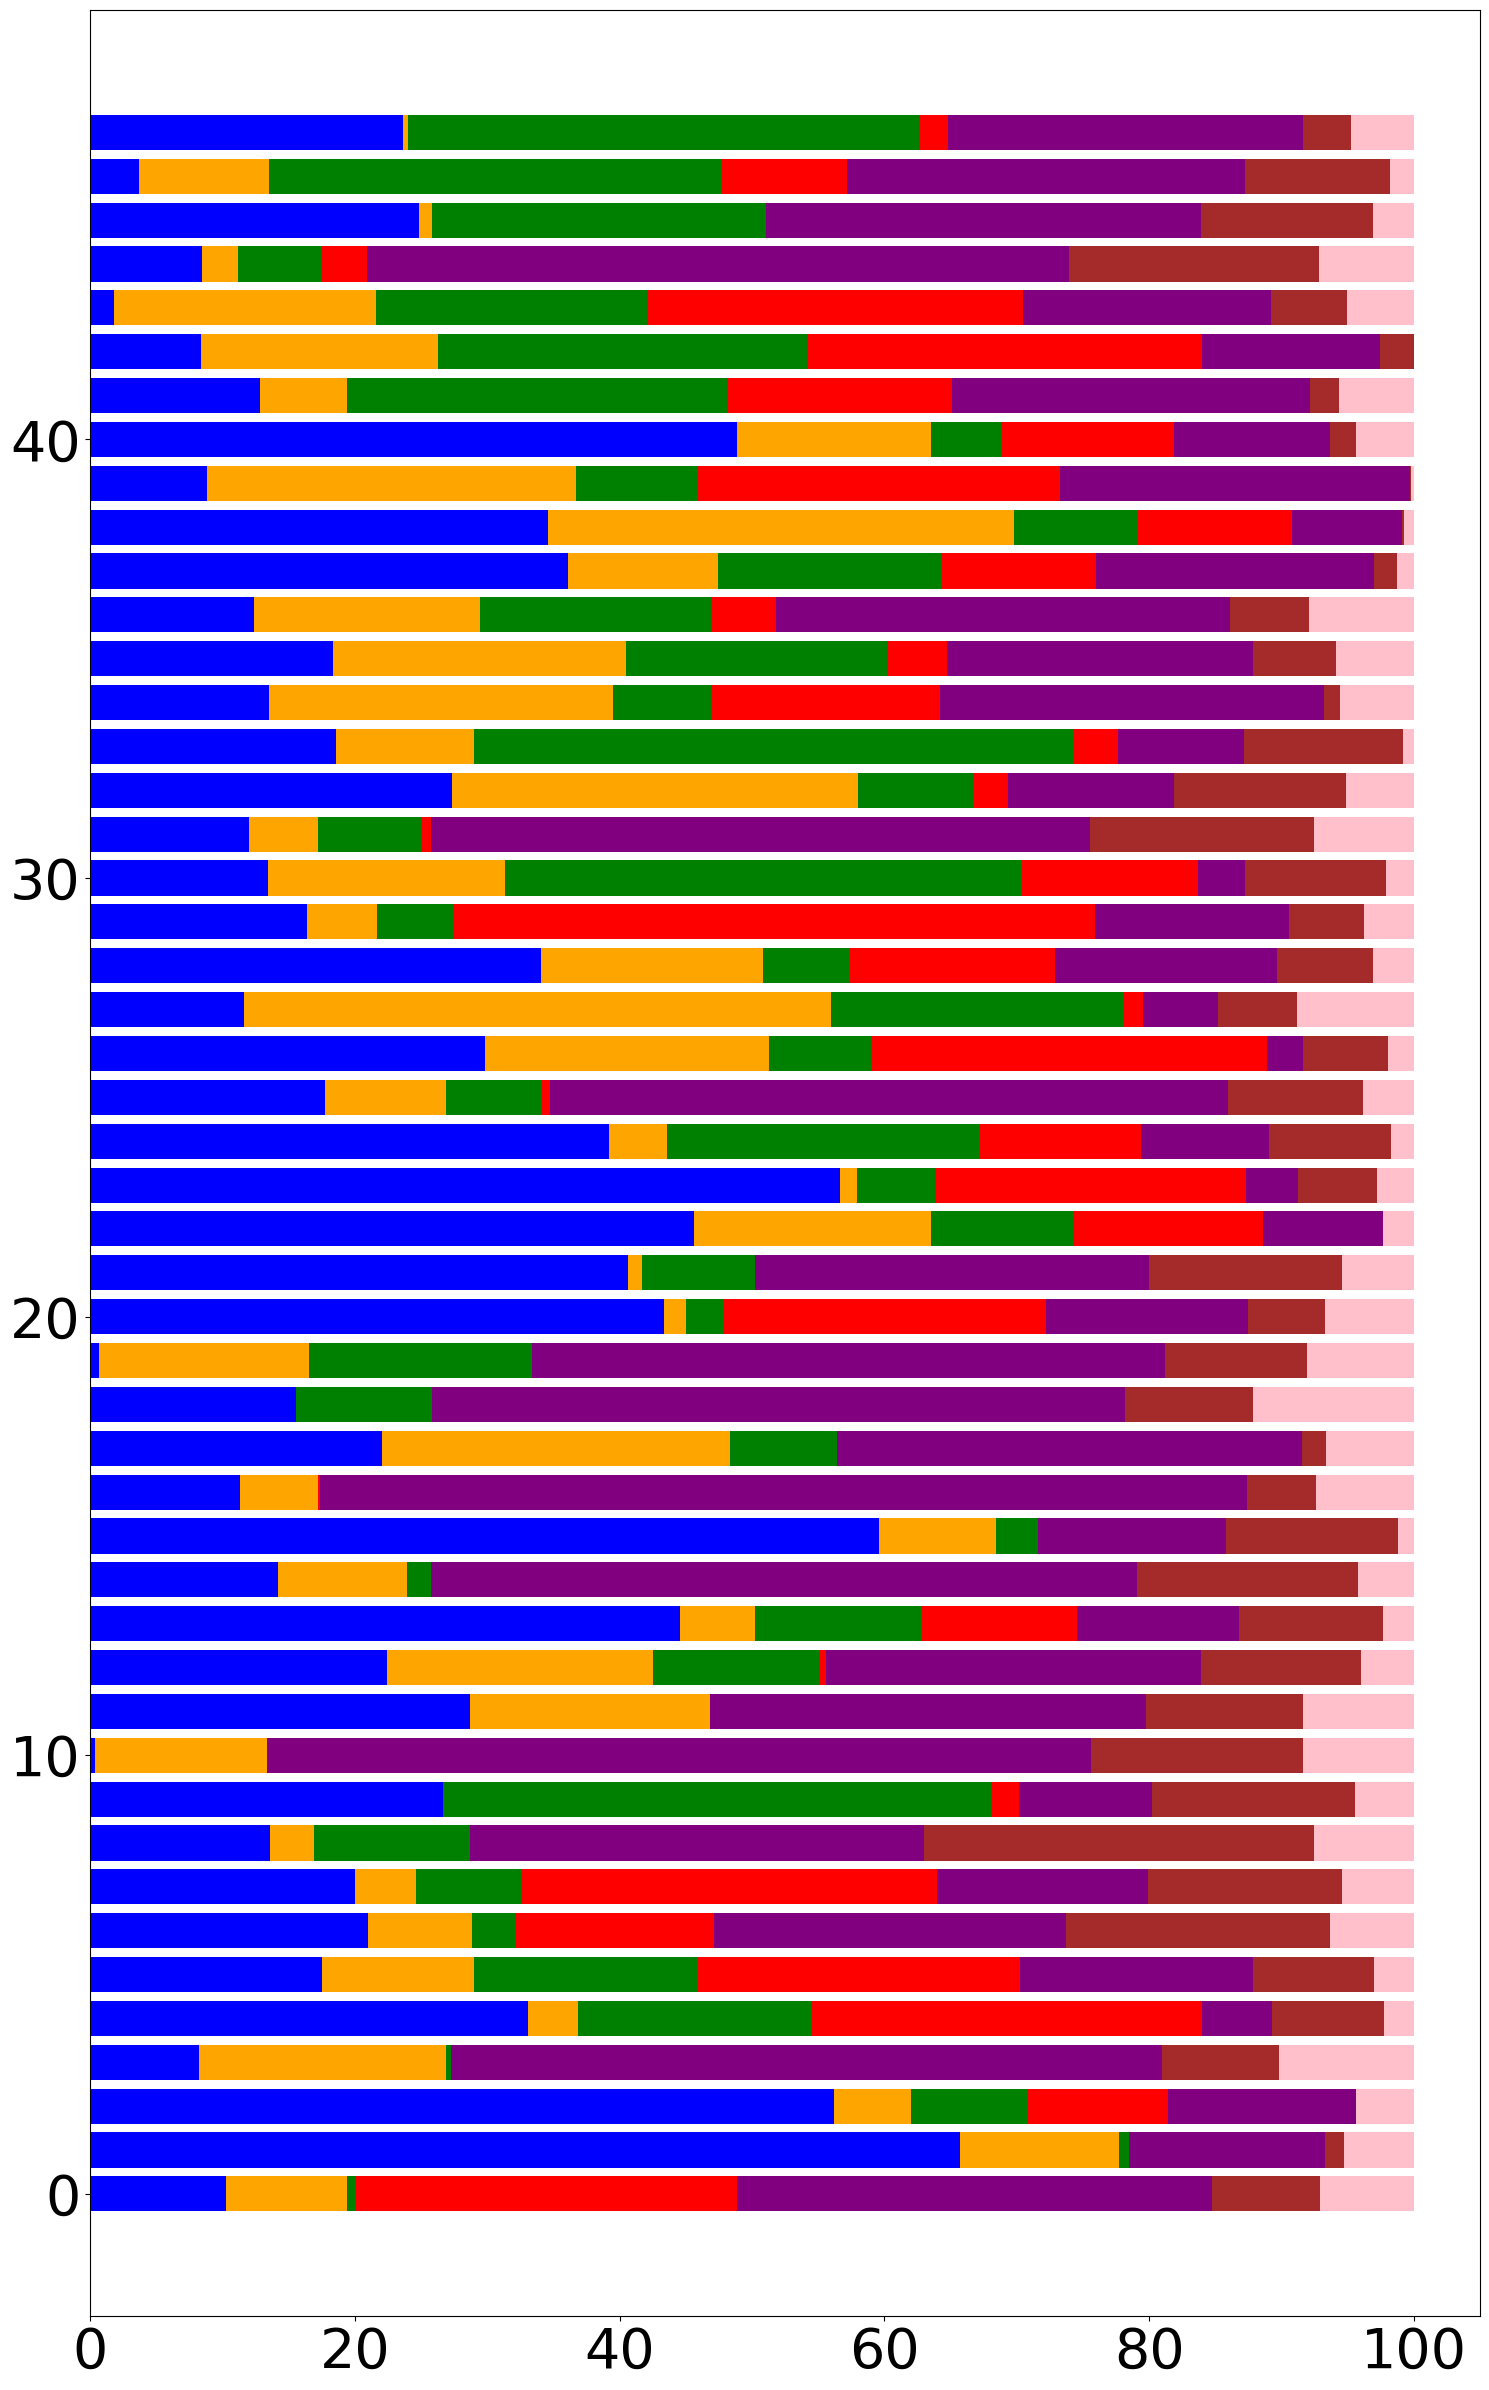

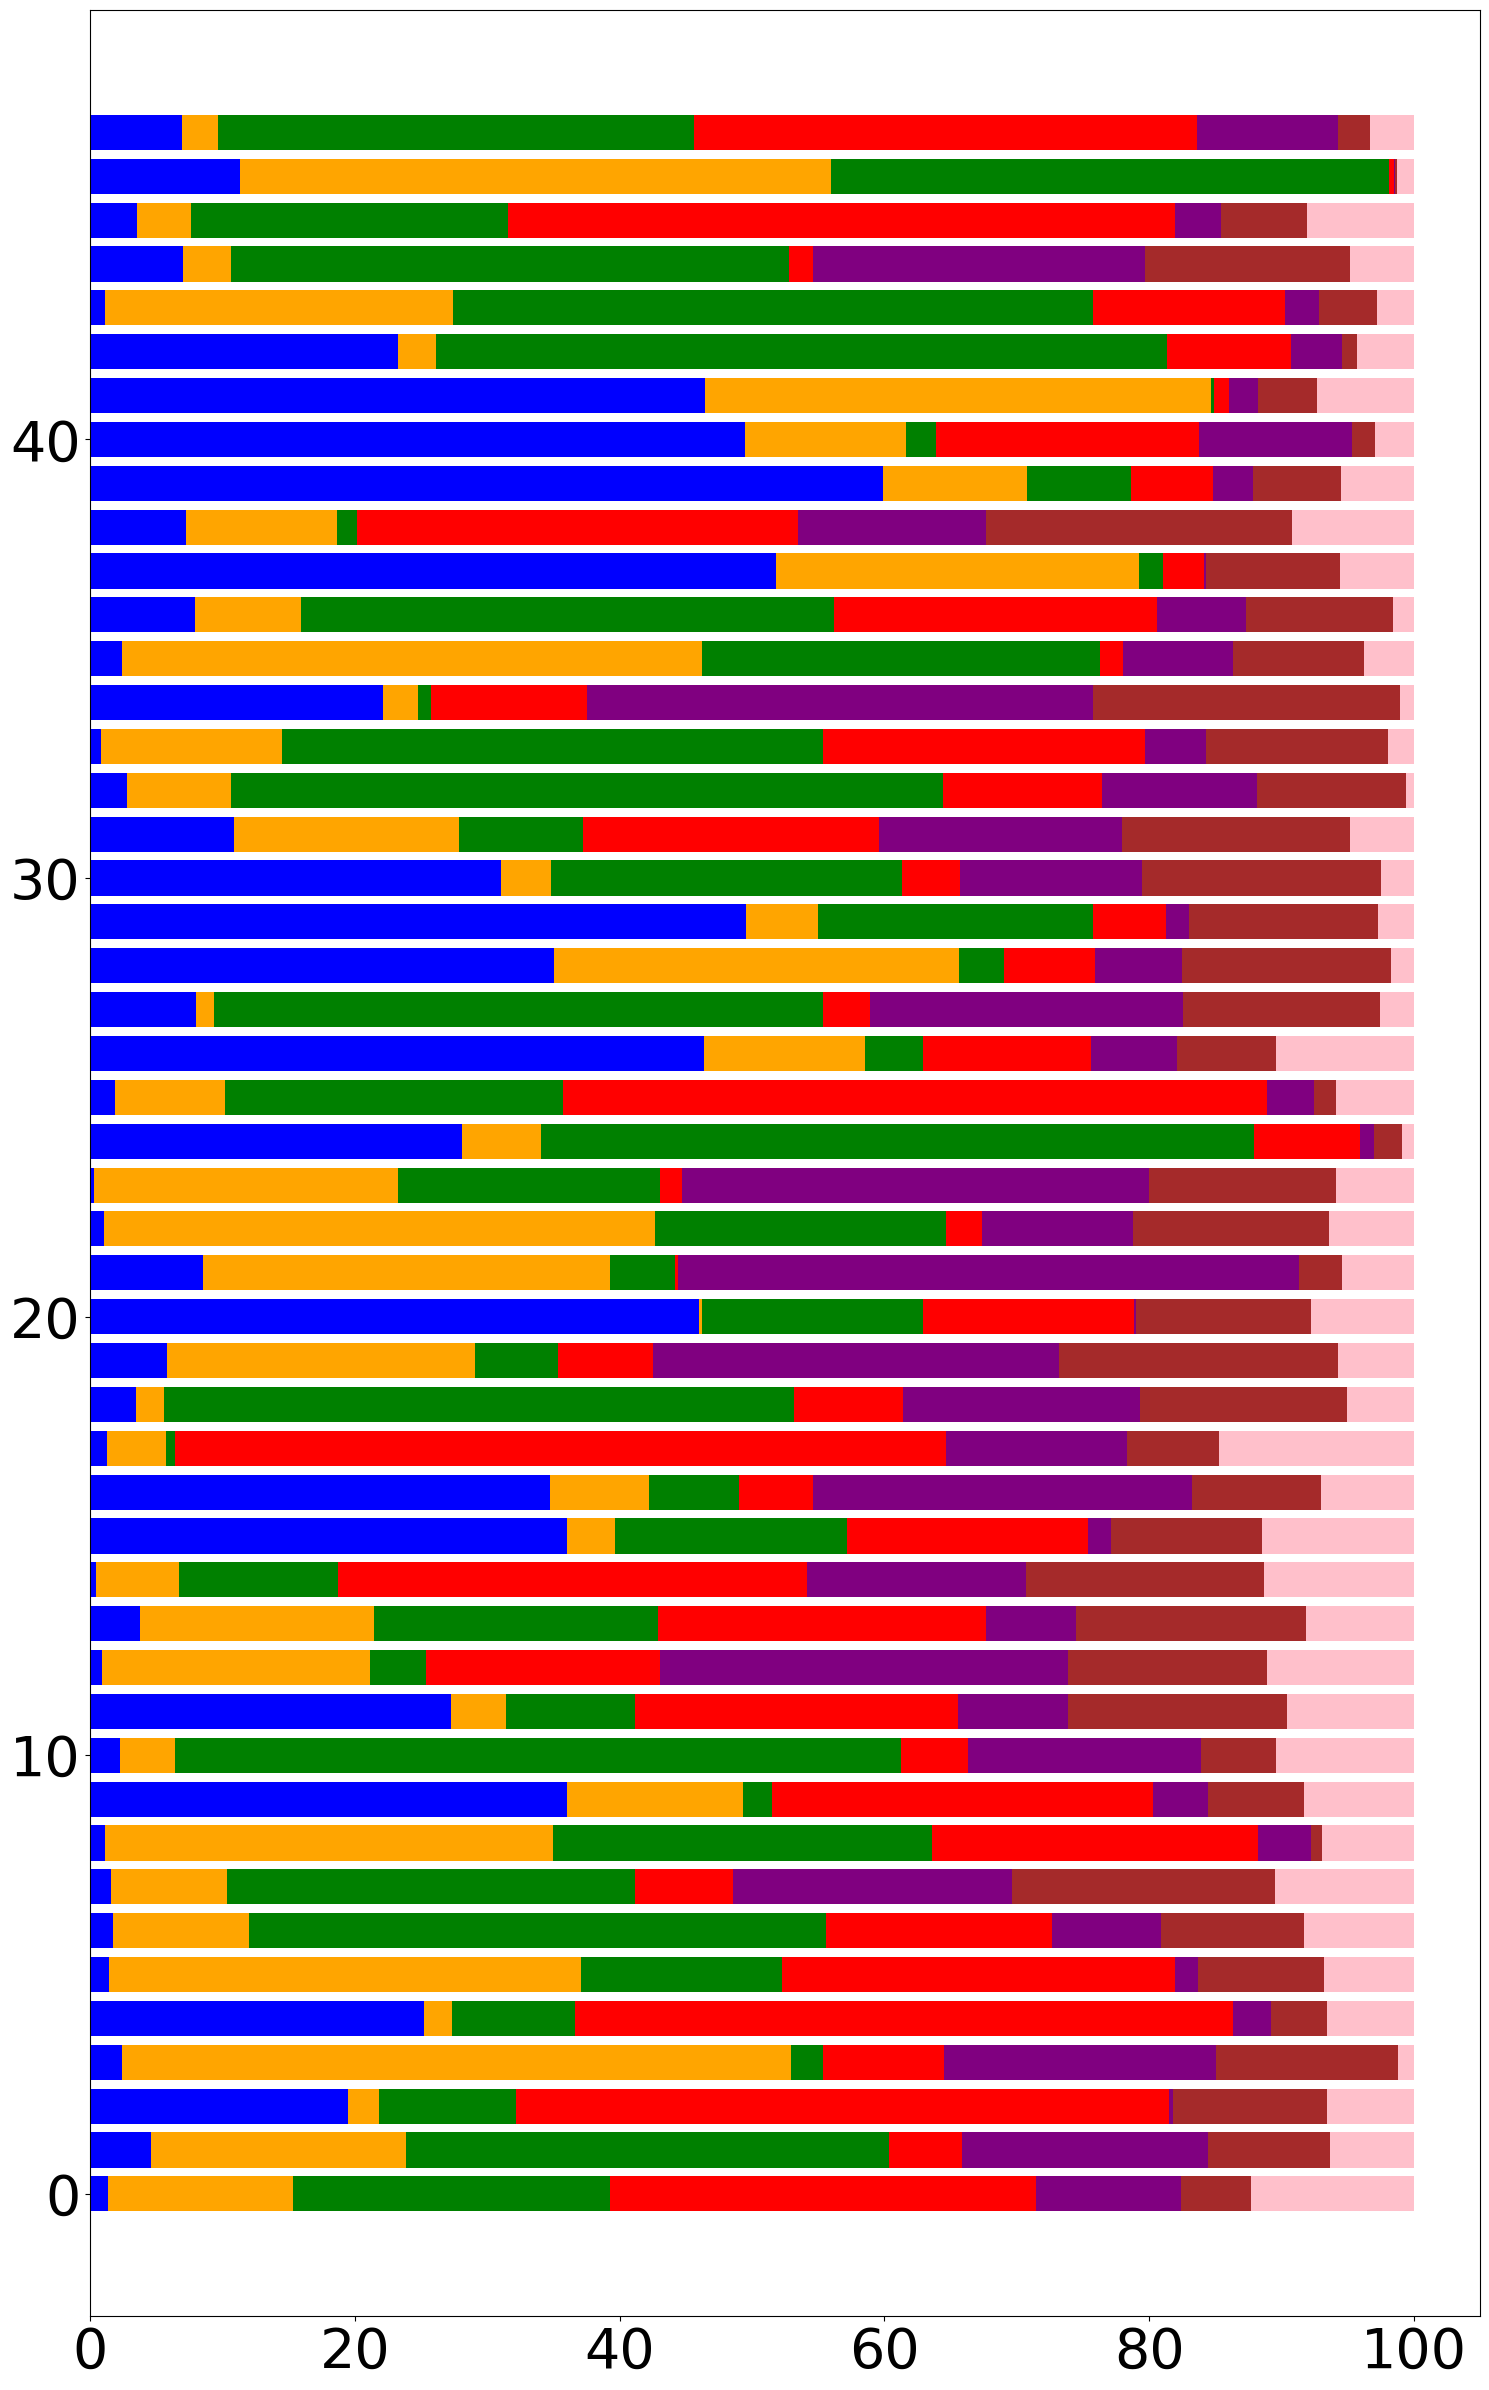

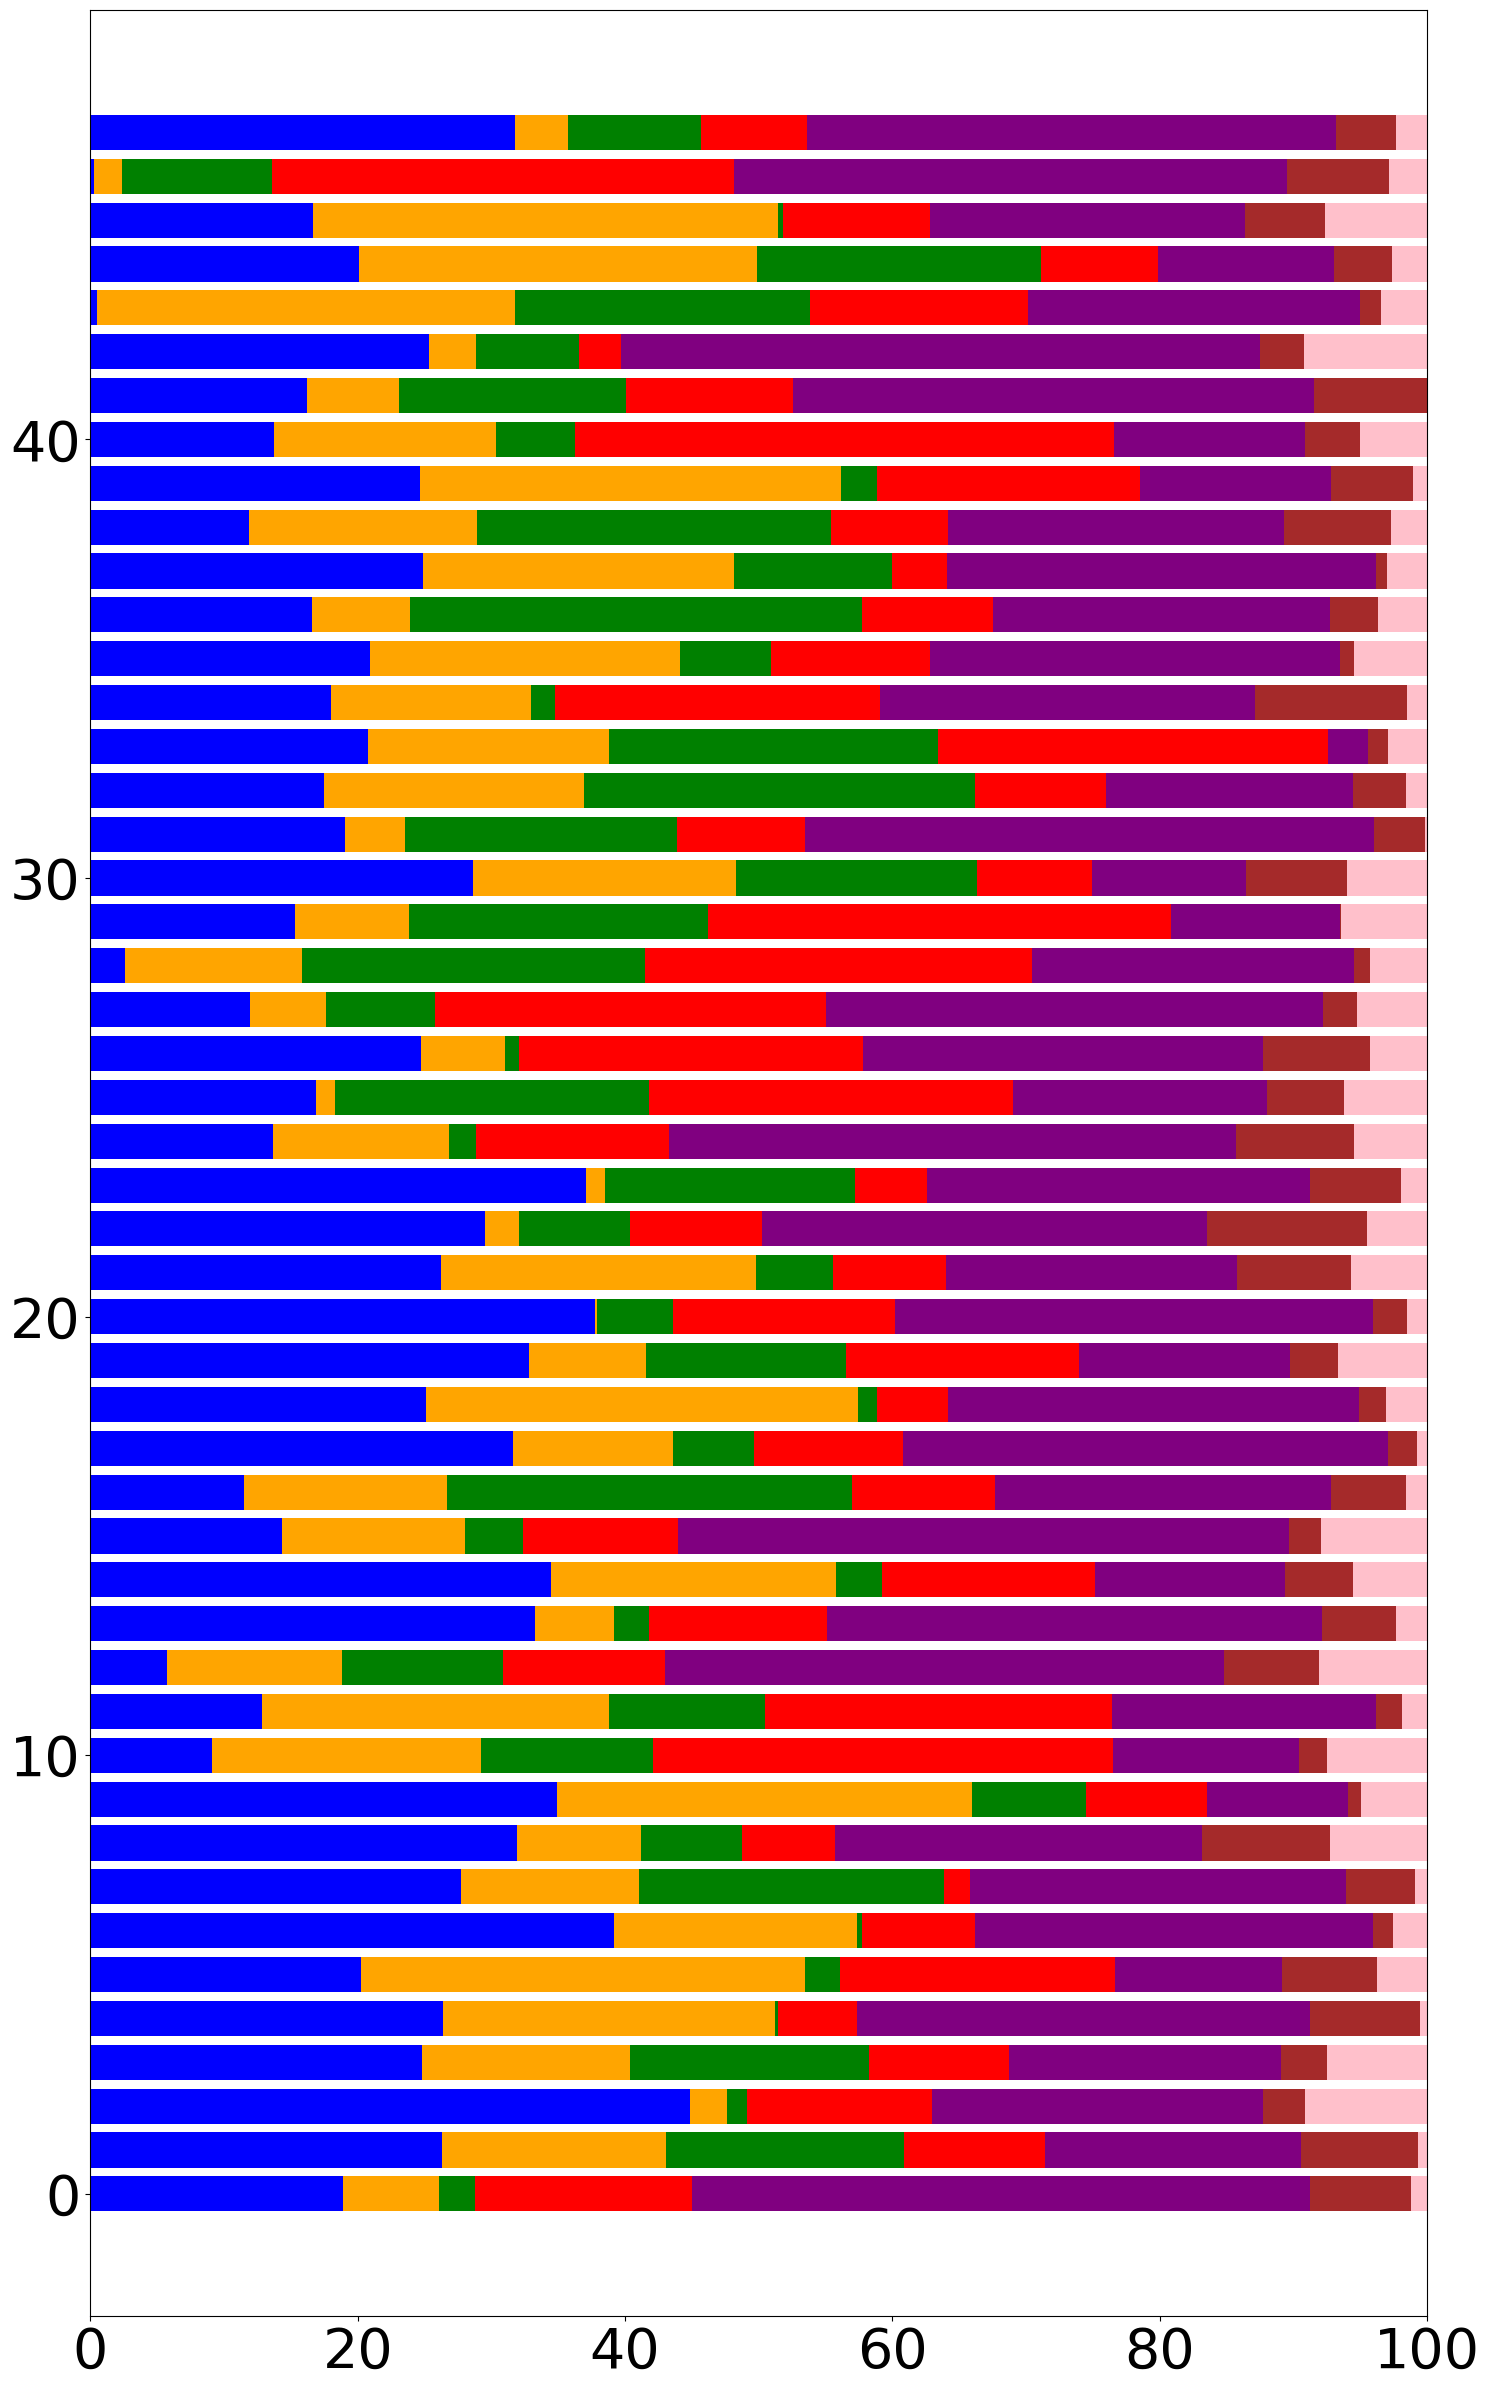

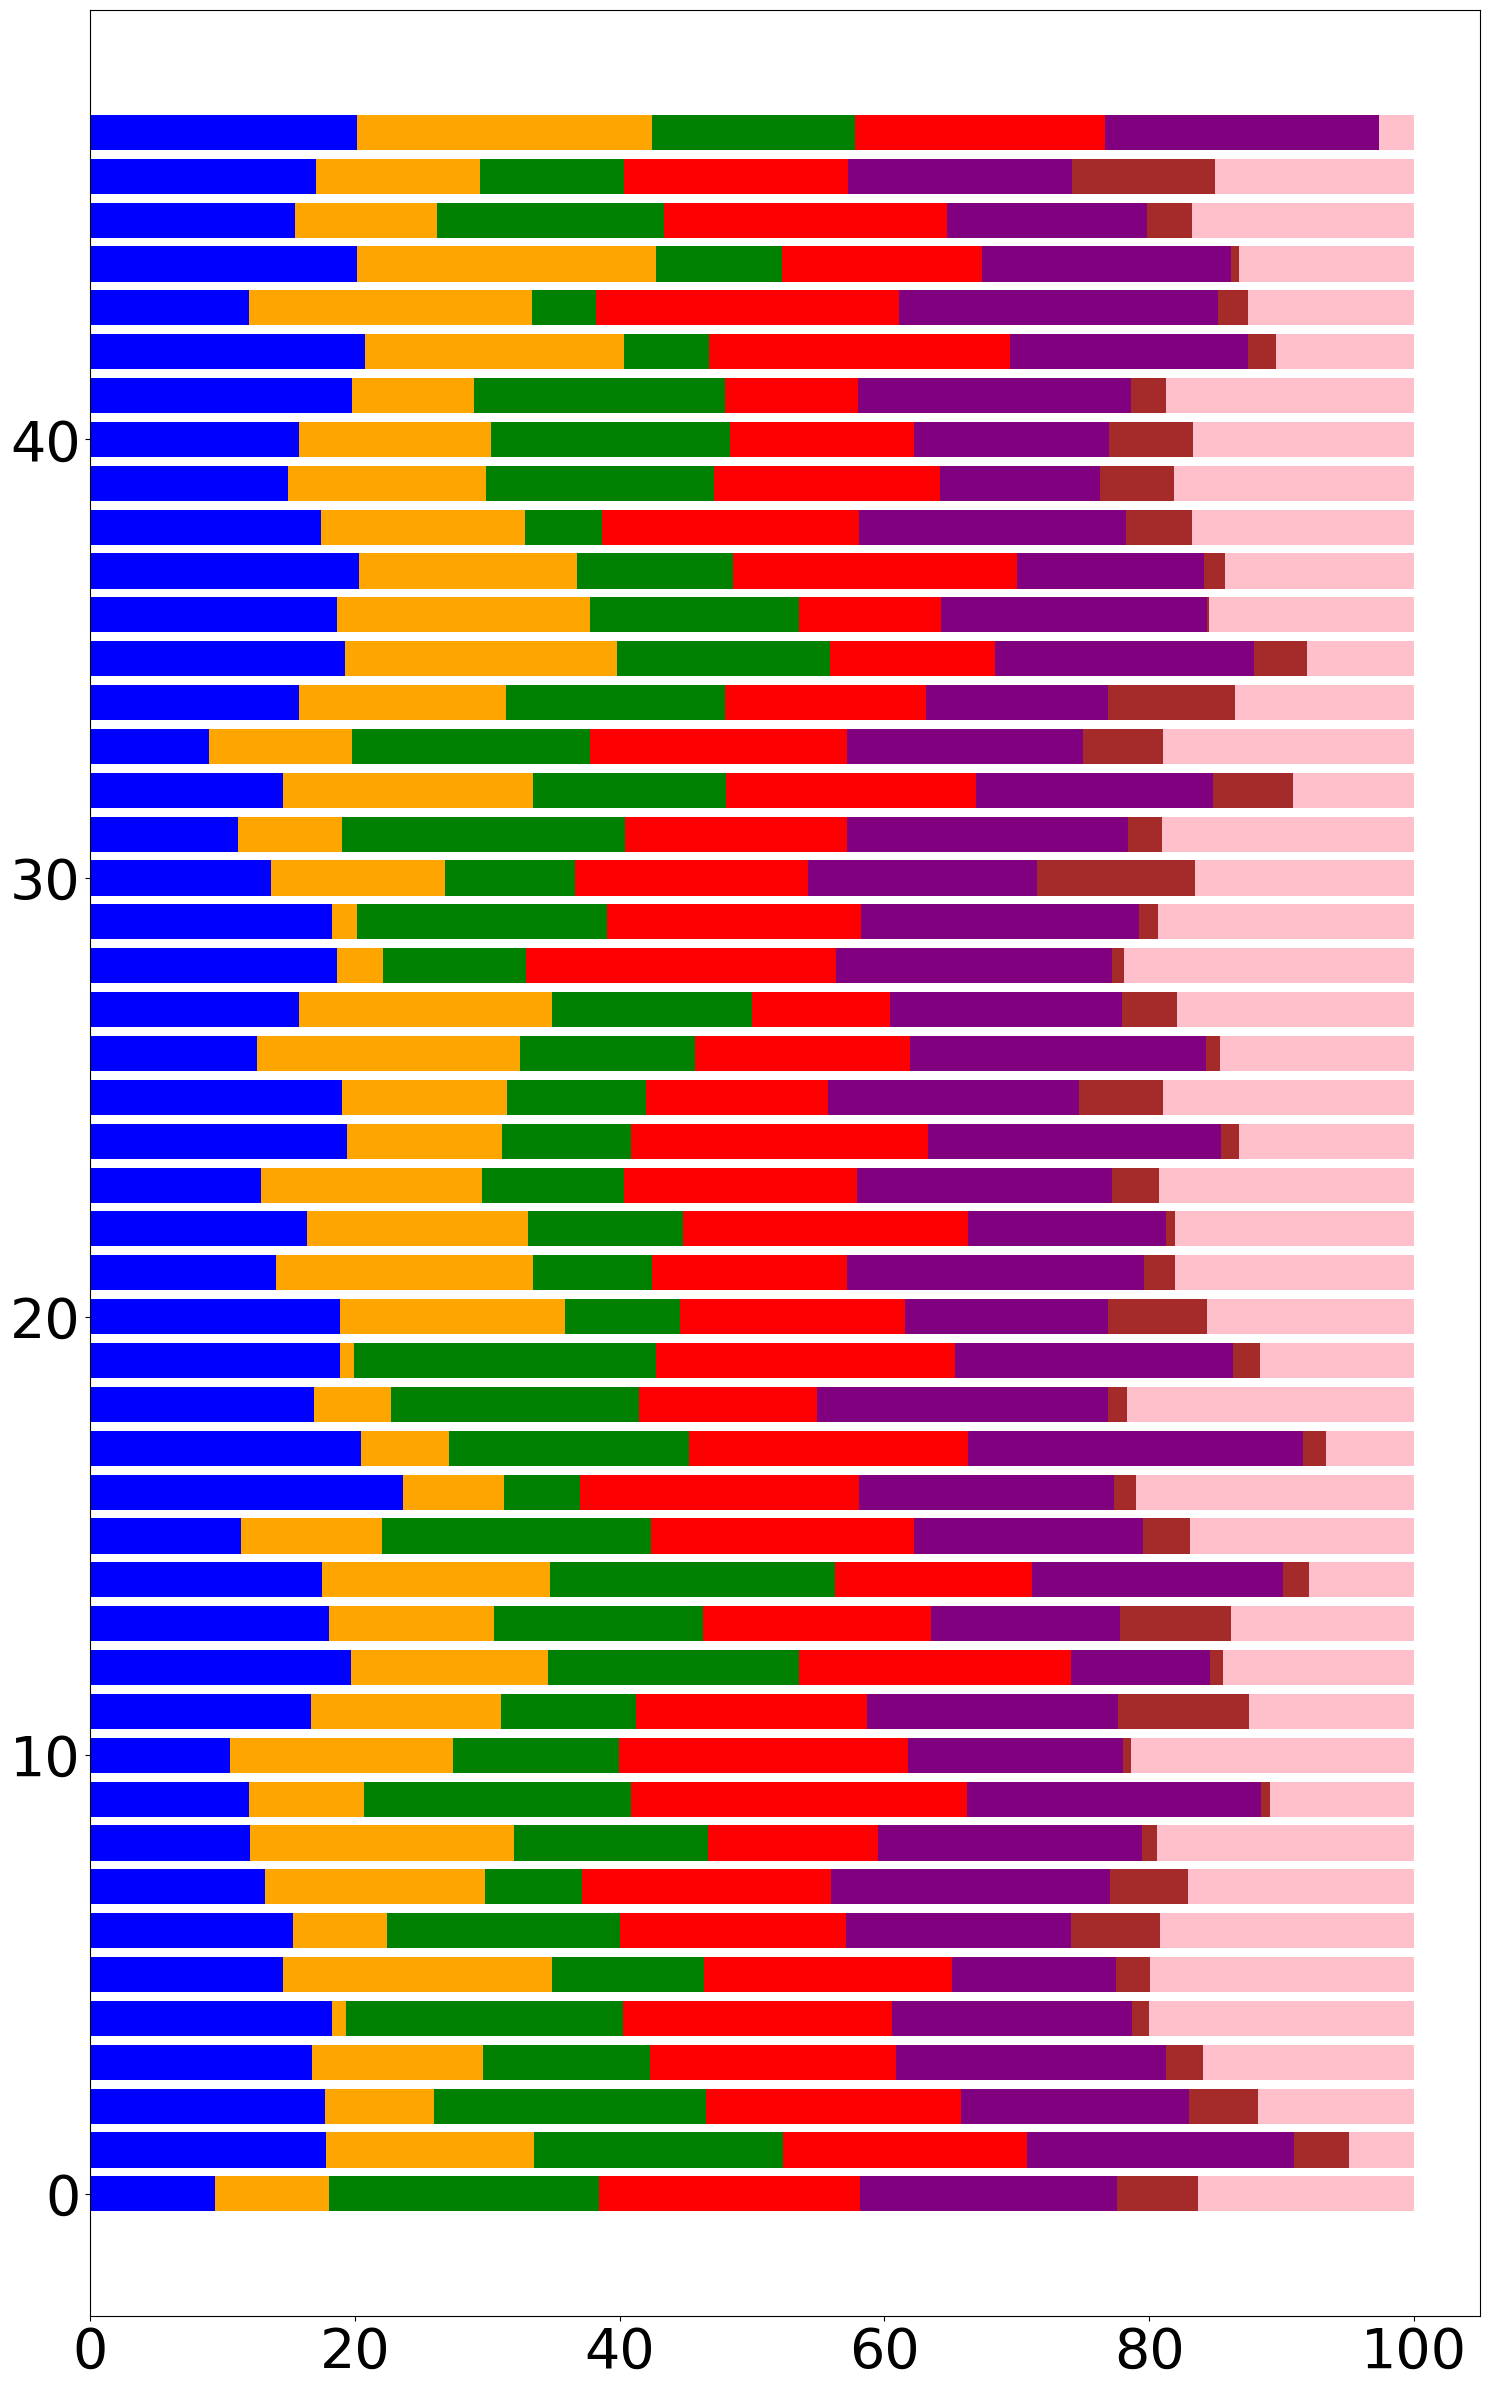

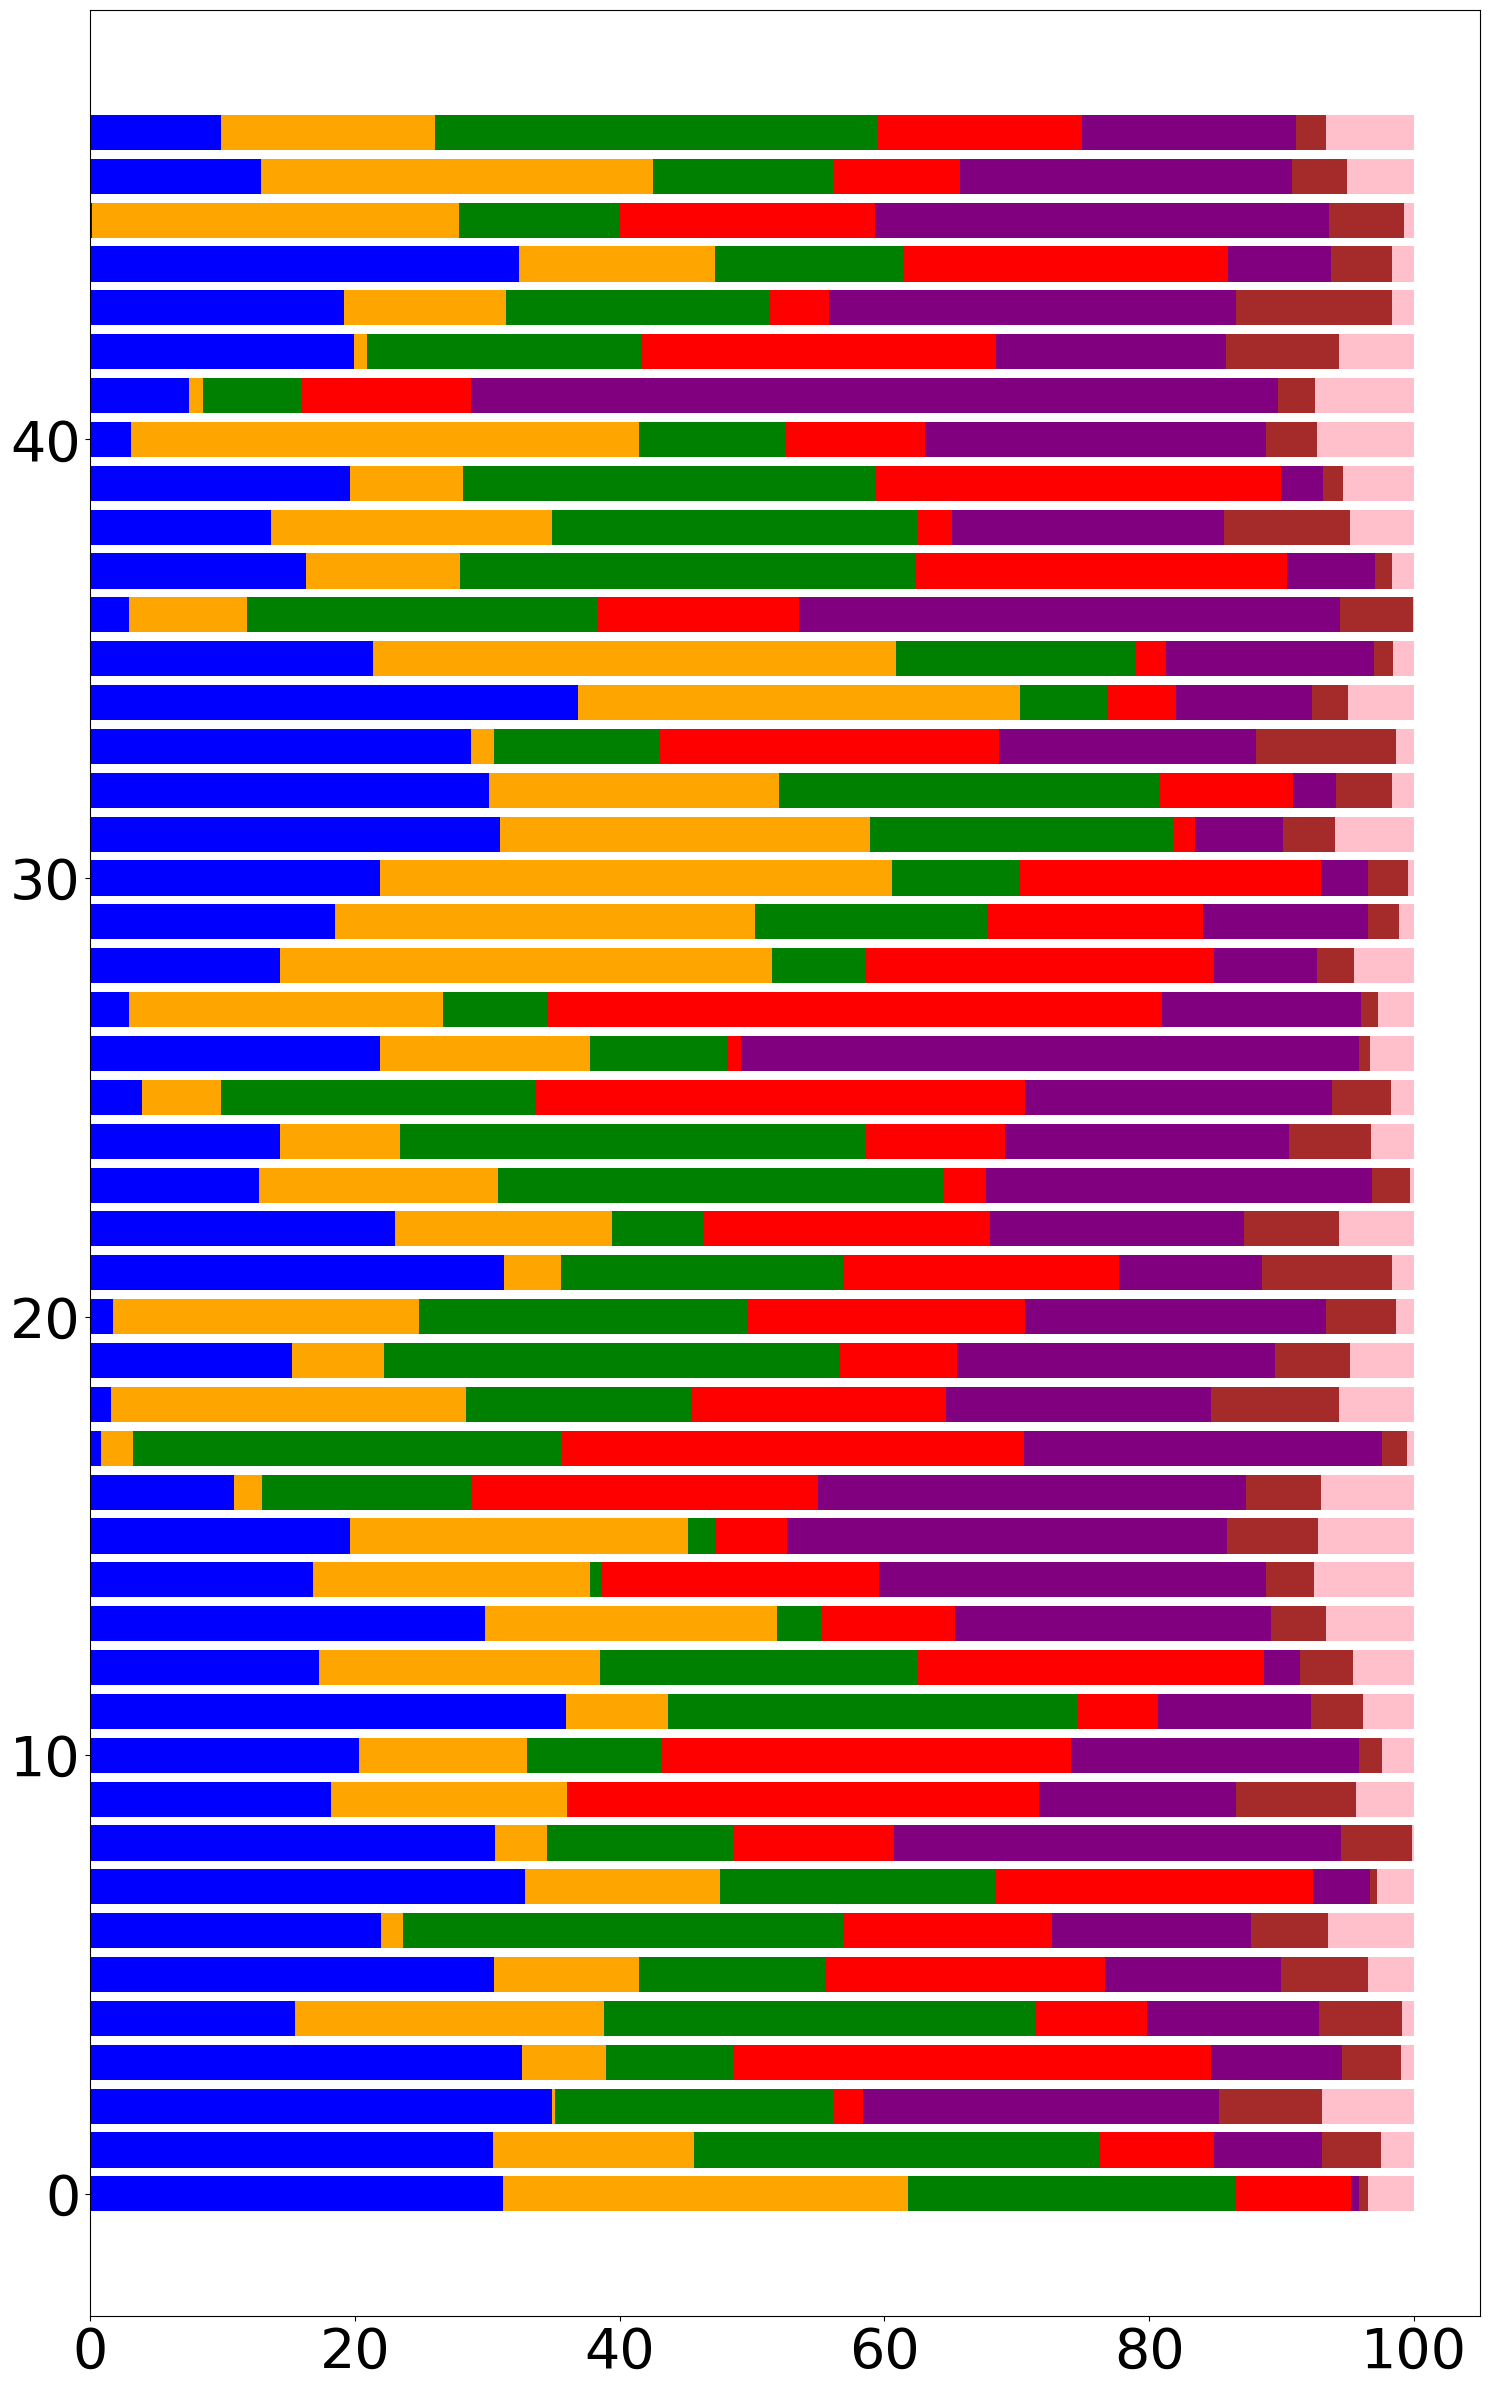

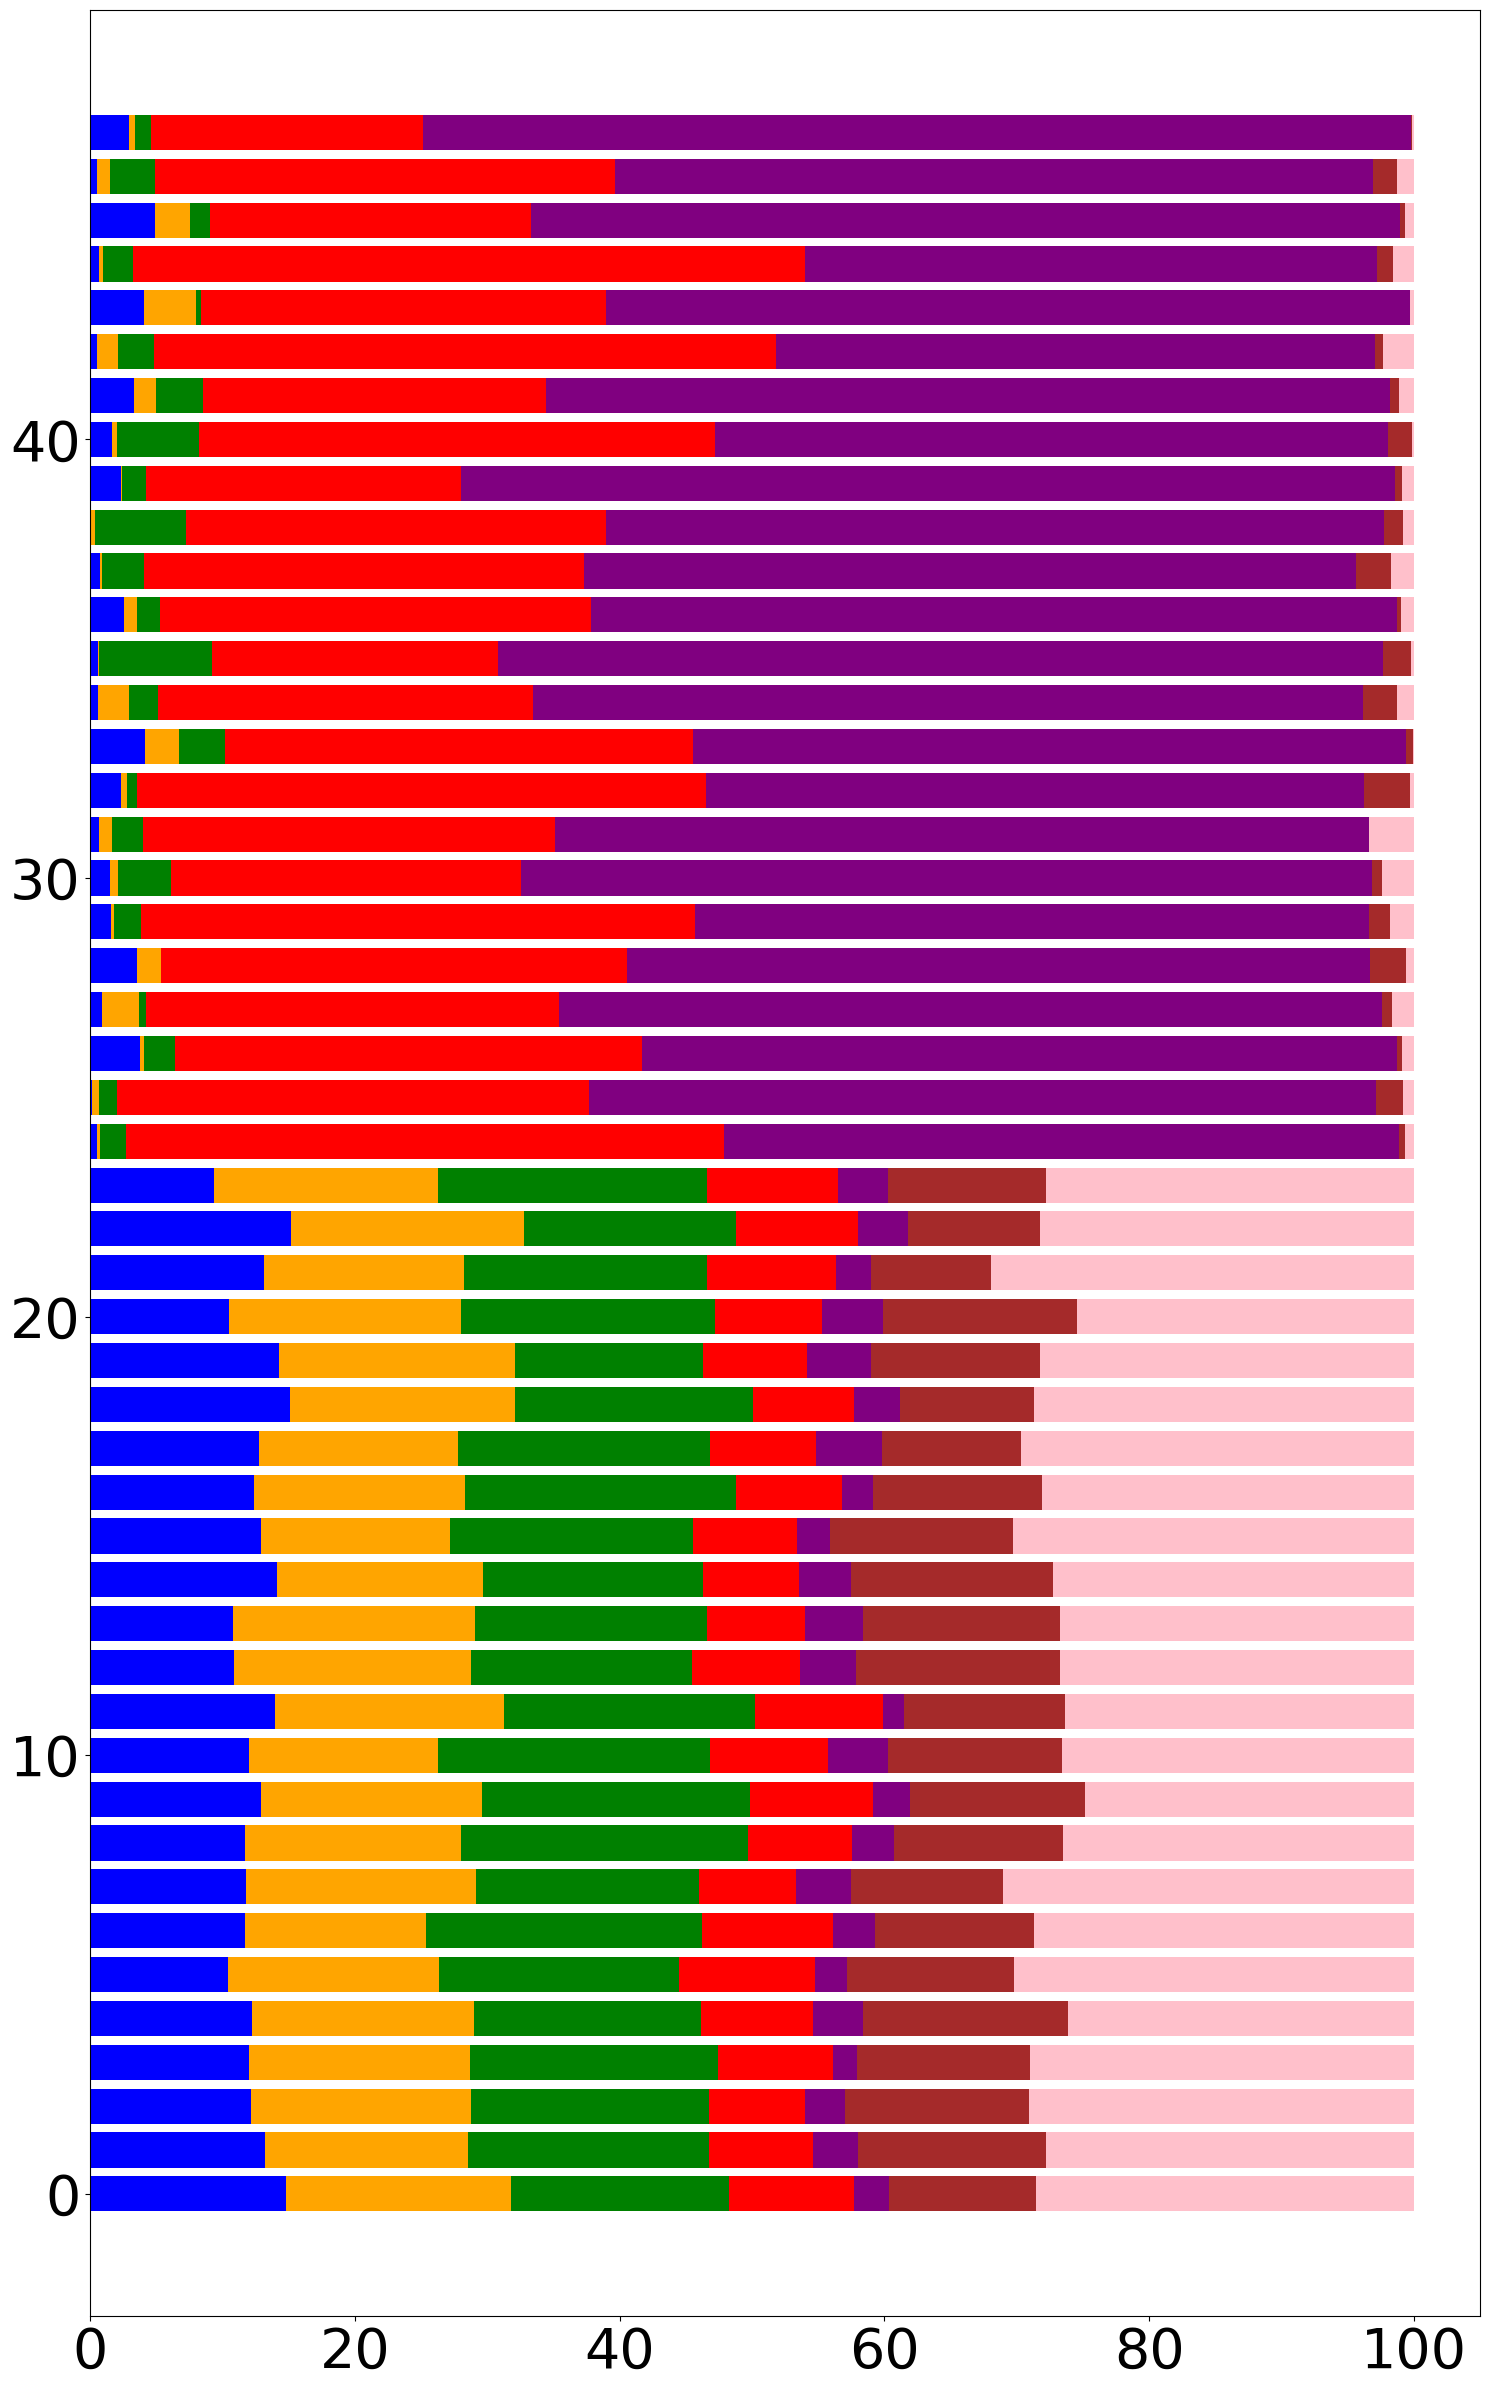

In [250]:
path = 'PaperFig/'
# color_map = {
#     ('decanoic acid_Concentration (mM)',): 'blue',
#     ('decanoate_Concentration (mM)',): 'orange',
#     ('decylamine_Concentration (mM)',): 'green',
#     ('decyl trimethylamine_Concentration (mM)',): 'red',
#     ('decylsulfate_Concentration (mM)',): 'purple',
#     ('decanol_Concentration (mM)',): 'brown',
#     ('monocaprin_Concentration (mM)',): 'pink'
# }

color_map = {
    'decanoic acid_Concentration (mM)': 'blue',
    'decanoate_Concentration (mM)': 'orange',
    'decylamine_Concentration (mM)': 'green',
    'decyl trimethylamine_Concentration (mM)': 'red',
    'decylsulfate_Concentration (mM)': 'purple',
    'decanol_Concentration (mM)': 'brown',
    'monocaprin_Concentration (mM)': 'pink'
}

# Function to plot horizontal bars for each sample with percentages
def plot_samples_percentage(df, title, color_map):
    num_samples = df.shape[0]
    features = df.columns

    plt.figure(figsize=(15, num_samples * 0.5))

    for i in range(num_samples):
        sample = df.iloc[i, :]
        total_concentration = sample.sum()
        left = 0
        for feature in features:
            percentage = (sample[feature] / total_concentration) * 100
            plt.barh(i, percentage, left=left, color=color_map[feature], label=feature if i == 0 else "")
            left += percentage

    # plt.xlabel('Percentage of Total Concentration (%)', fontsize=20)
    # plt.ylabel('Sample Index', fontsize=20)
    plt.xticks(fontsize=40)
    plt.yticks(fontsize=40)
    # plt.title(title)
    # plt.legend(loc='upper left', bbox_to_anchor=(1, 1), fontsize=16)
    plt.tight_layout()
    plt.savefig(path+f"{title}.pdf", dpi=600, bbox_inches='tight', format='pdf')
    plt.show()

# Create a list of DataFrames
dfs = [df1, df2, df3, df4, df5, df6, df7]

# Loop through each DataFrame and plot the samples
for i, df in enumerate(dfs):
    title = f'Sample_Concentrations_Percentage - AL{i}'
    plot_samples_percentage(df.drop('num_vesicles', axis=1), title, color_map)


In [ ]:
# Use the current model to do prediction

In [32]:
valid_samples3 = np.load('valid_samples3.npy')
df_sample3 = pd.DataFrame(valid_samples3, columns=[df_input_update.iloc[:,0:7].columns])
pred_probs3 = cal_prob(df_sample3, model, batch_size=100000)

Running time: 57.989850997924805 seconds


(array([3.960854e+06, 4.172260e+06, 1.364163e+06, 3.528690e+05,
        9.784500e+04, 3.345200e+04, 1.260500e+04, 4.526000e+03,
        1.274000e+03, 1.520000e+02]),
 array([0.02194096, 0.10437201, 0.18680307, 0.26923412, 0.35166518,
        0.43409623, 0.51652729, 0.59895834, 0.6813894 , 0.76382045,
        0.84625151]),
 <BarContainer object of 10 artists>)

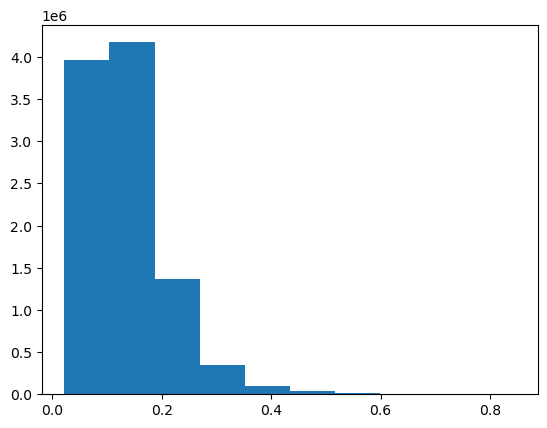

In [42]:
second_column = pred_probs3[:, 1]
plt.hist(second_column)

In [185]:
def plot_histogram(data, filename):
    '''
    data: The predicted probabilities array
    filename: The filename for saved figures, e.g. 'histogram_model.pdf'
    '''
    second_column = data[:, 1]
    # Create the histogram
    plt.figure(figsize=(12, 8))
    sns.histplot(second_column, bins=100, kde=False, color='royalblue')  # Increase the number of bins
    
    # Customize the plot
    plt.xlabel('Predicted Probabilities', fontsize=14)
    plt.ylabel('Frequency', fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    
    # Save the plot with high resolution
    plt.savefig(path+filename, format='pdf', dpi=600, bbox_inches='tight')
    
    # Show the plot
    plt.show()

/Users/haoliu/anaconda3/envs/ActiveLearning/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


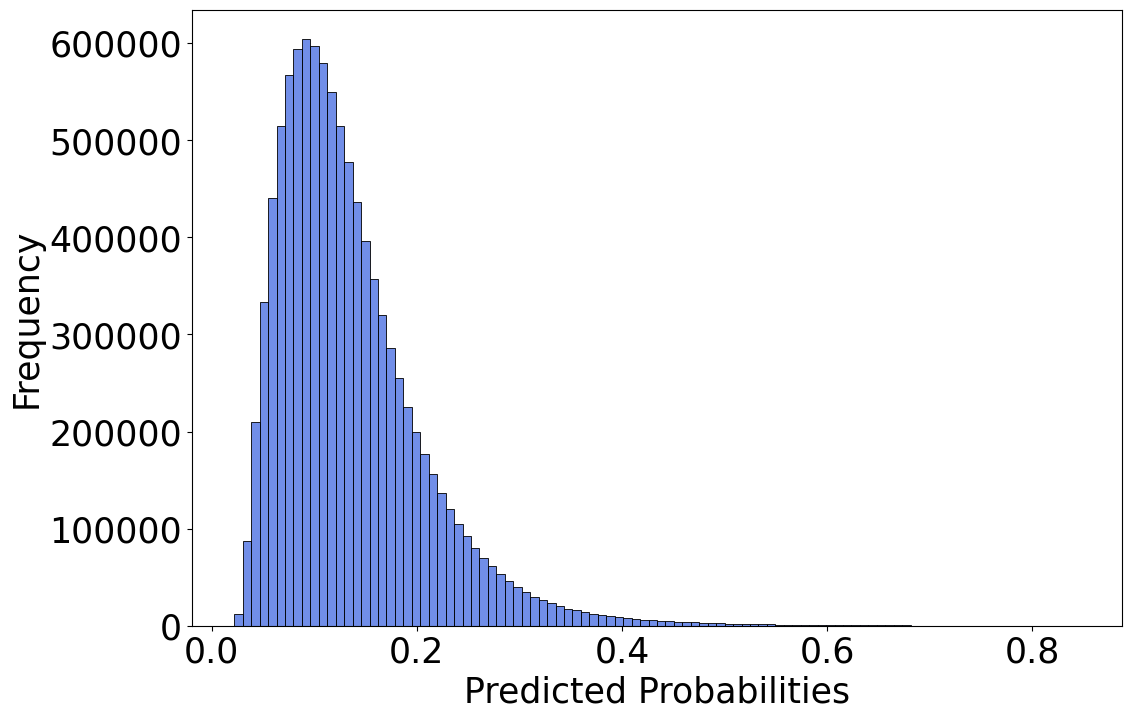

In [34]:
second_column = pred_probs3[:, 1]
# Create the histogram
plt.figure(figsize=(12, 8))
sns.histplot(second_column, bins=100, kde=False, color='royalblue')  # Increase the number of bins

# Customize the plot
plt.xlabel('Predicted Probabilities', fontsize=25)
plt.ylabel('Frequency', fontsize=25)
# plt.title('Histogram of Predicted Probabilities', fontsize=18)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)

# Save the plot with high resolution
plt.savefig(path+'histogram_model.pdf', format='pdf', dpi=600, bbox_inches='tight')

# Show the plot
plt.show()

In [251]:
pred_probs3[:,1].max()

0.8462515084548841

In [252]:
pred_probs3[:,1].min()

0.021940957426295427

In [50]:
transformed_samples3 = np.expm1(valid_samples3)
df_sample3 = pd.DataFrame(transformed_samples3, columns=[df_input_update.iloc[:,0:7].columns])

In [51]:
intervals = [
    (0.85, 0.7083),
    (0.7083, 0.5666),
    (0.5666, 0.4249),
    (0.4249, 0.2832),
    (0.2832, 0.1415),
    (0.1415, 0)
]

# Set the random seed
np.random.seed(42)
selected_samples_dfs = []

# Select 48 samples from each interval and store in DataFrames
for interval in intervals:
    start, end = interval
    # Filter probabilities within the current interval and get their indices
    interval_indices = np.where((pred_probs3[:, 1] <= start) & (pred_probs3[:, 1] > end))[0]
    
    # Ensure we have enough samples in the interval
    if len(interval_indices) >= 48:
        selected_indices = np.random.choice(interval_indices, 48, replace=False)
    else:
        selected_indices = interval_indices  # If less than 48, take all

    # Select samples from df_sample using the selected indices
    df_interval_samples = df_sample3.iloc[selected_indices]
    selected_samples_dfs.append(df_interval_samples)

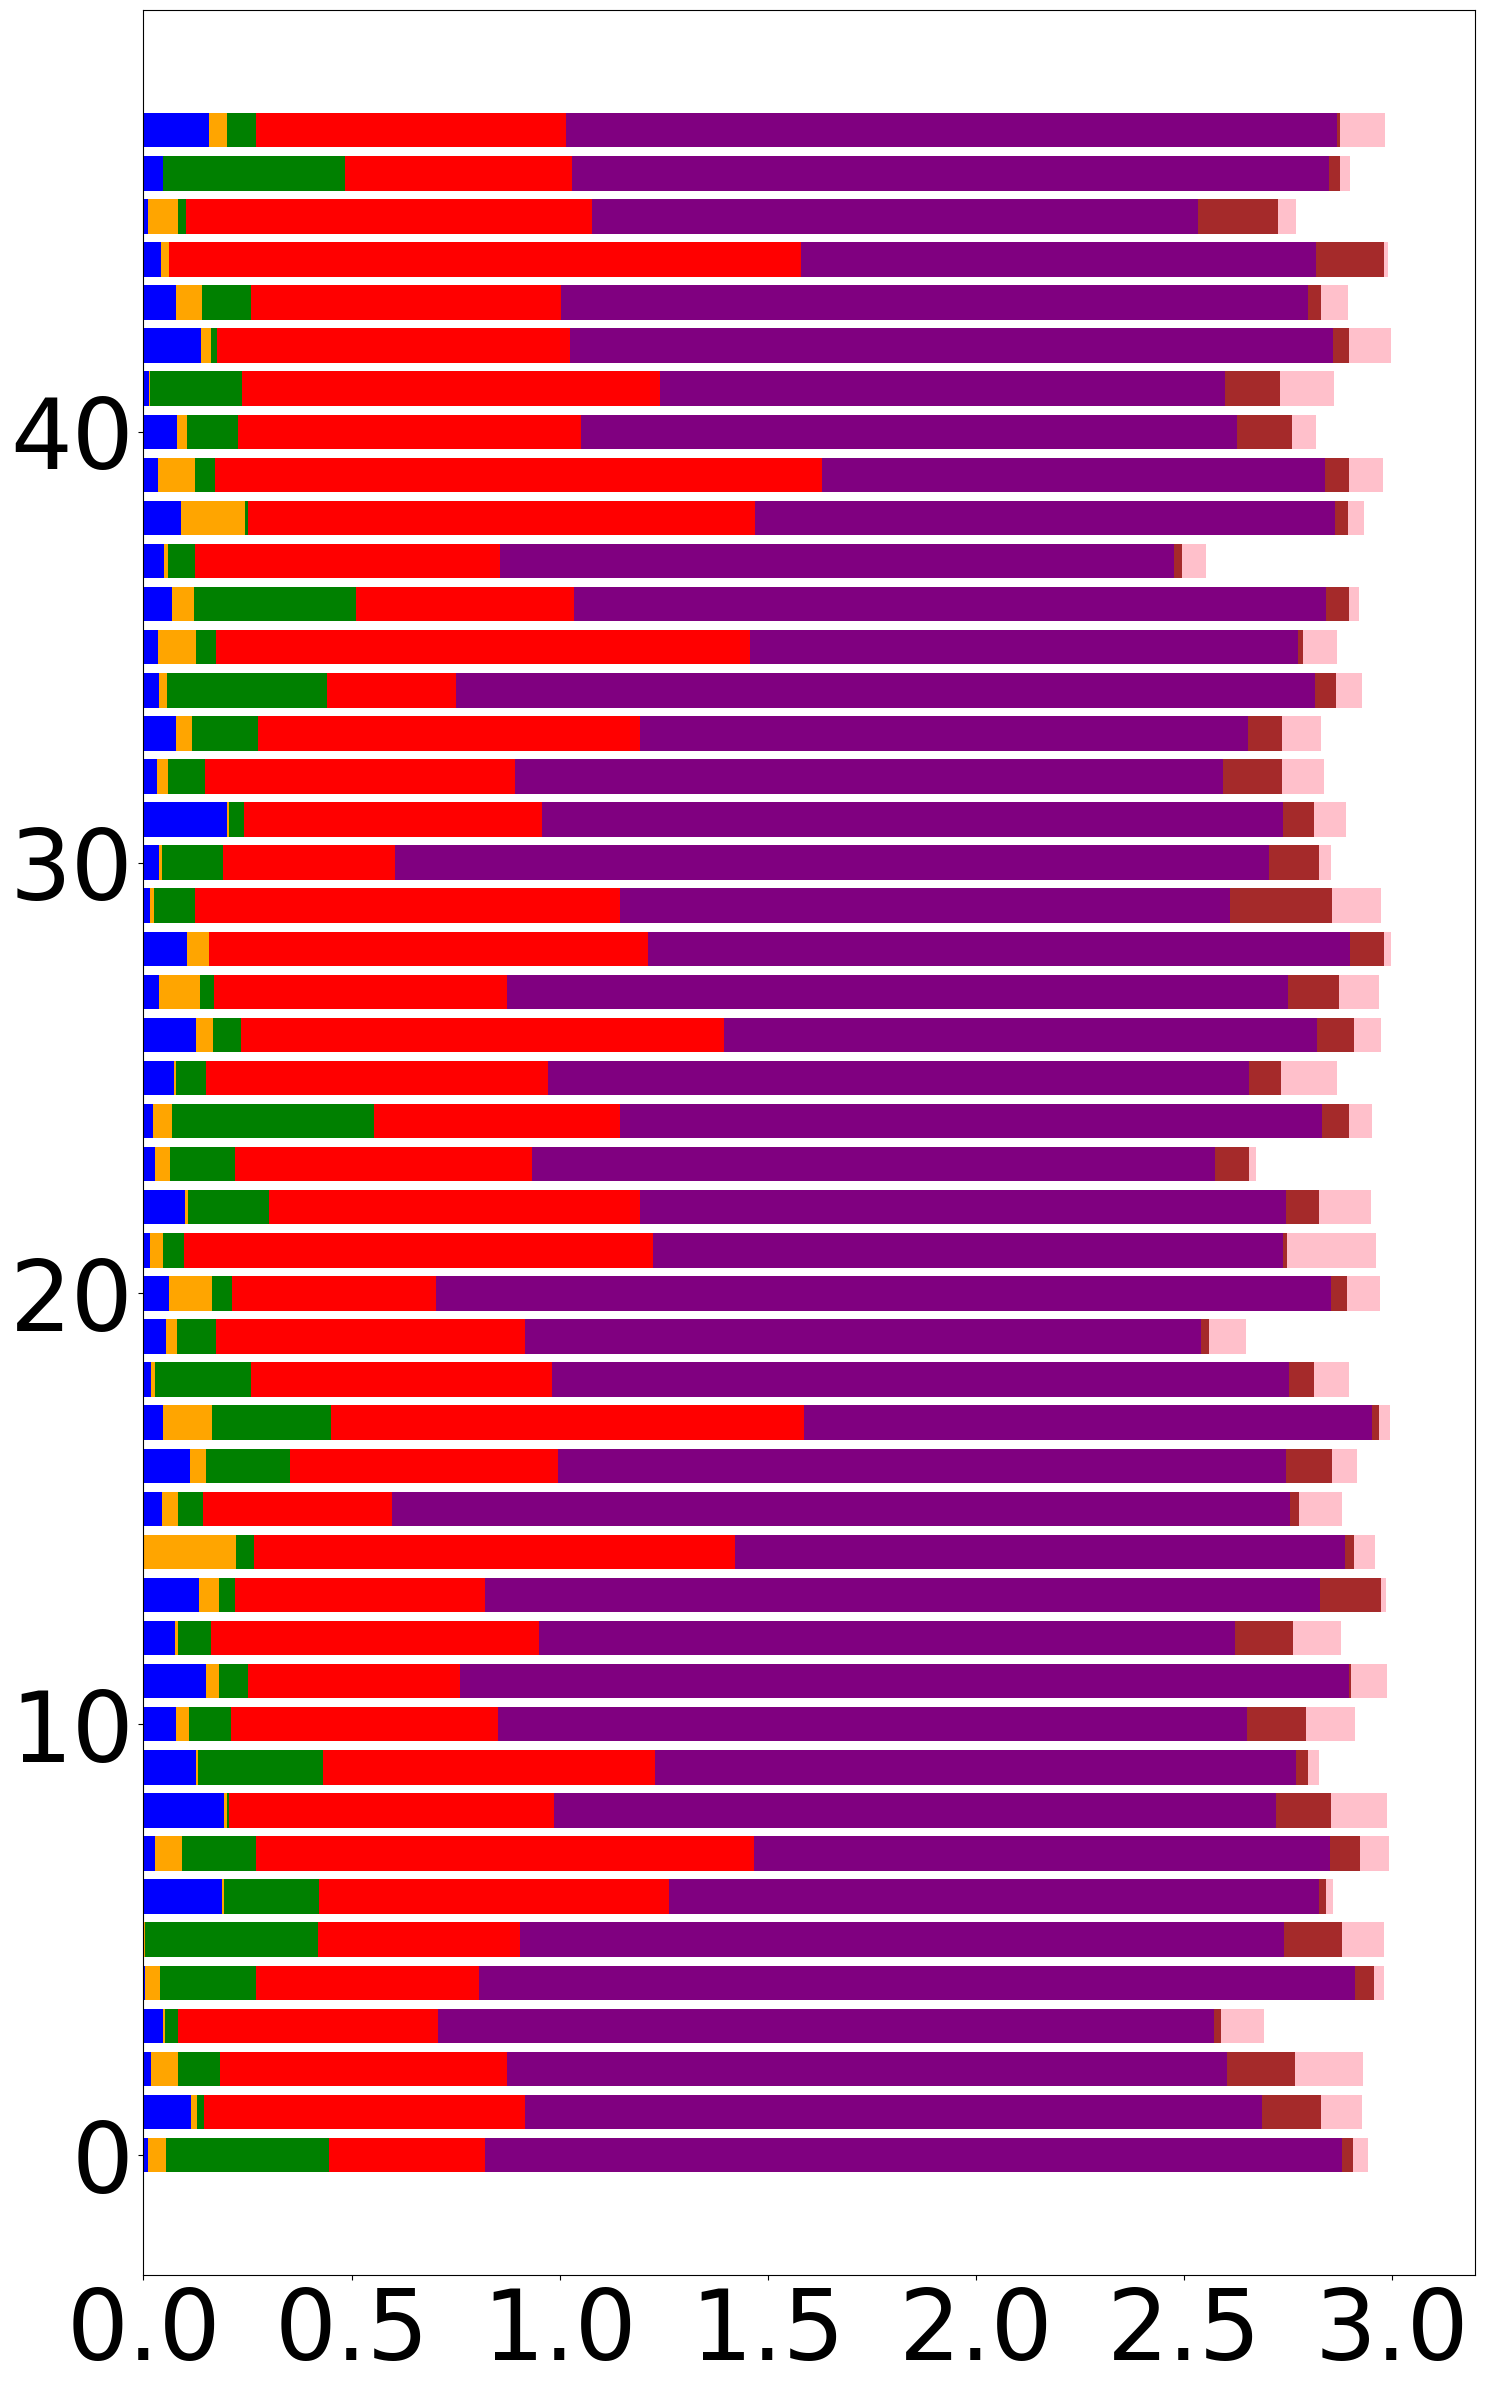

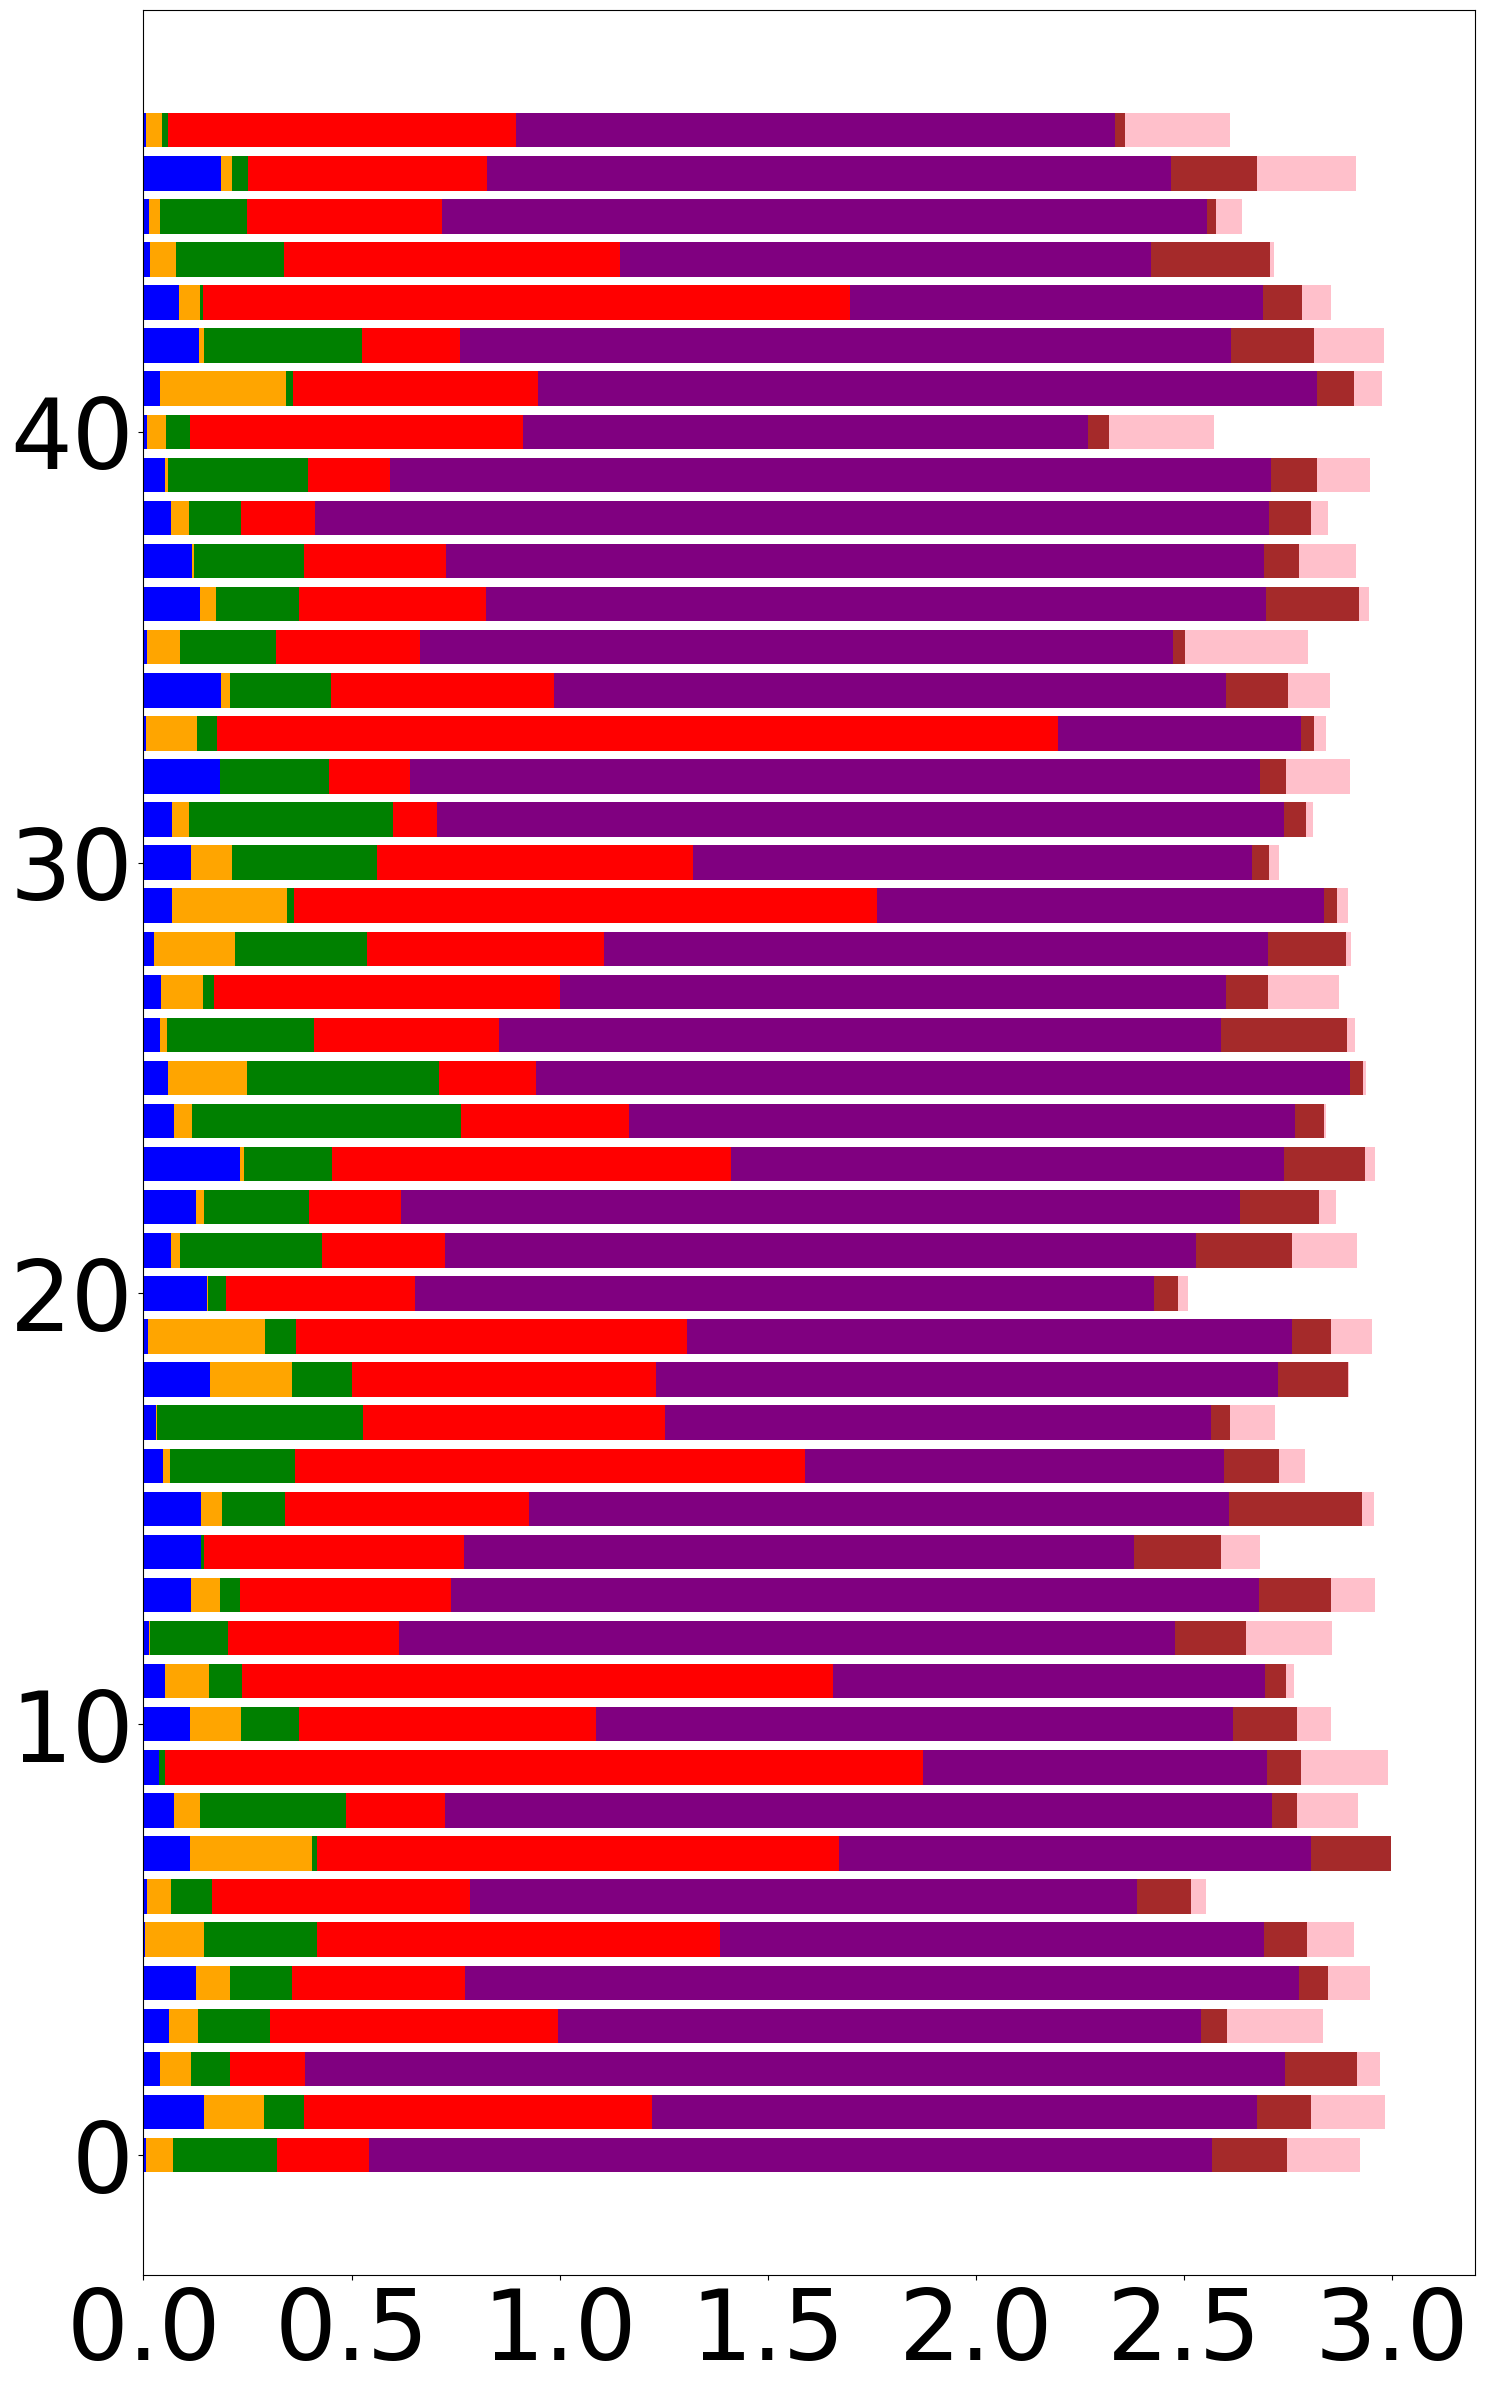

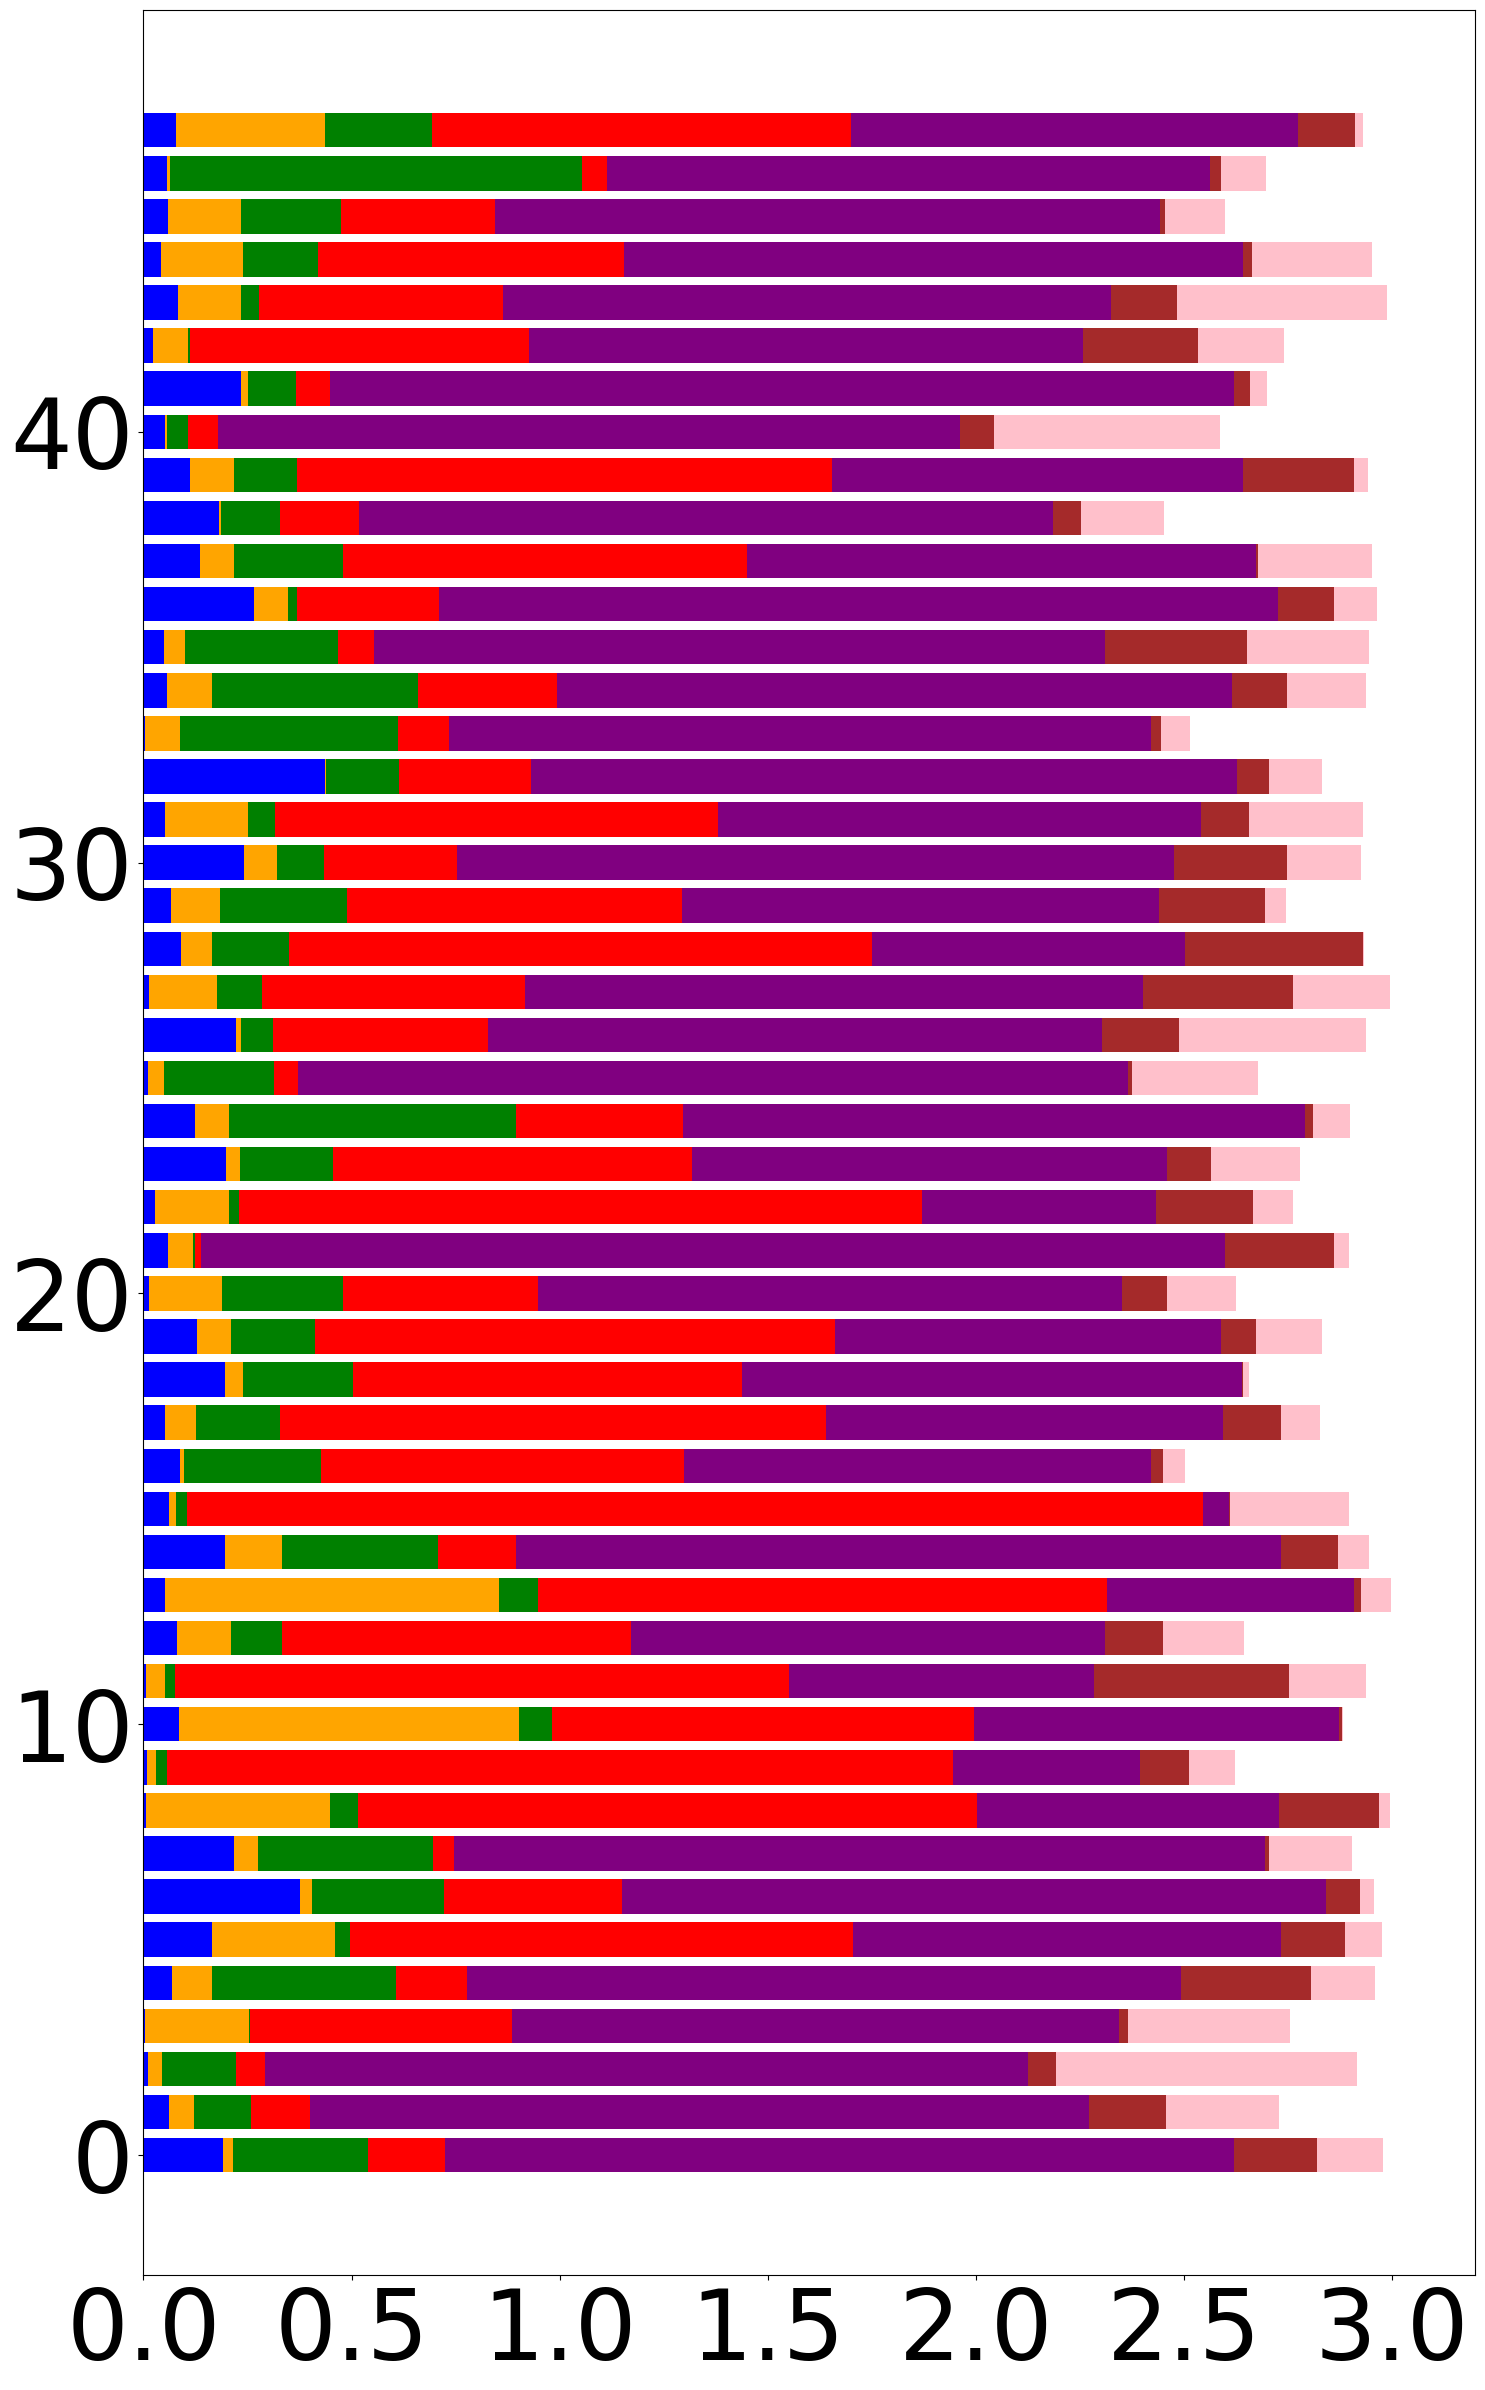

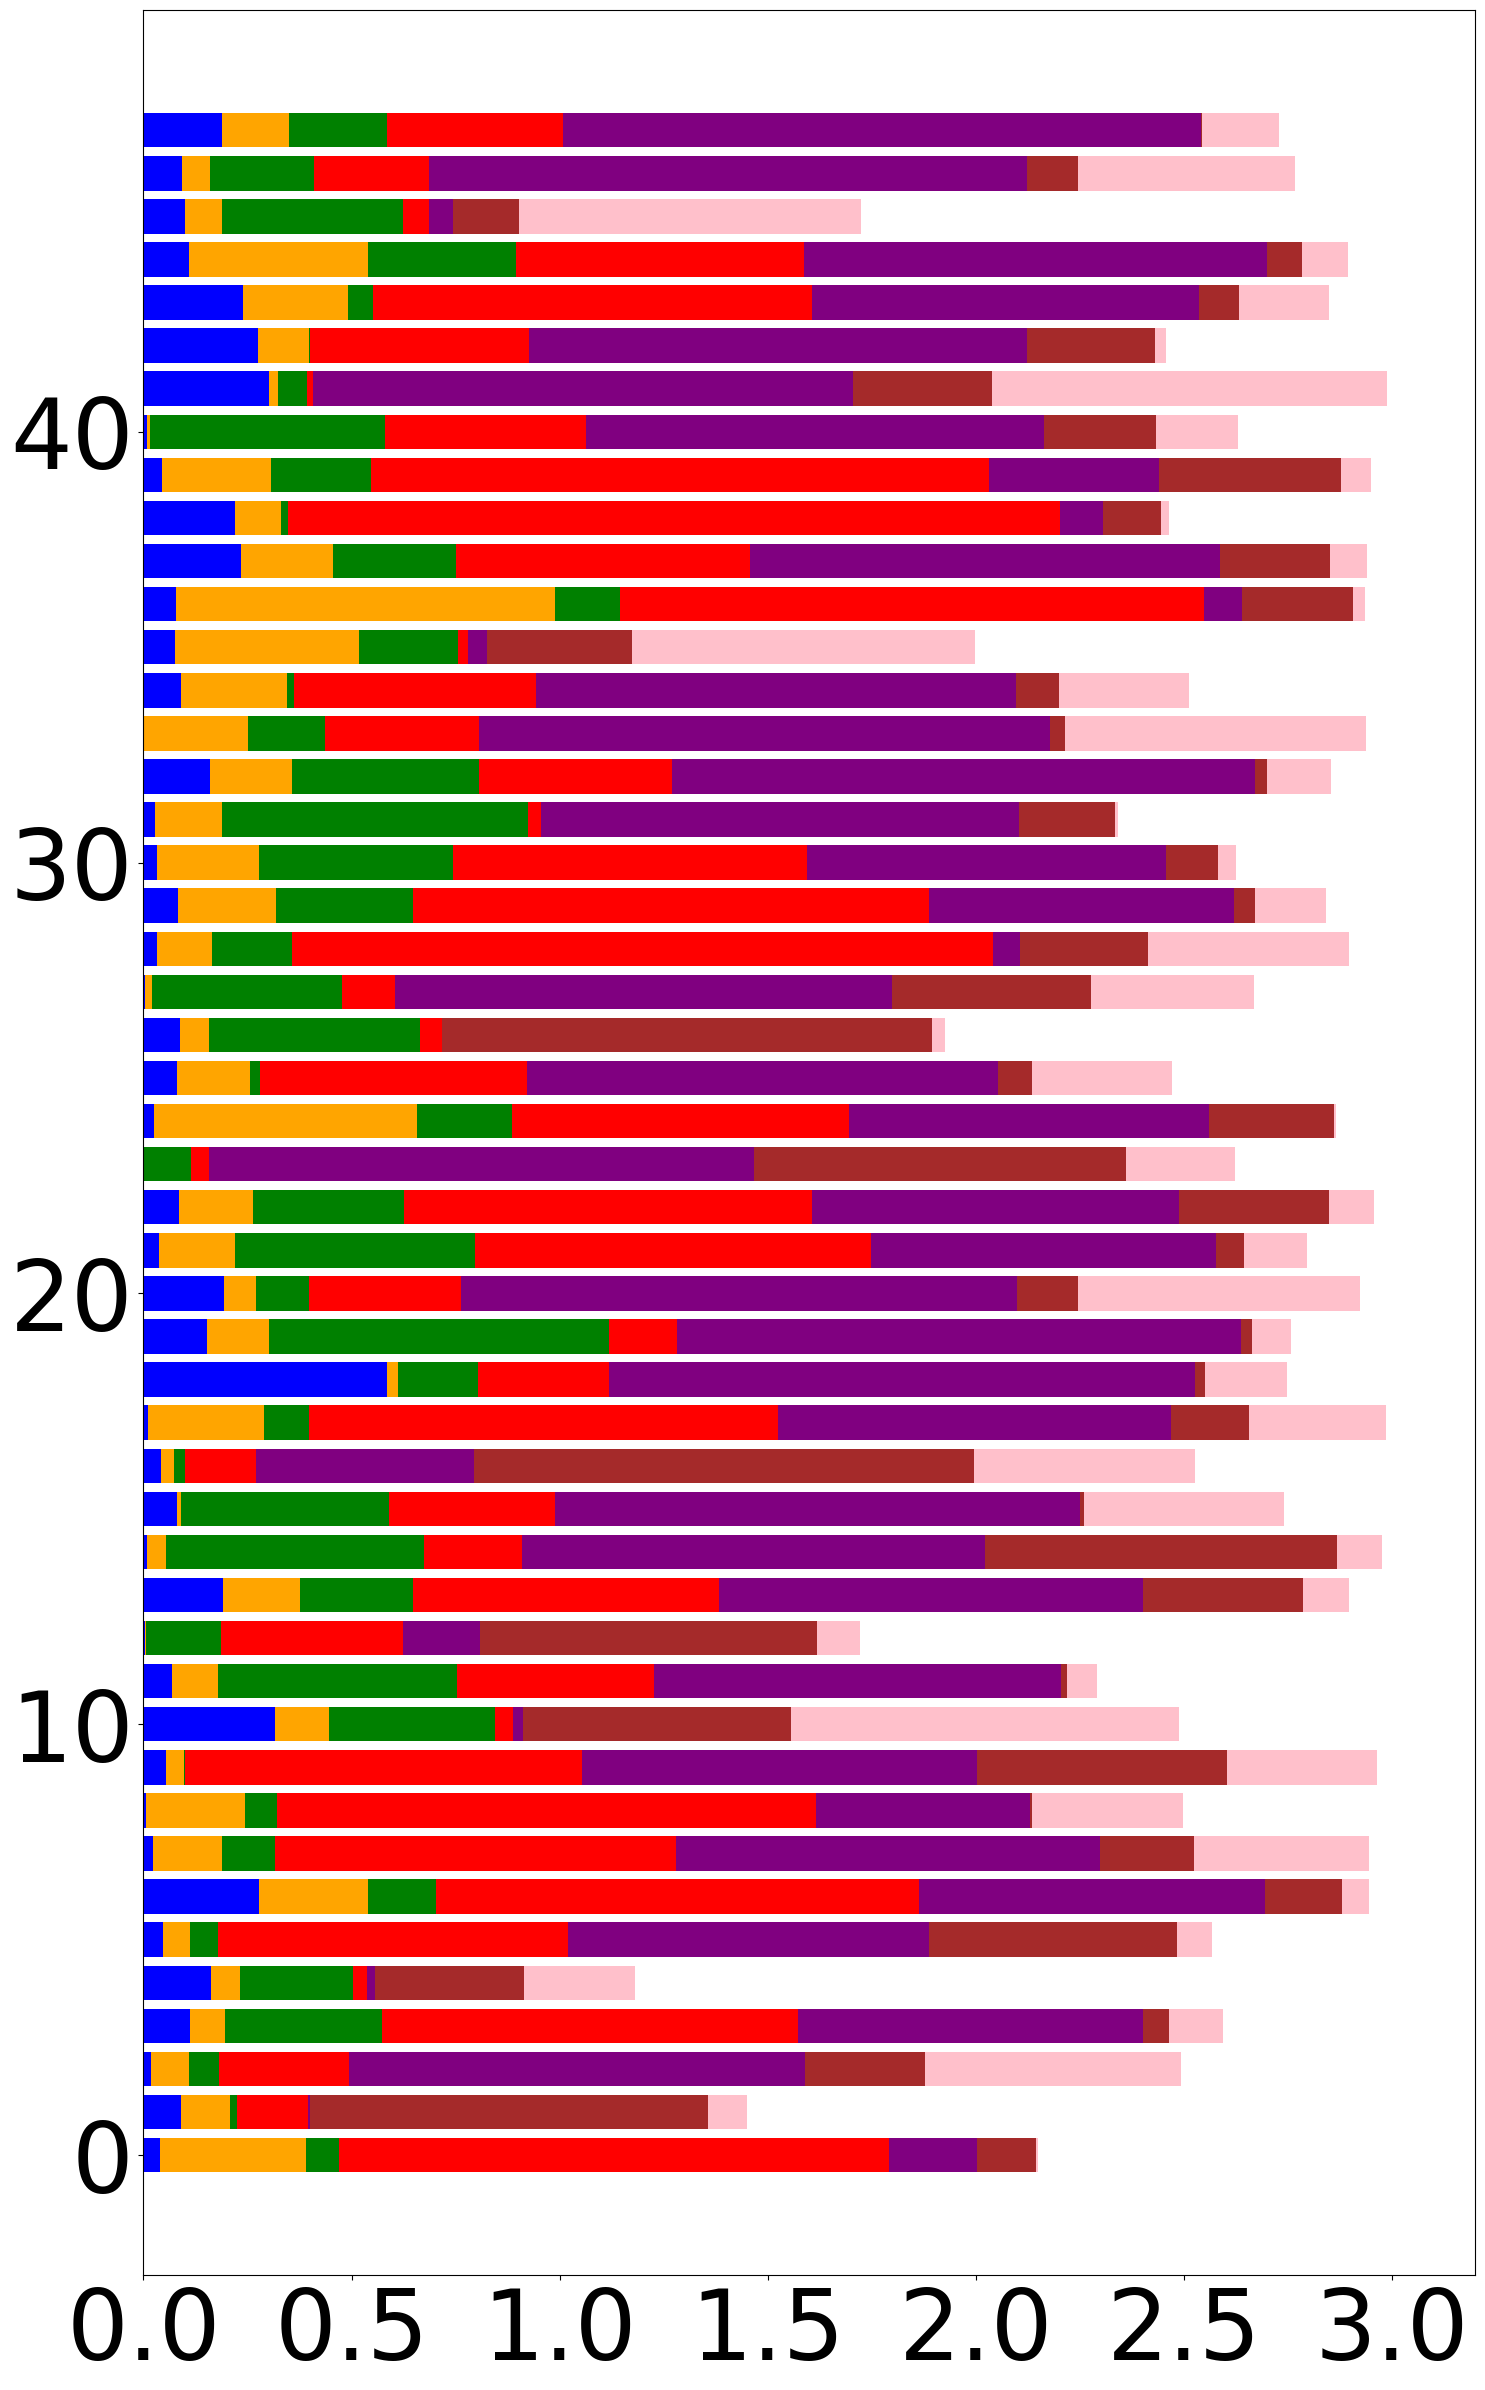

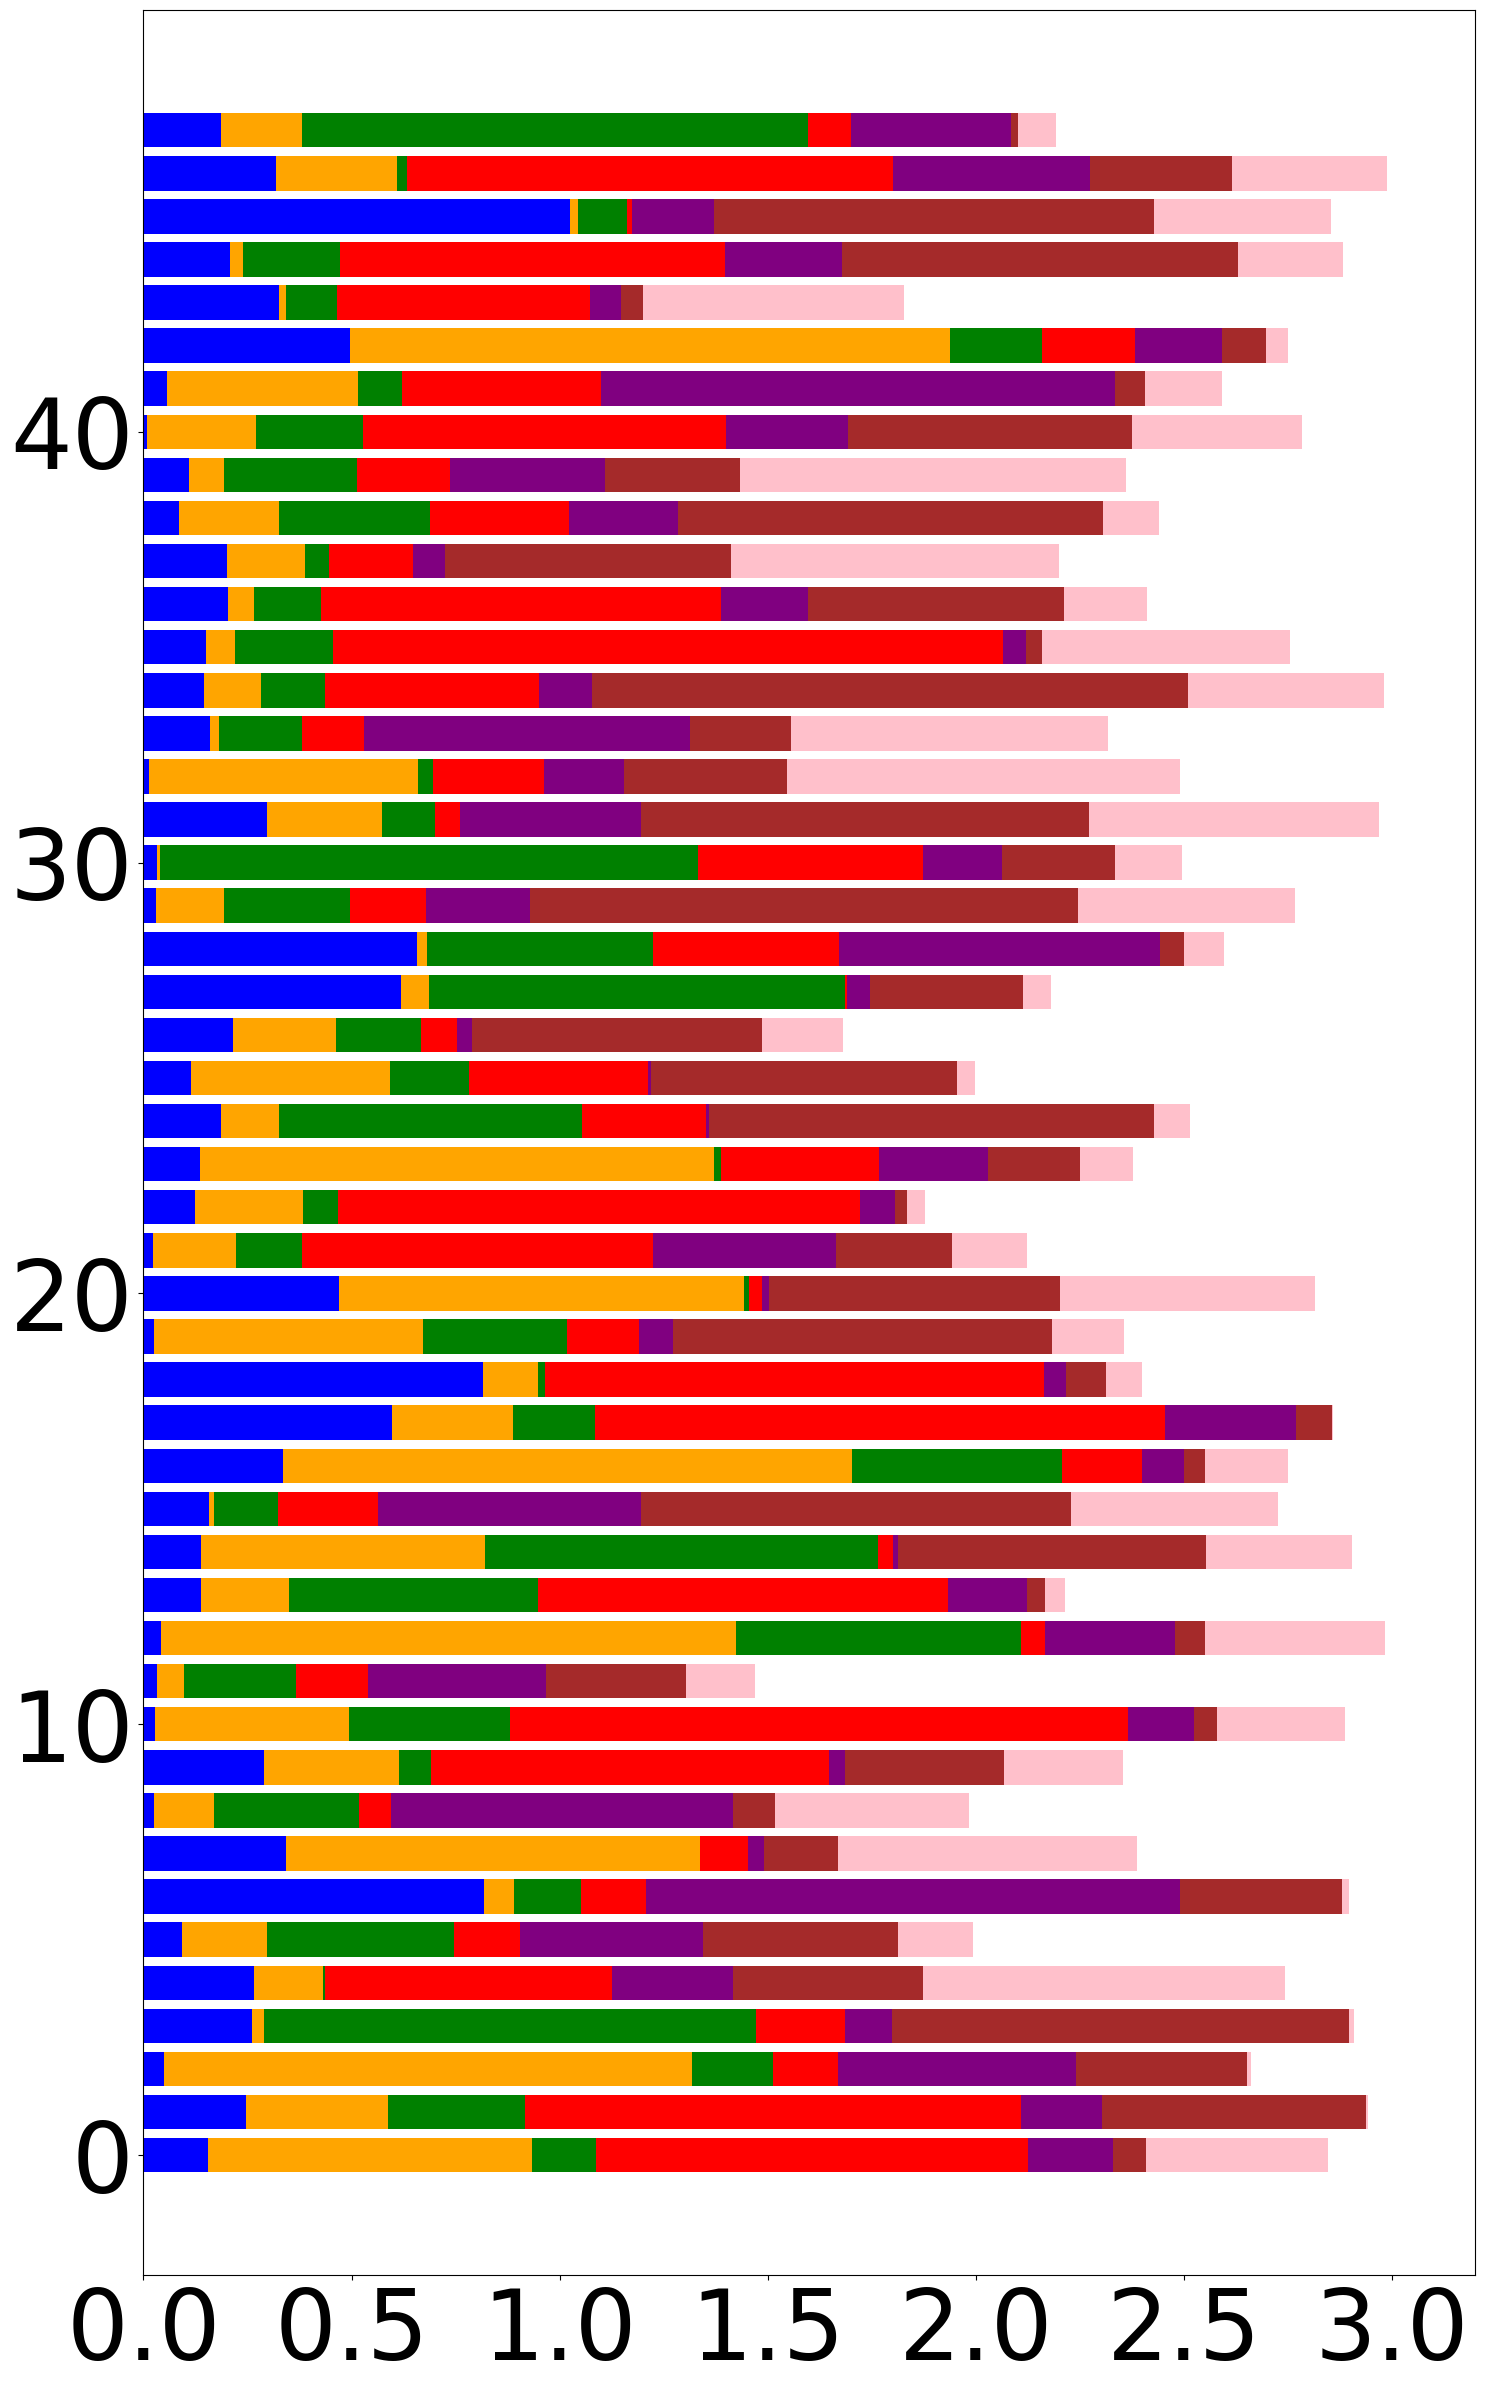

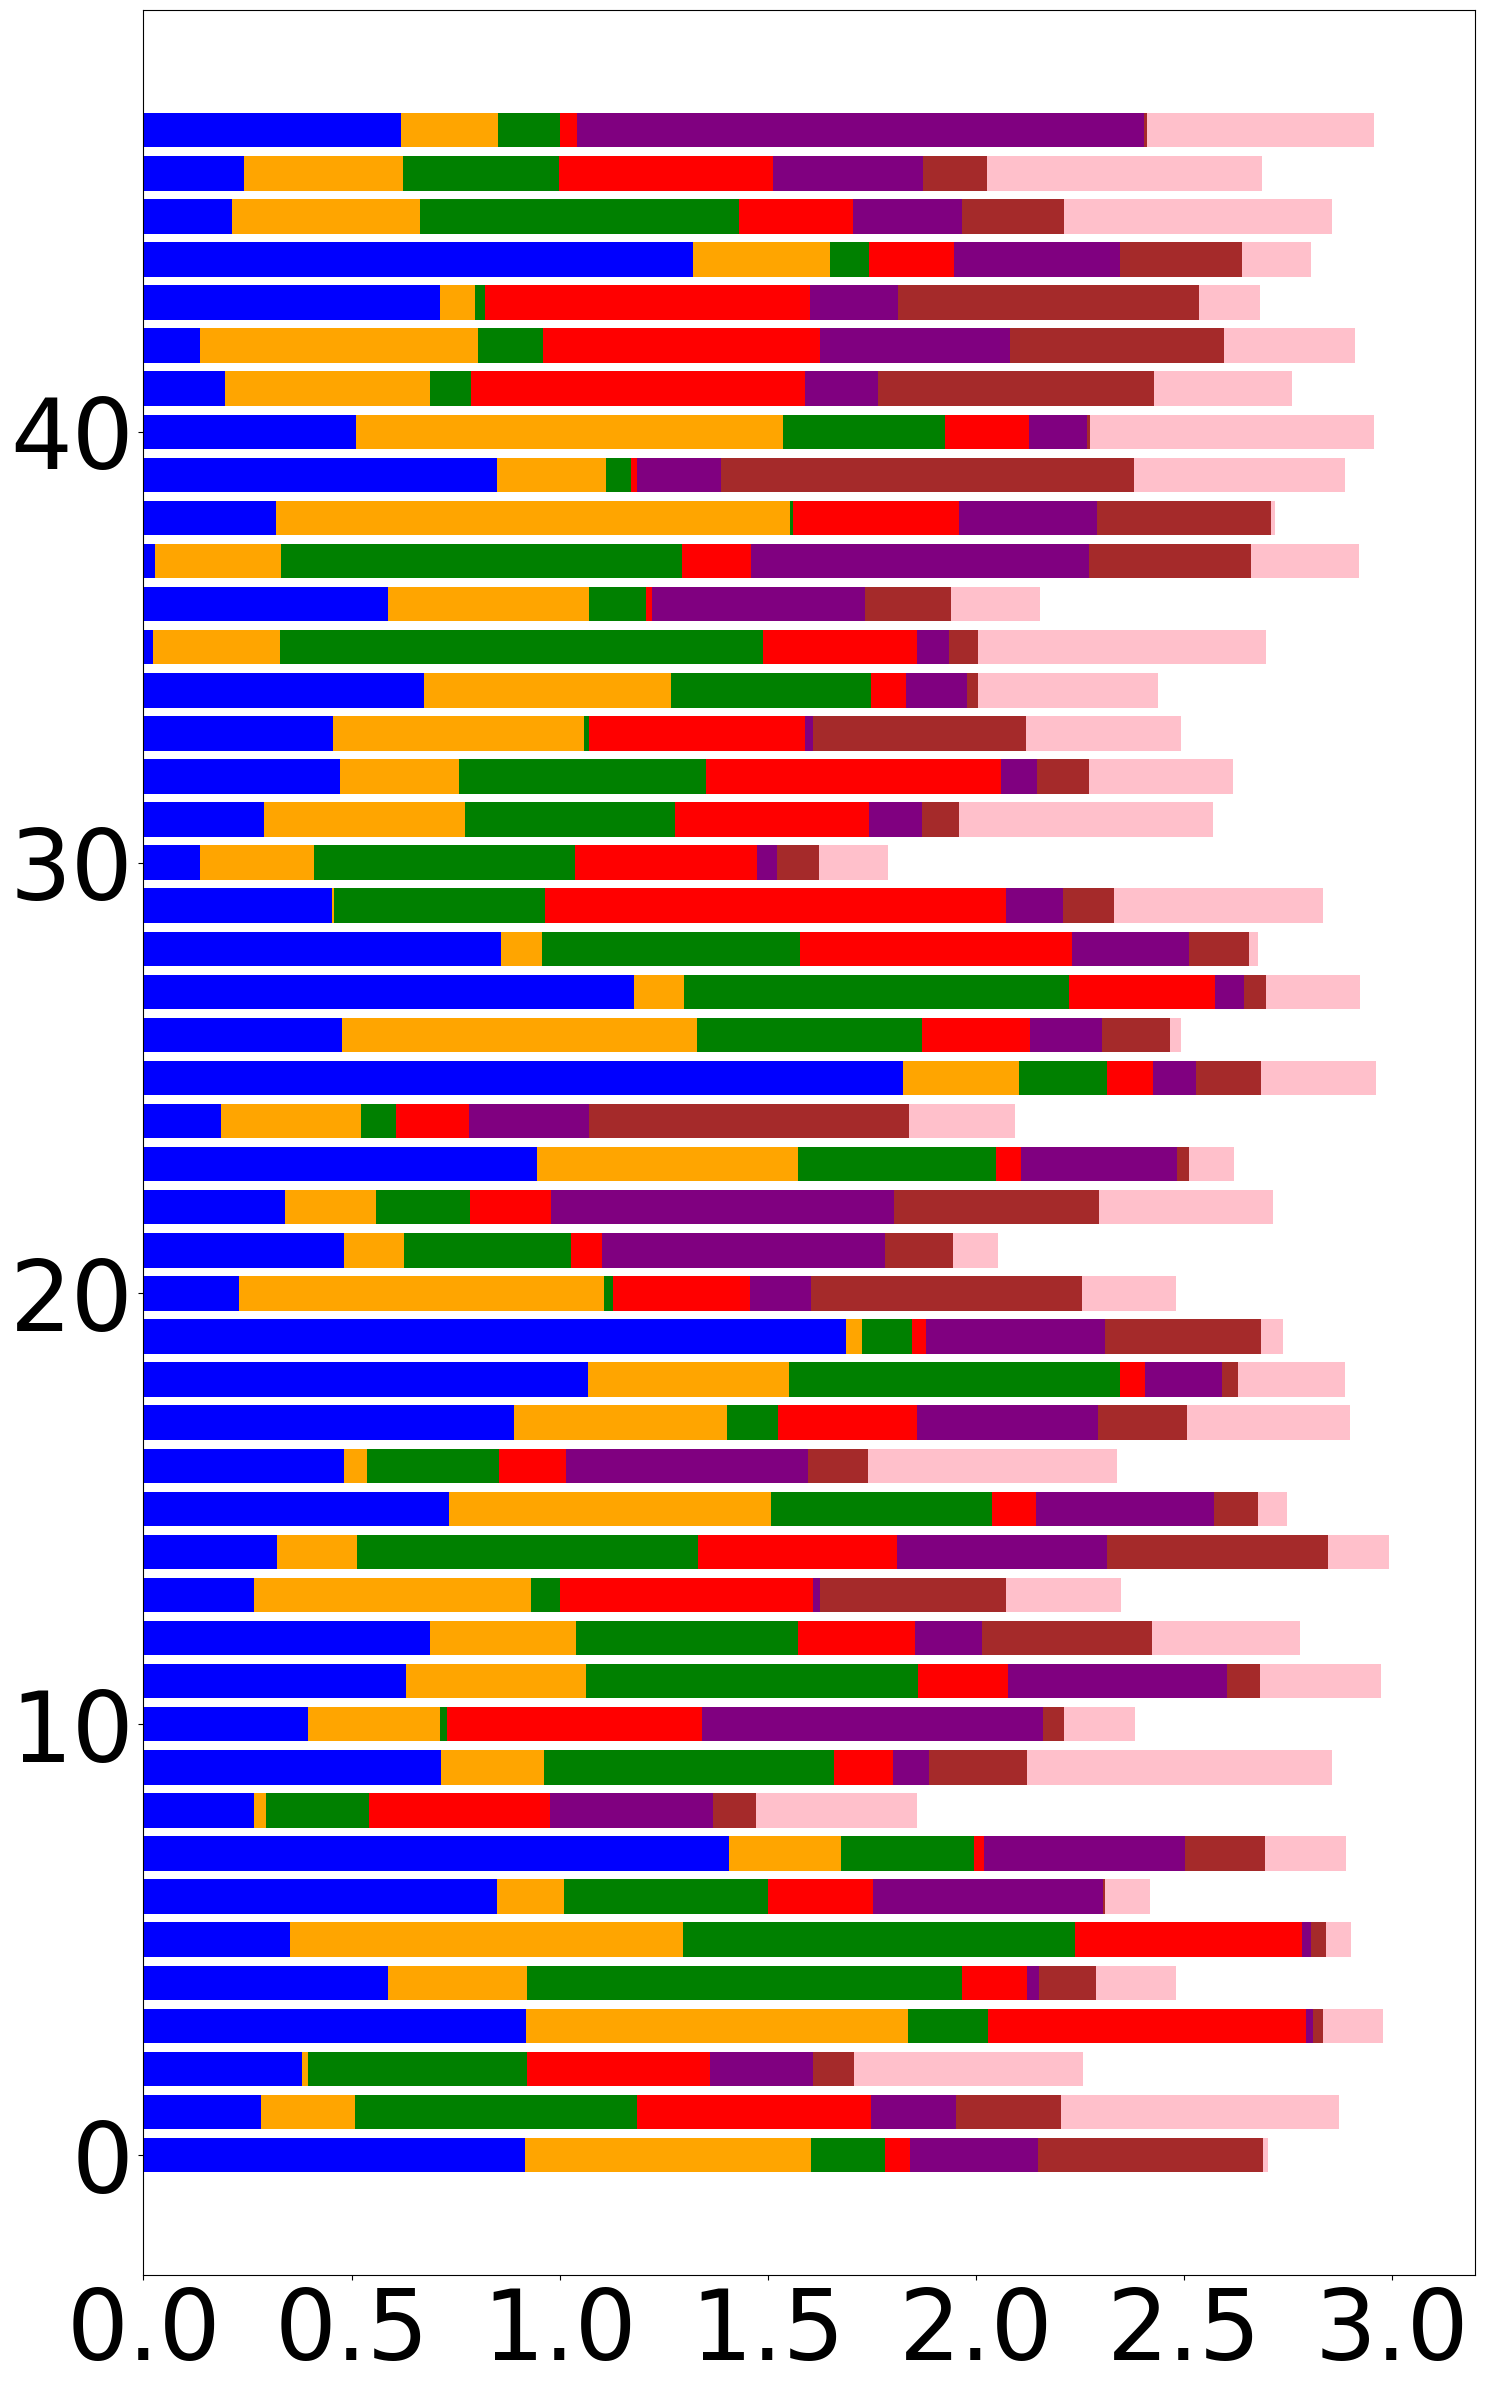

In [54]:
color_map = {
    ('decanoic acid_Concentration (mM)',): 'blue',
    ('decanoate_Concentration (mM)',): 'orange',
    ('decylamine_Concentration (mM)',): 'green',
    ('decyl trimethylamine_Concentration (mM)',): 'red',
    ('decylsulfate_Concentration (mM)',): 'purple',
    ('decanol_Concentration (mM)',): 'brown',
    ('monocaprin_Concentration (mM)',): 'pink'
}
for i, a in enumerate(selected_samples_dfs):
    plot_samples(path, a, f'Sample Concentrations(<3mM) - ({intervals[i]}th interval)', color_map)

In [71]:
# Initialize list to hold counts for each interval
interval_counts = []

# Count values in each interval
for interval in intervals:
    start, end = interval
    count = np.sum((pred_probs3[:, 1] <= start) & (pred_probs3[:, 1] > end))
    interval_counts.append(count)
interval_counts

[813, 8741, 48931, 345091, 3288244, 6308180]

In [57]:
valid_samples3

array([[0.41744773, 0.02247183, 0.23974949, ..., 0.17375531, 0.11326067,
        0.25884111],
       [0.13582858, 0.05495181, 0.30435132, ..., 0.43090506, 0.41956547,
        0.41248464],
       [0.2504561 , 0.3827127 , 0.26053081, ..., 0.47598865, 0.33490043,
        0.57038753],
       ...,
       [0.80265887, 0.26287137, 0.11545343, ..., 0.1502643 , 0.19422944,
        0.12488717],
       [0.03171174, 0.16285308, 0.21517455, ..., 0.08584044, 0.73108105,
        0.32707901],
       [0.15182556, 0.03120084, 0.24198923, ..., 0.03188581, 0.01135103,
        0.47433538]])

In [78]:
# Do prediction on <2mM <1mM region

In [2]:
import numpy as np
import time

# Initial bounds
original_bounds = np.array([[0., 0., 0., 0., 0., 0., 0.],[5., 5., 5., 5., 5., 1.5, 1.0]])
num_required_samples = 10000000
num_dimensions = original_bounds.shape[1]

# Define a simpler distribution (e.g., uniform) covering the initial bounds
low = original_bounds[0]
high = original_bounds[1]

# Parameters for adaptive bounds
adjust_factor = 0.9  # Factor to adjust the bounds by
min_bound = 1e-4  # Minimum bound size to avoid too small sampling ranges

start_time = time.time()  # Record start time

valid_samples = []
num_generate_samples = 1000000  # Initial batch size

while len(valid_samples) < num_required_samples:
    # Generate samples
    samples = np.random.uniform(low=low, high=high, size=(num_generate_samples, num_dimensions))

    # Calculate the sum of the features
    total_concentration = samples.sum(axis=1)

    # Reject samples violating the constraint (total_concentration < 1)
    valid_samples_batch = samples[total_concentration < 1]

    # Append valid samples
    valid_samples.extend(valid_samples_batch.tolist())

    # Adjust the sampling bounds if the success rate is low
    if len(valid_samples_batch) < num_generate_samples * 0.01:
        range_size = high - low
        new_range_size = range_size * adjust_factor
        # Ensure the bounds do not get too small
        new_range_size = np.maximum(new_range_size, min_bound)
        high = low + new_range_size
        print(f"Adjusting bounds to {high}")

    # Print progress
    print(f"Generated {num_generate_samples} samples, found {len(valid_samples_batch)} valid samples")

# Ensure we have exactly the required number of samples
valid_samples = np.array(valid_samples[:num_required_samples])

# Apply log1p transform
valid_samples1 = np.log1p(valid_samples)
print(valid_samples1.shape)

end_time = time.time()  # Record end time

# Calculate and print execution time
execution_time = end_time - start_time
print(f"Execution time: {execution_time:.2f} seconds")


Adjusting bounds to [4.5  4.5  4.5  4.5  4.5  1.35 0.9 ]
Generated 1000000 samples, found 0 valid samples
Adjusting bounds to [4.05  4.05  4.05  4.05  4.05  1.215 0.81 ]
Generated 1000000 samples, found 0 valid samples
Adjusting bounds to [3.645  3.645  3.645  3.645  3.645  1.0935 0.729 ]
Generated 1000000 samples, found 0 valid samples
Adjusting bounds to [3.2805  3.2805  3.2805  3.2805  3.2805  0.98415 0.6561 ]
Generated 1000000 samples, found 0 valid samples
Adjusting bounds to [2.95245  2.95245  2.95245  2.95245  2.95245  0.885735 0.59049 ]
Generated 1000000 samples, found 0 valid samples
Adjusting bounds to [2.657205  2.657205  2.657205  2.657205  2.657205  0.7971615 0.531441 ]
Generated 1000000 samples, found 2 valid samples
Adjusting bounds to [2.3914845  2.3914845  2.3914845  2.3914845  2.3914845  0.71744535
 0.4782969 ]
Generated 1000000 samples, found 2 valid samples
Adjusting bounds to [2.15233605 2.15233605 2.15233605 2.15233605 2.15233605 0.64570082
 0.43046721]
Generated 

In [5]:
np.save('valid_samples1.npy', valid_samples1)

In [6]:
# Initial bounds
original_bounds = np.array([[0., 0., 0., 0., 0., 0., 0.],[5., 5., 5., 5., 5., 1.5, 1.0]])
num_required_samples = 10000000
num_dimensions = original_bounds.shape[1]

# Define a simpler distribution (e.g., uniform) covering the initial bounds
low = original_bounds[0]
high = original_bounds[1]

# Parameters for adaptive bounds
adjust_factor = 0.9  # Factor to adjust the bounds by
min_bound = 1e-4  # Minimum bound size to avoid too small sampling ranges

start_time = time.time()  # Record start time

valid_samples = []
num_generate_samples = 1000000  # Initial batch size

while len(valid_samples) < num_required_samples:
    # Generate samples
    samples = np.random.uniform(low=low, high=high, size=(num_generate_samples, num_dimensions))

    # Calculate the sum of the features
    total_concentration = samples.sum(axis=1)

    valid_samples_batch = samples[total_concentration < 2]

    # Append valid samples
    valid_samples.extend(valid_samples_batch.tolist())

    # Adjust the sampling bounds if the success rate is low
    if len(valid_samples_batch) < num_generate_samples * 0.01:
        range_size = high - low
        new_range_size = range_size * adjust_factor
        # Ensure the bounds do not get too small
        new_range_size = np.maximum(new_range_size, min_bound)
        high = low + new_range_size
        print(f"Adjusting bounds to {high}")

    # Print progress
    print(f"Generated {num_generate_samples} samples, found {len(valid_samples_batch)} valid samples")

# Ensure we have exactly the required number of samples
valid_samples = np.array(valid_samples[:num_required_samples])

# Apply log1p transform
valid_samples2 = np.log1p(valid_samples)
print(valid_samples2.shape)

end_time = time.time()  # Record end time

# Calculate and print execution time
execution_time = end_time - start_time
print(f"Execution time: {execution_time:.2f} seconds")


Adjusting bounds to [4.5  4.5  4.5  4.5  4.5  1.35 0.9 ]
Generated 1000000 samples, found 5 valid samples
Adjusting bounds to [4.05  4.05  4.05  4.05  4.05  1.215 0.81 ]
Generated 1000000 samples, found 6 valid samples
Adjusting bounds to [3.645  3.645  3.645  3.645  3.645  1.0935 0.729 ]
Generated 1000000 samples, found 22 valid samples
Adjusting bounds to [3.2805  3.2805  3.2805  3.2805  3.2805  0.98415 0.6561 ]
Generated 1000000 samples, found 48 valid samples
Adjusting bounds to [2.95245  2.95245  2.95245  2.95245  2.95245  0.885735 0.59049 ]
Generated 1000000 samples, found 87 valid samples
Adjusting bounds to [2.657205  2.657205  2.657205  2.657205  2.657205  0.7971615 0.531441 ]
Generated 1000000 samples, found 189 valid samples
Adjusting bounds to [2.3914845  2.3914845  2.3914845  2.3914845  2.3914845  0.71744535
 0.4782969 ]
Generated 1000000 samples, found 409 valid samples
Adjusting bounds to [2.15233605 2.15233605 2.15233605 2.15233605 2.15233605 0.64570082
 0.43046721]
Gen

In [8]:
np.save('valid_samples2.npy', valid_samples2)

In [188]:
valid_samples1 = np.load('valid_samples1.npy')
valid_samples2 = np.load('valid_samples2.npy')

In [190]:
df_sample1 = pd.DataFrame(valid_samples1, columns=[df_input_update.iloc[:,0:7].columns])
pred_probs1 = cal_prob(df_sample1, model, batch_size=100000)
df_sample2 = pd.DataFrame(valid_samples2, columns=[df_input_update.iloc[:,0:7].columns])
pred_probs2 = cal_prob(df_sample2, model, batch_size=100000)

Running time: 59.20168089866638 seconds
Running time: 59.85226392745972 seconds


In [10]:
# Load the model from the .pkl file
with open('GPC_model_20240713.pkl', 'rb') as file:
    model = pickle.load(file)

In [15]:
# valid_samples3 = np.load('valid_samples3.npy')
df_sample1 = pd.DataFrame(valid_samples1, columns=[df_input_update.iloc[:,0:7].columns])
pred_probs1 = cal_prob(df_sample1, model, batch_size=100000)

Running time: 58.80123019218445 seconds


In [16]:
df_sample2 = pd.DataFrame(valid_samples2, columns=[df_input_update.iloc[:,0:7].columns])
pred_probs2 = cal_prob(df_sample2, model, batch_size=100000)

Running time: 57.87653923034668 seconds


Percentage of 1s: 0.0000%
Percentage of 1s: 0.0002%
Percentage of 1s: 0.2283%


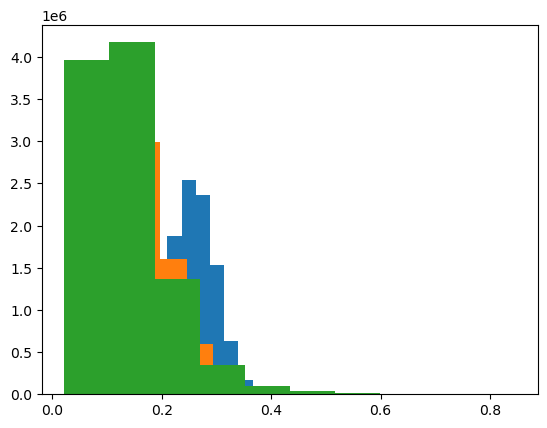

In [20]:
# Calculatign percent of samples of forming vesicles
p1 = cal_vesicles_per(pred_probs1)
p2 = cal_vesicles_per(pred_probs2)
p3 = cal_vesicles_per(pred_probs3)

In [33]:
second_column = pred_probs3[:, 1]
# Count the number of values >= 0.5
count = np.sum(second_column >= 0.5)
count 

22834

In [26]:
top_indices_813 = np.argsort(pred_probs3[:, 1])[::-1][:813]
candidates_813 = df_sample3.iloc[top_indices_813]
original_scale_df_813 = np.expm1(candidates_813)

In [43]:
color_map = {
    ('decanoic acid_Concentration (mM)',): 'blue',
    ('decanoate_Concentration (mM)',): 'orange',
    ('decylamine_Concentration (mM)',): 'green',
    ('decyl trimethylamine_Concentration (mM)',): 'red',
    ('decylsulfate_Concentration (mM)',): 'purple',
    ('decanol_Concentration (mM)',): 'brown',
    ('monocaprin_Concentration (mM)',): 'pink'
}

# color_map = {
#     'decanoic acid_Concentration (mM)': 'blue',
#     'decanoate_Concentration (mM)': 'orange',
#     'decylamine_Concentration (mM)': 'green',
#     'decyl trimethylamine_Concentration (mM)': 'red',
#     'decylsulfate_Concentration (mM)': 'purple',
#     'decanol_Concentration (mM)': 'brown',
#     'monocaprin_Concentration (mM)': 'pink'
# }
plot_samples(path, original_scale_df_813, 'Sample Concentrations - AL6 (813 samples having vesicles)', color_map)

In [102]:
original_scale_df_813

,decanoic acid_Concentration (mM),decanoate_Concentration (mM),decylamine_Concentration (mM),decyl trimethylamine_Concentration (mM),decylsulfate_Concentration (mM),decanol_Concentration (mM),monocaprin_Concentration (mM)
6470933,0.002702,0.016384,0.039210,1.043995,1.757567,0.058393,0.025493
4346298,0.013866,0.007089,0.059461,1.346107,1.527987,0.014231,0.019943
7139502,0.016154,0.003696,0.255940,0.647109,1.995314,0.064577,0.005955
7272845,0.002167,0.006678,0.198756,0.921801,1.704089,0.041912,0.022718
7352620,0.044067,0.018018,0.120513,0.789405,1.931401,0.021899,0.073093
...,...,...,...,...,...,...,...
6728734,0.041663,0.022935,0.019201,1.377371,1.194523,0.009087,0.080567
7810624,0.086571,0.041700,0.289681,0.628359,1.705338,0.023439,0.110425
4406980,0.155111,0.005374,0.306538,0.545339,1.758142,0.137173,0.013170
7092960,0.004006,0.114796,0.016385,1.508051,1.122536,0.102528,0.019281


In [27]:
candidates_813

,decanoic acid_Concentration (mM),decanoate_Concentration (mM),decylamine_Concentration (mM),decyl trimethylamine_Concentration (mM),decylsulfate_Concentration (mM),decanol_Concentration (mM),monocaprin_Concentration (mM)
6470933,0.002699,0.016251,0.038460,0.714906,1.014349,0.056752,0.025173
4346298,0.013771,0.007064,0.057760,0.852758,0.927423,0.014131,0.019747
7139502,0.016025,0.003689,0.227885,0.499022,1.097049,0.062577,0.005938
7272845,0.002165,0.006656,0.181285,0.653263,0.994765,0.041057,0.022464
7352620,0.043124,0.017857,0.113787,0.581883,1.075481,0.021663,0.070545
...,...,...,...,...,...,...,...
6728734,0.040818,0.022676,0.019019,0.865995,0.785965,0.009045,0.077486
7810624,0.083027,0.040854,0.254395,0.487572,0.995227,0.023169,0.104742
4406980,0.144197,0.005359,0.267381,0.435244,1.014557,0.128545,0.013084
7092960,0.003998,0.108672,0.016252,0.919506,0.752612,0.097605,0.019098


In [52]:
pred_probs3_0 = cal_prob(candidates_813, model, batch_size=100000)

Running time: 0.06578421592712402 seconds


In [53]:
pred_probs3_0 

array([[0.16342972, 0.83657028],
       [0.17259915, 0.82740085],
       [0.21927419, 0.78072581],
       ...,
       [0.31713216, 0.68286784],
       [0.28032901, 0.71967099],
       [0.27008835, 0.72991165]])

Percentage of 1s: 100.0000%


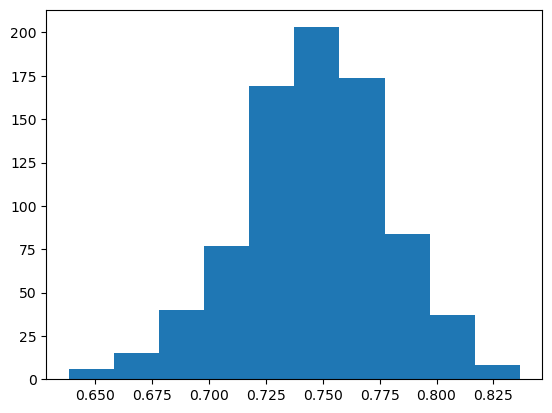

In [54]:
p3_0 = cal_vesicles_per(pred_probs3_0)

Percentage of 1s: 100.0000%


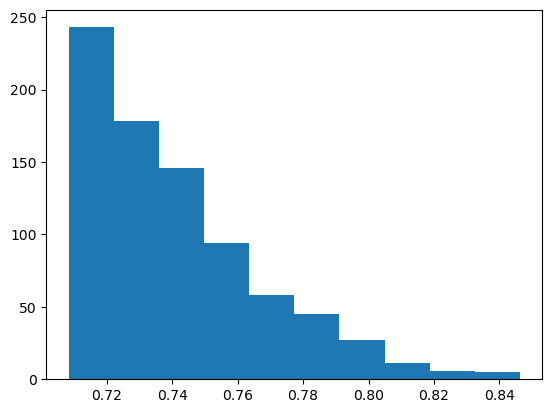

In [59]:
p3_813 = cal_vesicles_per((pred_probs3[:][top_indices_813]))

In [57]:
pred_probs3[:,1][top_indices_813]

array([0.84625151, 0.83708797, 0.83559516, 0.83549179, 0.83382538,
       0.83107717, 0.83026404, 0.82255665, 0.82094318, 0.82083282,
       0.81877035, 0.81709932, 0.81670718, 0.81329782, 0.81066774,
       0.81011215, 0.80900838, 0.80874045, 0.80781927, 0.80683719,
       0.80616881, 0.80500833, 0.8034187 , 0.8033941 , 0.8022716 ,
       0.80220939, 0.80204989, 0.80060797, 0.80037694, 0.79947072,
       0.79939963, 0.79801049, 0.79798379, 0.79763832, 0.79741435,
       0.79696666, 0.7968175 , 0.79616324, 0.79533532, 0.79493006,
       0.79462005, 0.7945488 , 0.7938098 , 0.79358002, 0.79323108,
       0.79280676, 0.79261541, 0.79252557, 0.79141793, 0.79092051,
       0.79091541, 0.79015915, 0.78991423, 0.78962396, 0.78958639,
       0.78936624, 0.78902169, 0.78899474, 0.78897529, 0.78841074,
       0.78822729, 0.78765477, 0.78763688, 0.78759706, 0.78732877,
       0.78682063, 0.78667821, 0.78642058, 0.78624959, 0.78620199,
       0.78598049, 0.78498177, 0.78408217, 0.78359671, 0.78354

In [195]:
second_column = pred_probs2[:, 1]
# Count the number of values >= 0.5
count = np.sum(second_column >= 0.5)
count 

24

In [196]:
second_column = pred_probs1[:, 1]
# Count the number of values >= 0.5
count = np.sum(second_column >= 0.5)
count 

0

Percentage of 1s: 0.0000%


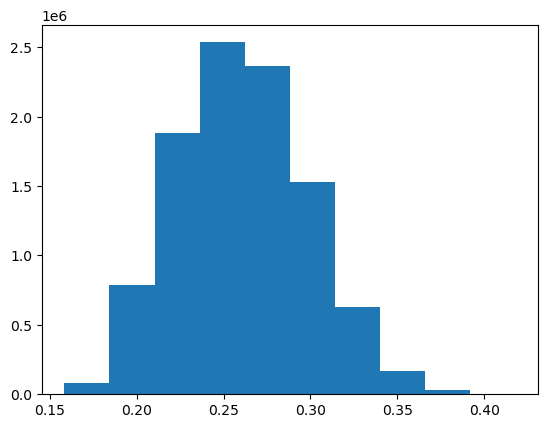

In [32]:
p1 = cal_vesicles_per(pred_probs1)

/Users/haoliu/anaconda3/envs/ActiveLearning/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


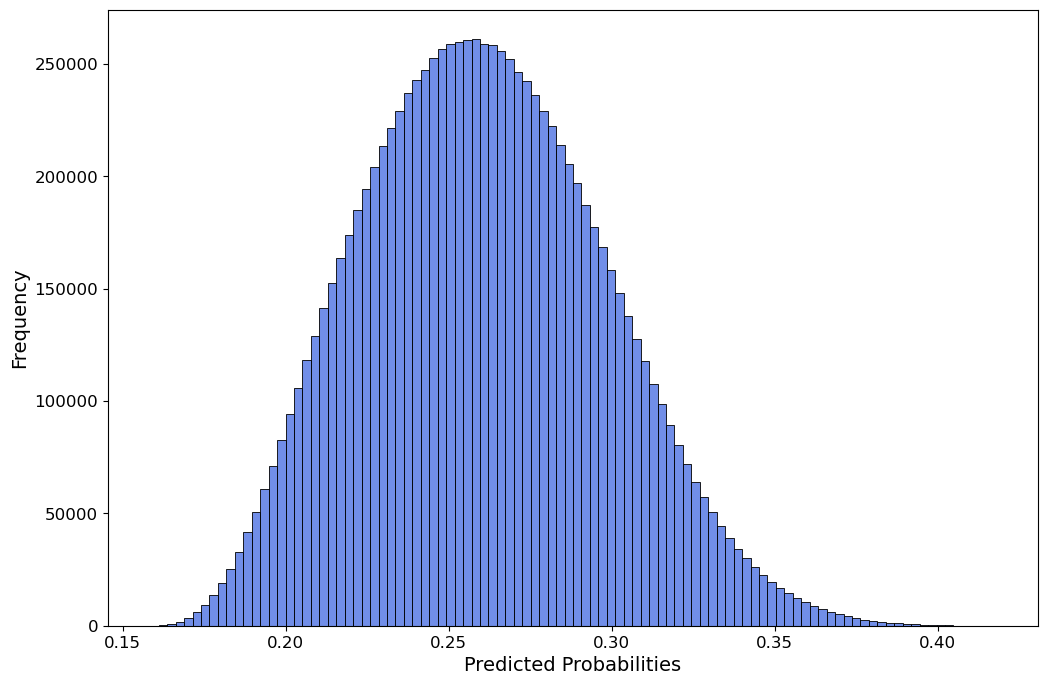

In [194]:
filename = 'histogram_model_1.pdf'
plot_histogram(pred_probs1, filename)

Percentage of 1s: 0.0002%


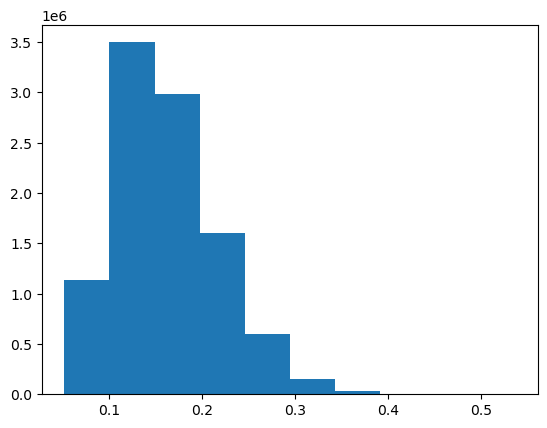

In [30]:
p2 = cal_vesicles_per(pred_probs2)

/Users/haoliu/anaconda3/envs/ActiveLearning/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


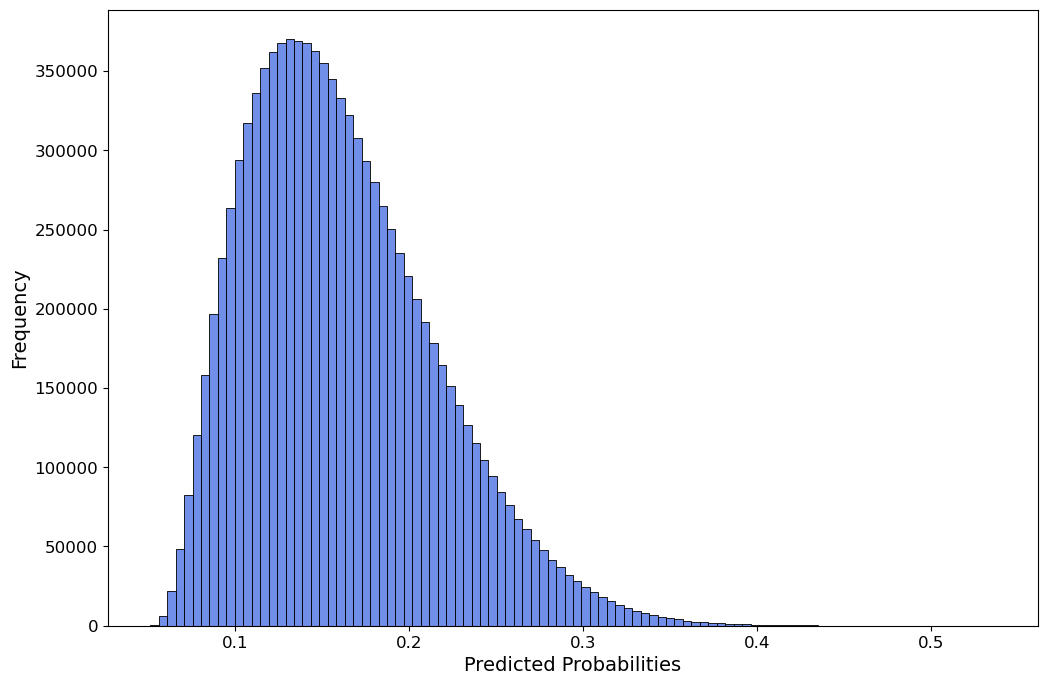

In [193]:
filename = 'histogram_model_2.pdf'
plot_histogram(pred_probs2, filename)

Percentage of 1s: 0.2283%


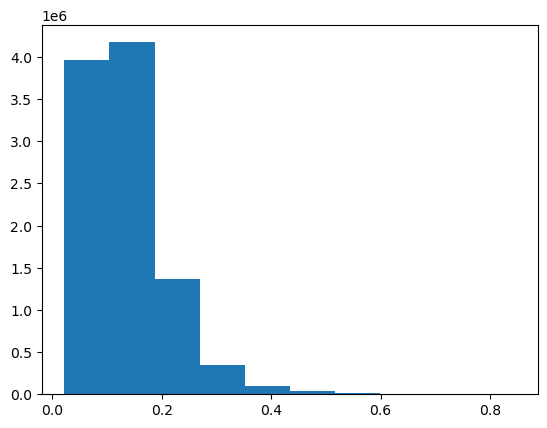

In [31]:
p3 = cal_vesicles_per(pred_probs3)